## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Net()
net.to(device)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (f1_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (f2_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout2d(p=0.5, inplace)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=1000, bias=True)
  (fc3): Line

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
corp = 168
data_transform = transforms.Compose([Rescale(180),
                                     RandomCrop(corp),
                                     Normalize(corp),
                                     ToTensor()])


# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [4]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 168, 168]) torch.Size([68, 2])
1 torch.Size([1, 168, 168]) torch.Size([68, 2])
2 torch.Size([1, 168, 168]) torch.Size([68, 2])
3 torch.Size([1, 168, 168]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [5]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [6]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)

In [7]:
# load test data in batches
# batch_size = 5

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [8]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [9]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 168, 168])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [10]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

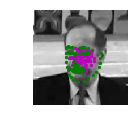

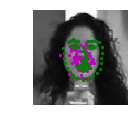

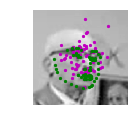

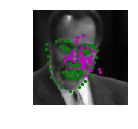

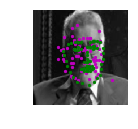

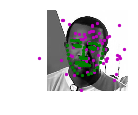

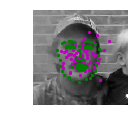

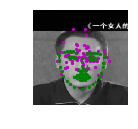

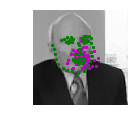

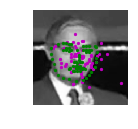

In [11]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        if torch.cuda.is_available():
            predicted_key_pts = predicted_key_pts.cpu() 
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
#         predicted_key_pts = predicted_key_pts*83.0+83
        s = image.shape[0]/2
        predicted_key_pts = (predicted_key_pts + 0.999)*s
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts =  (ground_truth_pts + 0.999)*s
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts, batch_size)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [12]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss() #nn.SmoothL1Loss

# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [13]:
def train_net(n_epochs):

    loss_over_time = [] # to track the loss as the network trains
#     train_accuracy = []

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            # key_pts = key_pts.type(torch.cuda.FloatTensor)
            key_pts = key_pts.type(torch.FloatTensor).to(device)
            #images = images.type(torch.cuda.FloatTensor)            
            images = images.type(torch.FloatTensor).to(device)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                avg_loss = running_loss/10
                # record and print the avg loss over the 10 batches
                loss_over_time.append(avg_loss)                
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time

In [14]:
# train your network
n_epochs = 1000 # start small, and increase when you've decided on your model structure and hyperparams

# call train and record the loss over time
training_loss = train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.08662107549607753
Epoch: 1, Batch: 20, Avg. Loss: 0.052539340779185296
Epoch: 1, Batch: 30, Avg. Loss: 0.04417628757655621
Epoch: 1, Batch: 40, Avg. Loss: 0.040792905166745184
Epoch: 1, Batch: 50, Avg. Loss: 0.036943408846855166
Epoch: 1, Batch: 60, Avg. Loss: 0.03296327888965607
Epoch: 1, Batch: 70, Avg. Loss: 0.03957890011370182
Epoch: 1, Batch: 80, Avg. Loss: 0.03404002524912357
Epoch: 1, Batch: 90, Avg. Loss: 0.03185390532016754
Epoch: 1, Batch: 100, Avg. Loss: 0.047351166047155856
Epoch: 1, Batch: 110, Avg. Loss: 0.03750777915120125
Epoch: 1, Batch: 120, Avg. Loss: 0.033891401067376134
Epoch: 1, Batch: 130, Avg. Loss: 0.02990487404167652
Epoch: 1, Batch: 140, Avg. Loss: 0.0461626224219799
Epoch: 1, Batch: 150, Avg. Loss: 0.03832474891096353
Epoch: 1, Batch: 160, Avg. Loss: 0.03218275271356106
Epoch: 1, Batch: 170, Avg. Loss: 0.03544460479170084
Epoch: 1, Batch: 180, Avg. Loss: 0.03698514644056559
Epoch: 1, Batch: 190, Avg. Loss: 0.0348874829709529

Epoch: 5, Batch: 200, Avg. Loss: 0.024153808318078517
Epoch: 5, Batch: 210, Avg. Loss: 0.026015570480376483
Epoch: 5, Batch: 220, Avg. Loss: 0.022923666704446077
Epoch: 5, Batch: 230, Avg. Loss: 0.019438148010522127
Epoch: 5, Batch: 240, Avg. Loss: 0.018431980069726704
Epoch: 5, Batch: 250, Avg. Loss: 0.020338659547269343
Epoch: 5, Batch: 260, Avg. Loss: 0.02196876732632518
Epoch: 5, Batch: 270, Avg. Loss: 0.022936696652323008
Epoch: 5, Batch: 280, Avg. Loss: 0.025382775533944368
Epoch: 5, Batch: 290, Avg. Loss: 0.05111371800303459
Epoch: 5, Batch: 300, Avg. Loss: 0.02013098355382681
Epoch: 5, Batch: 310, Avg. Loss: 0.021272222883999346
Epoch: 5, Batch: 320, Avg. Loss: 0.02573438696563244
Epoch: 5, Batch: 330, Avg. Loss: 0.01881962353363633
Epoch: 5, Batch: 340, Avg. Loss: 0.02404191344976425
Epoch: 6, Batch: 10, Avg. Loss: 0.023600601125508547
Epoch: 6, Batch: 20, Avg. Loss: 0.022805642150342465
Epoch: 6, Batch: 30, Avg. Loss: 0.022167742531746627
Epoch: 6, Batch: 40, Avg. Loss: 0.020

Epoch: 10, Batch: 40, Avg. Loss: 0.023869390645995737
Epoch: 10, Batch: 50, Avg. Loss: 0.014495253469794989
Epoch: 10, Batch: 60, Avg. Loss: 0.0233820759691298
Epoch: 10, Batch: 70, Avg. Loss: 0.015539072873070835
Epoch: 10, Batch: 80, Avg. Loss: 0.016001945035532116
Epoch: 10, Batch: 90, Avg. Loss: 0.014604687318205833
Epoch: 10, Batch: 100, Avg. Loss: 0.012590498477220536
Epoch: 10, Batch: 110, Avg. Loss: 0.015354008274152875
Epoch: 10, Batch: 120, Avg. Loss: 0.0103554948233068
Epoch: 10, Batch: 130, Avg. Loss: 0.018873352184891702
Epoch: 10, Batch: 140, Avg. Loss: 0.019081746321171524
Epoch: 10, Batch: 150, Avg. Loss: 0.014256860734894872
Epoch: 10, Batch: 160, Avg. Loss: 0.010643695201724767
Epoch: 10, Batch: 170, Avg. Loss: 0.012915868870913982
Epoch: 10, Batch: 180, Avg. Loss: 0.012744846055284142
Epoch: 10, Batch: 190, Avg. Loss: 0.014619111455976963
Epoch: 10, Batch: 200, Avg. Loss: 0.020415179803967475
Epoch: 10, Batch: 210, Avg. Loss: 0.012475031381472945
Epoch: 10, Batch: 22

Epoch: 14, Batch: 190, Avg. Loss: 0.019328248128294943
Epoch: 14, Batch: 200, Avg. Loss: 0.014174848794937134
Epoch: 14, Batch: 210, Avg. Loss: 0.011550244688987733
Epoch: 14, Batch: 220, Avg. Loss: 0.016777578415349124
Epoch: 14, Batch: 230, Avg. Loss: 0.01005860515870154
Epoch: 14, Batch: 240, Avg. Loss: 0.010835525952279568
Epoch: 14, Batch: 250, Avg. Loss: 0.011525074951350689
Epoch: 14, Batch: 260, Avg. Loss: 0.01145025584846735
Epoch: 14, Batch: 270, Avg. Loss: 0.013707732129842044
Epoch: 14, Batch: 280, Avg. Loss: 0.014192157238721848
Epoch: 14, Batch: 290, Avg. Loss: 0.012506310176104308
Epoch: 14, Batch: 300, Avg. Loss: 0.00788048659451306
Epoch: 14, Batch: 310, Avg. Loss: 0.01174838850274682
Epoch: 14, Batch: 320, Avg. Loss: 0.011835133284330368
Epoch: 14, Batch: 330, Avg. Loss: 0.010726339928805829
Epoch: 14, Batch: 340, Avg. Loss: 0.036040130211040376
Epoch: 15, Batch: 10, Avg. Loss: 0.01310383821837604
Epoch: 15, Batch: 20, Avg. Loss: 0.010535256611183286
Epoch: 15, Batch:

Epoch: 18, Batch: 340, Avg. Loss: 0.009665542002767324
Epoch: 19, Batch: 10, Avg. Loss: 0.008662758115679025
Epoch: 19, Batch: 20, Avg. Loss: 0.011116314912214875
Epoch: 19, Batch: 30, Avg. Loss: 0.007296156790107489
Epoch: 19, Batch: 40, Avg. Loss: 0.010282137058675289
Epoch: 19, Batch: 50, Avg. Loss: 0.012338843010365964
Epoch: 19, Batch: 60, Avg. Loss: 0.01152999741025269
Epoch: 19, Batch: 70, Avg. Loss: 0.012076623691245913
Epoch: 19, Batch: 80, Avg. Loss: 0.016355704749003053
Epoch: 19, Batch: 90, Avg. Loss: 0.01042548641562462
Epoch: 19, Batch: 100, Avg. Loss: 0.013094277353957295
Epoch: 19, Batch: 110, Avg. Loss: 0.01062017078511417
Epoch: 19, Batch: 120, Avg. Loss: 0.010138645162805915
Epoch: 19, Batch: 130, Avg. Loss: 0.02943022660911083
Epoch: 19, Batch: 140, Avg. Loss: 0.013648168230429292
Epoch: 19, Batch: 150, Avg. Loss: 0.01042940877377987
Epoch: 19, Batch: 160, Avg. Loss: 0.010891496622934937
Epoch: 19, Batch: 170, Avg. Loss: 0.009241817239671945
Epoch: 19, Batch: 180, A

Epoch: 23, Batch: 150, Avg. Loss: 0.012294146278873087
Epoch: 23, Batch: 160, Avg. Loss: 0.00908180451951921
Epoch: 23, Batch: 170, Avg. Loss: 0.008560985280200838
Epoch: 23, Batch: 180, Avg. Loss: 0.007701319130137563
Epoch: 23, Batch: 190, Avg. Loss: 0.00782777308486402
Epoch: 23, Batch: 200, Avg. Loss: 0.006531338812783361
Epoch: 23, Batch: 210, Avg. Loss: 0.0173542637610808
Epoch: 23, Batch: 220, Avg. Loss: 0.00929603255353868
Epoch: 23, Batch: 230, Avg. Loss: 0.007269767299294472
Epoch: 23, Batch: 240, Avg. Loss: 0.009008274087682367
Epoch: 23, Batch: 250, Avg. Loss: 0.010197508777491749
Epoch: 23, Batch: 260, Avg. Loss: 0.008180294861085713
Epoch: 23, Batch: 270, Avg. Loss: 0.009499783907085658
Epoch: 23, Batch: 280, Avg. Loss: 0.011543760541826487
Epoch: 23, Batch: 290, Avg. Loss: 0.007666981173679232
Epoch: 23, Batch: 300, Avg. Loss: 0.007109904428943992
Epoch: 23, Batch: 310, Avg. Loss: 0.007815029565244913
Epoch: 23, Batch: 320, Avg. Loss: 0.006800375576131046
Epoch: 23, Batc

Epoch: 27, Batch: 290, Avg. Loss: 0.0068780622677877545
Epoch: 27, Batch: 300, Avg. Loss: 0.0077973978593945505
Epoch: 27, Batch: 310, Avg. Loss: 0.008331352774985135
Epoch: 27, Batch: 320, Avg. Loss: 0.006704716105014085
Epoch: 27, Batch: 330, Avg. Loss: 0.006893193558789789
Epoch: 27, Batch: 340, Avg. Loss: 0.010559043986722827
Epoch: 28, Batch: 10, Avg. Loss: 0.006006383756175637
Epoch: 28, Batch: 20, Avg. Loss: 0.007333413092419505
Epoch: 28, Batch: 30, Avg. Loss: 0.007405538158491254
Epoch: 28, Batch: 40, Avg. Loss: 0.01096672466956079
Epoch: 28, Batch: 50, Avg. Loss: 0.00753709978889674
Epoch: 28, Batch: 60, Avg. Loss: 0.008505590399727226
Epoch: 28, Batch: 70, Avg. Loss: 0.009583099116571247
Epoch: 28, Batch: 80, Avg. Loss: 0.006333651952445507
Epoch: 28, Batch: 90, Avg. Loss: 0.007134116510860622
Epoch: 28, Batch: 100, Avg. Loss: 0.00980516653507948
Epoch: 28, Batch: 110, Avg. Loss: 0.006920698587782681
Epoch: 28, Batch: 120, Avg. Loss: 0.009072093898430467
Epoch: 28, Batch: 13

Epoch: 32, Batch: 90, Avg. Loss: 0.006857053423300385
Epoch: 32, Batch: 100, Avg. Loss: 0.009003515914082527
Epoch: 32, Batch: 110, Avg. Loss: 0.010476557817310096
Epoch: 32, Batch: 120, Avg. Loss: 0.00644523031078279
Epoch: 32, Batch: 130, Avg. Loss: 0.008213651017285883
Epoch: 32, Batch: 140, Avg. Loss: 0.009534130804240704
Epoch: 32, Batch: 150, Avg. Loss: 0.00893224561586976
Epoch: 32, Batch: 160, Avg. Loss: 0.006654937821440399
Epoch: 32, Batch: 170, Avg. Loss: 0.00768033901695162
Epoch: 32, Batch: 180, Avg. Loss: 0.006693561444990337
Epoch: 32, Batch: 190, Avg. Loss: 0.00701237702742219
Epoch: 32, Batch: 200, Avg. Loss: 0.0065341565757989885
Epoch: 32, Batch: 210, Avg. Loss: 0.006947599072009325
Epoch: 32, Batch: 220, Avg. Loss: 0.006167060858570039
Epoch: 32, Batch: 230, Avg. Loss: 0.007360293925739825
Epoch: 32, Batch: 240, Avg. Loss: 0.006337522366084159
Epoch: 32, Batch: 250, Avg. Loss: 0.006163360783830285
Epoch: 32, Batch: 260, Avg. Loss: 0.0052271770313382145
Epoch: 32, Ba

Epoch: 36, Batch: 230, Avg. Loss: 0.006769922655075788
Epoch: 36, Batch: 240, Avg. Loss: 0.009133226540870964
Epoch: 36, Batch: 250, Avg. Loss: 0.0067473293747752905
Epoch: 36, Batch: 260, Avg. Loss: 0.0057687495136633515
Epoch: 36, Batch: 270, Avg. Loss: 0.015030401921831072
Epoch: 36, Batch: 280, Avg. Loss: 0.0060034495079889895
Epoch: 36, Batch: 290, Avg. Loss: 0.006856539472937584
Epoch: 36, Batch: 300, Avg. Loss: 0.008081817347556353
Epoch: 36, Batch: 310, Avg. Loss: 0.006299318629316986
Epoch: 36, Batch: 320, Avg. Loss: 0.008608084847219288
Epoch: 36, Batch: 330, Avg. Loss: 0.005347839766182005
Epoch: 36, Batch: 340, Avg. Loss: 0.0061519178096205
Epoch: 37, Batch: 10, Avg. Loss: 0.005691085266880691
Epoch: 37, Batch: 20, Avg. Loss: 0.007883573463186622
Epoch: 37, Batch: 30, Avg. Loss: 0.007997955963946878
Epoch: 37, Batch: 40, Avg. Loss: 0.006186946108937263
Epoch: 37, Batch: 50, Avg. Loss: 0.005717982747592032
Epoch: 37, Batch: 60, Avg. Loss: 0.004415105271618813
Epoch: 37, Batc

Epoch: 41, Batch: 30, Avg. Loss: 0.006783226202242076
Epoch: 41, Batch: 40, Avg. Loss: 0.005919526261277497
Epoch: 41, Batch: 50, Avg. Loss: 0.007710659131407738
Epoch: 41, Batch: 60, Avg. Loss: 0.007641036994755268
Epoch: 41, Batch: 70, Avg. Loss: 0.006893986463546753
Epoch: 41, Batch: 80, Avg. Loss: 0.005225265002809465
Epoch: 41, Batch: 90, Avg. Loss: 0.006355222128331661
Epoch: 41, Batch: 100, Avg. Loss: 0.005432099150493741
Epoch: 41, Batch: 110, Avg. Loss: 0.007492677308619022
Epoch: 41, Batch: 120, Avg. Loss: 0.006434987112879753
Epoch: 41, Batch: 130, Avg. Loss: 0.007063935371115803
Epoch: 41, Batch: 140, Avg. Loss: 0.006063283607363701
Epoch: 41, Batch: 150, Avg. Loss: 0.020259203342720866
Epoch: 41, Batch: 160, Avg. Loss: 0.008301334828138352
Epoch: 41, Batch: 170, Avg. Loss: 0.005591482250019908
Epoch: 41, Batch: 180, Avg. Loss: 0.00833903723396361
Epoch: 41, Batch: 190, Avg. Loss: 0.015661766356788575
Epoch: 41, Batch: 200, Avg. Loss: 0.006737039634026587
Epoch: 41, Batch: 

Epoch: 45, Batch: 170, Avg. Loss: 0.00605501167010516
Epoch: 45, Batch: 180, Avg. Loss: 0.0101991543546319
Epoch: 45, Batch: 190, Avg. Loss: 0.005336084892041982
Epoch: 45, Batch: 200, Avg. Loss: 0.009357070922851563
Epoch: 45, Batch: 210, Avg. Loss: 0.005022393446415663
Epoch: 45, Batch: 220, Avg. Loss: 0.006768143200315535
Epoch: 45, Batch: 230, Avg. Loss: 0.0045982554322108625
Epoch: 45, Batch: 240, Avg. Loss: 0.005648303311318159
Epoch: 45, Batch: 250, Avg. Loss: 0.008486861176788808
Epoch: 45, Batch: 260, Avg. Loss: 0.006112127285450697
Epoch: 45, Batch: 270, Avg. Loss: 0.009367459360510111
Epoch: 45, Batch: 280, Avg. Loss: 0.006628600228577852
Epoch: 45, Batch: 290, Avg. Loss: 0.007835455262102187
Epoch: 45, Batch: 300, Avg. Loss: 0.007044083997607231
Epoch: 45, Batch: 310, Avg. Loss: 0.004908846179023385
Epoch: 45, Batch: 320, Avg. Loss: 0.005510980729013681
Epoch: 45, Batch: 330, Avg. Loss: 0.008303389512002468
Epoch: 45, Batch: 340, Avg. Loss: 0.007903343276120722
Epoch: 46, B

Epoch: 49, Batch: 310, Avg. Loss: 0.007378968270495534
Epoch: 49, Batch: 320, Avg. Loss: 0.006082999054342508
Epoch: 49, Batch: 330, Avg. Loss: 0.006082062632776797
Epoch: 49, Batch: 340, Avg. Loss: 0.00819780572783202
Epoch: 50, Batch: 10, Avg. Loss: 0.0045341816265136005
Epoch: 50, Batch: 20, Avg. Loss: 0.006516685057431459
Epoch: 50, Batch: 30, Avg. Loss: 0.009133448544889688
Epoch: 50, Batch: 40, Avg. Loss: 0.0061886321753263475
Epoch: 50, Batch: 50, Avg. Loss: 0.007766042975708843
Epoch: 50, Batch: 60, Avg. Loss: 0.005876397481188178
Epoch: 50, Batch: 70, Avg. Loss: 0.005780446017161012
Epoch: 50, Batch: 80, Avg. Loss: 0.006169018638320267
Epoch: 50, Batch: 90, Avg. Loss: 0.005465584760531783
Epoch: 50, Batch: 100, Avg. Loss: 0.008741372264921665
Epoch: 50, Batch: 110, Avg. Loss: 0.006823853915557265
Epoch: 50, Batch: 120, Avg. Loss: 0.005969323520548642
Epoch: 50, Batch: 130, Avg. Loss: 0.005311591597273946
Epoch: 50, Batch: 140, Avg. Loss: 0.004531503864564001
Epoch: 50, Batch: 

Epoch: 54, Batch: 110, Avg. Loss: 0.005582668981514871
Epoch: 54, Batch: 120, Avg. Loss: 0.005036485148593783
Epoch: 54, Batch: 130, Avg. Loss: 0.007075921632349491
Epoch: 54, Batch: 140, Avg. Loss: 0.006073744827881455
Epoch: 54, Batch: 150, Avg. Loss: 0.006195540772750974
Epoch: 54, Batch: 160, Avg. Loss: 0.004686082992702722
Epoch: 54, Batch: 170, Avg. Loss: 0.007269988930784166
Epoch: 54, Batch: 180, Avg. Loss: 0.005815914669074118
Epoch: 54, Batch: 190, Avg. Loss: 0.005037895450368523
Epoch: 54, Batch: 200, Avg. Loss: 0.005285576498135924
Epoch: 54, Batch: 210, Avg. Loss: 0.005528613063506782
Epoch: 54, Batch: 220, Avg. Loss: 0.004315447178669274
Epoch: 54, Batch: 230, Avg. Loss: 0.004311512247659266
Epoch: 54, Batch: 240, Avg. Loss: 0.016573844756931067
Epoch: 54, Batch: 250, Avg. Loss: 0.004302650946192444
Epoch: 54, Batch: 260, Avg. Loss: 0.012553955079056323
Epoch: 54, Batch: 270, Avg. Loss: 0.005872514704242349
Epoch: 54, Batch: 280, Avg. Loss: 0.00807954992633313
Epoch: 54, 

Epoch: 58, Batch: 250, Avg. Loss: 0.004784886934794485
Epoch: 58, Batch: 260, Avg. Loss: 0.004281727643683553
Epoch: 58, Batch: 270, Avg. Loss: 0.006378862145356834
Epoch: 58, Batch: 280, Avg. Loss: 0.00411172192543745
Epoch: 58, Batch: 290, Avg. Loss: 0.004960146569646895
Epoch: 58, Batch: 300, Avg. Loss: 0.004982972634024918
Epoch: 58, Batch: 310, Avg. Loss: 0.005866286018863321
Epoch: 58, Batch: 320, Avg. Loss: 0.00713057154789567
Epoch: 58, Batch: 330, Avg. Loss: 0.0052315449807792905
Epoch: 58, Batch: 340, Avg. Loss: 0.011546492087654769
Epoch: 59, Batch: 10, Avg. Loss: 0.0050259487936273215
Epoch: 59, Batch: 20, Avg. Loss: 0.0064799348590895535
Epoch: 59, Batch: 30, Avg. Loss: 0.0060692748986184595
Epoch: 59, Batch: 40, Avg. Loss: 0.004956770339049399
Epoch: 59, Batch: 50, Avg. Loss: 0.005498531158082187
Epoch: 59, Batch: 60, Avg. Loss: 0.0035714390920475124
Epoch: 59, Batch: 70, Avg. Loss: 0.004714005091227591
Epoch: 59, Batch: 80, Avg. Loss: 0.006505168764851988
Epoch: 59, Batc

Epoch: 63, Batch: 50, Avg. Loss: 0.005020480533130467
Epoch: 63, Batch: 60, Avg. Loss: 0.00923702628351748
Epoch: 63, Batch: 70, Avg. Loss: 0.006500324443913996
Epoch: 63, Batch: 80, Avg. Loss: 0.007363730319775641
Epoch: 63, Batch: 90, Avg. Loss: 0.005260223965160548
Epoch: 63, Batch: 100, Avg. Loss: 0.005117842089384794
Epoch: 63, Batch: 110, Avg. Loss: 0.007863510819151997
Epoch: 63, Batch: 120, Avg. Loss: 0.007010079361498356
Epoch: 63, Batch: 130, Avg. Loss: 0.004610255477018654
Epoch: 63, Batch: 140, Avg. Loss: 0.005306140705943108
Epoch: 63, Batch: 150, Avg. Loss: 0.004530755593441427
Epoch: 63, Batch: 160, Avg. Loss: 0.006046154419891536
Epoch: 63, Batch: 170, Avg. Loss: 0.004083102755248547
Epoch: 63, Batch: 180, Avg. Loss: 0.00615921807475388
Epoch: 63, Batch: 190, Avg. Loss: 0.00639571095816791
Epoch: 63, Batch: 200, Avg. Loss: 0.006584191508591175
Epoch: 63, Batch: 210, Avg. Loss: 0.005610054172575474
Epoch: 63, Batch: 220, Avg. Loss: 0.006970737036317587
Epoch: 63, Batch: 

Epoch: 67, Batch: 190, Avg. Loss: 0.003976708045229316
Epoch: 67, Batch: 200, Avg. Loss: 0.013496178877539932
Epoch: 67, Batch: 210, Avg. Loss: 0.004524066112935543
Epoch: 67, Batch: 220, Avg. Loss: 0.006118750642053783
Epoch: 67, Batch: 230, Avg. Loss: 0.004767621890641749
Epoch: 67, Batch: 240, Avg. Loss: 0.0050955421291291715
Epoch: 67, Batch: 250, Avg. Loss: 0.005620473646558821
Epoch: 67, Batch: 260, Avg. Loss: 0.006171539577189833
Epoch: 67, Batch: 270, Avg. Loss: 0.004576373170129955
Epoch: 67, Batch: 280, Avg. Loss: 0.005794395669363439
Epoch: 67, Batch: 290, Avg. Loss: 0.004331772867590189
Epoch: 67, Batch: 300, Avg. Loss: 0.005668893200345337
Epoch: 67, Batch: 310, Avg. Loss: 0.00504640955477953
Epoch: 67, Batch: 320, Avg. Loss: 0.00504562056157738
Epoch: 67, Batch: 330, Avg. Loss: 0.004500621440820396
Epoch: 67, Batch: 340, Avg. Loss: 0.006663804920390248
Epoch: 68, Batch: 10, Avg. Loss: 0.0048424559878185395
Epoch: 68, Batch: 20, Avg. Loss: 0.004496001568622887
Epoch: 68, B

Epoch: 71, Batch: 330, Avg. Loss: 0.0047035581897944215
Epoch: 71, Batch: 340, Avg. Loss: 0.0048011648934334515
Epoch: 72, Batch: 10, Avg. Loss: 0.005950322235003113
Epoch: 72, Batch: 20, Avg. Loss: 0.0045594629482366145
Epoch: 72, Batch: 30, Avg. Loss: 0.006491095153614878
Epoch: 72, Batch: 40, Avg. Loss: 0.00447848963085562
Epoch: 72, Batch: 50, Avg. Loss: 0.004829409997910261
Epoch: 72, Batch: 60, Avg. Loss: 0.00952109599020332
Epoch: 72, Batch: 70, Avg. Loss: 0.00484239193610847
Epoch: 72, Batch: 80, Avg. Loss: 0.004391874559223652
Epoch: 72, Batch: 90, Avg. Loss: 0.004884378612041473
Epoch: 72, Batch: 100, Avg. Loss: 0.004861548147164285
Epoch: 72, Batch: 110, Avg. Loss: 0.0048195973737165335
Epoch: 72, Batch: 120, Avg. Loss: 0.005100747221149504
Epoch: 72, Batch: 130, Avg. Loss: 0.003714948077686131
Epoch: 72, Batch: 140, Avg. Loss: 0.004913059924729168
Epoch: 72, Batch: 150, Avg. Loss: 0.005104460055008531
Epoch: 72, Batch: 160, Avg. Loss: 0.005949529679492116
Epoch: 72, Batch: 

Epoch: 76, Batch: 130, Avg. Loss: 0.004253325005993247
Epoch: 76, Batch: 140, Avg. Loss: 0.0038622054853476584
Epoch: 76, Batch: 150, Avg. Loss: 0.005497958464547992
Epoch: 76, Batch: 160, Avg. Loss: 0.004872335423715413
Epoch: 76, Batch: 170, Avg. Loss: 0.004152750677894801
Epoch: 76, Batch: 180, Avg. Loss: 0.00420354176312685
Epoch: 76, Batch: 190, Avg. Loss: 0.006373258144594729
Epoch: 76, Batch: 200, Avg. Loss: 0.004936364770401269
Epoch: 76, Batch: 210, Avg. Loss: 0.004966451972723007
Epoch: 76, Batch: 220, Avg. Loss: 0.006161786173470319
Epoch: 76, Batch: 230, Avg. Loss: 0.005092335073277355
Epoch: 76, Batch: 240, Avg. Loss: 0.005050266697071493
Epoch: 76, Batch: 250, Avg. Loss: 0.004800166818313301
Epoch: 76, Batch: 260, Avg. Loss: 0.02109869383275509
Epoch: 76, Batch: 270, Avg. Loss: 0.006875308440066874
Epoch: 76, Batch: 280, Avg. Loss: 0.0051698833238333465
Epoch: 76, Batch: 290, Avg. Loss: 0.005938941496424377
Epoch: 76, Batch: 300, Avg. Loss: 0.0038565024500712753
Epoch: 76

Epoch: 80, Batch: 270, Avg. Loss: 0.0036426410311833023
Epoch: 80, Batch: 280, Avg. Loss: 0.004971311287954449
Epoch: 80, Batch: 290, Avg. Loss: 0.004672934021800757
Epoch: 80, Batch: 300, Avg. Loss: 0.004181509662885219
Epoch: 80, Batch: 310, Avg. Loss: 0.003999375691637397
Epoch: 80, Batch: 320, Avg. Loss: 0.0033544853562489153
Epoch: 80, Batch: 330, Avg. Loss: 0.004045163933187723
Epoch: 80, Batch: 340, Avg. Loss: 0.005937130865640938
Epoch: 81, Batch: 10, Avg. Loss: 0.004964142851531505
Epoch: 81, Batch: 20, Avg. Loss: 0.004530100710690021
Epoch: 81, Batch: 30, Avg. Loss: 0.019536053668707608
Epoch: 81, Batch: 40, Avg. Loss: 0.006288980203680694
Epoch: 81, Batch: 50, Avg. Loss: 0.005703002889640629
Epoch: 81, Batch: 60, Avg. Loss: 0.005308653158135712
Epoch: 81, Batch: 70, Avg. Loss: 0.0053229127312079075
Epoch: 81, Batch: 80, Avg. Loss: 0.004993640352040529
Epoch: 81, Batch: 90, Avg. Loss: 0.0036784498719498516
Epoch: 81, Batch: 100, Avg. Loss: 0.004695443925447762
Epoch: 81, Batc

Epoch: 85, Batch: 70, Avg. Loss: 0.0077673118794336915
Epoch: 85, Batch: 80, Avg. Loss: 0.003918492863886058
Epoch: 85, Batch: 90, Avg. Loss: 0.003563190344721079
Epoch: 85, Batch: 100, Avg. Loss: 0.0032698464347049594
Epoch: 85, Batch: 110, Avg. Loss: 0.0040979926008731125
Epoch: 85, Batch: 120, Avg. Loss: 0.006041244952939451
Epoch: 85, Batch: 130, Avg. Loss: 0.005469893221743405
Epoch: 85, Batch: 140, Avg. Loss: 0.013445280538871885
Epoch: 85, Batch: 150, Avg. Loss: 0.00552194204647094
Epoch: 85, Batch: 160, Avg. Loss: 0.0075442750006914135
Epoch: 85, Batch: 170, Avg. Loss: 0.0033526289043948054
Epoch: 85, Batch: 180, Avg. Loss: 0.004305467195808888
Epoch: 85, Batch: 190, Avg. Loss: 0.004673202335834503
Epoch: 85, Batch: 200, Avg. Loss: 0.003999216109514236
Epoch: 85, Batch: 210, Avg. Loss: 0.0046151194255799055
Epoch: 85, Batch: 220, Avg. Loss: 0.004416752606630325
Epoch: 85, Batch: 230, Avg. Loss: 0.005381947732530534
Epoch: 85, Batch: 240, Avg. Loss: 0.004439222090877592
Epoch: 8

Epoch: 89, Batch: 210, Avg. Loss: 0.004340398660860956
Epoch: 89, Batch: 220, Avg. Loss: 0.003101578075438738
Epoch: 89, Batch: 230, Avg. Loss: 0.003386833332479
Epoch: 89, Batch: 240, Avg. Loss: 0.0035104839131236075
Epoch: 89, Batch: 250, Avg. Loss: 0.004491415154188871
Epoch: 89, Batch: 260, Avg. Loss: 0.0037019337294623257
Epoch: 89, Batch: 270, Avg. Loss: 0.004585364973172546
Epoch: 89, Batch: 280, Avg. Loss: 0.004189785732887685
Epoch: 89, Batch: 290, Avg. Loss: 0.0031106532085686924
Epoch: 89, Batch: 300, Avg. Loss: 0.004671738273464144
Epoch: 89, Batch: 310, Avg. Loss: 0.010615251027047634
Epoch: 89, Batch: 320, Avg. Loss: 0.0045434021390974525
Epoch: 89, Batch: 330, Avg. Loss: 0.0041660511866211895
Epoch: 89, Batch: 340, Avg. Loss: 0.005952271434944123
Epoch: 90, Batch: 10, Avg. Loss: 0.0042926912778057155
Epoch: 90, Batch: 20, Avg. Loss: 0.004184357170015573
Epoch: 90, Batch: 30, Avg. Loss: 0.003694974770769477
Epoch: 90, Batch: 40, Avg. Loss: 0.00531219010008499
Epoch: 90, B

Epoch: 94, Batch: 10, Avg. Loss: 0.003999041288625449
Epoch: 94, Batch: 20, Avg. Loss: 0.0039887830382212995
Epoch: 94, Batch: 30, Avg. Loss: 0.005179946718271822
Epoch: 94, Batch: 40, Avg. Loss: 0.0049460989655926825
Epoch: 94, Batch: 50, Avg. Loss: 0.009535848069936037
Epoch: 94, Batch: 60, Avg. Loss: 0.005334481806494295
Epoch: 94, Batch: 70, Avg. Loss: 0.0038634434342384337
Epoch: 94, Batch: 80, Avg. Loss: 0.006351207254920155
Epoch: 94, Batch: 90, Avg. Loss: 0.015515846782363951
Epoch: 94, Batch: 100, Avg. Loss: 0.005662760650739074
Epoch: 94, Batch: 110, Avg. Loss: 0.004374809493310749
Epoch: 94, Batch: 120, Avg. Loss: 0.004850641172379255
Epoch: 94, Batch: 130, Avg. Loss: 0.030419495748355986
Epoch: 94, Batch: 140, Avg. Loss: 0.004024518840014935
Epoch: 94, Batch: 150, Avg. Loss: 0.006770682684145868
Epoch: 94, Batch: 160, Avg. Loss: 0.0046632494777441025
Epoch: 94, Batch: 170, Avg. Loss: 0.0051799450069665905
Epoch: 94, Batch: 180, Avg. Loss: 0.004475001711398363
Epoch: 94, Bat

Epoch: 98, Batch: 150, Avg. Loss: 0.004623169451951981
Epoch: 98, Batch: 160, Avg. Loss: 0.0038582587032578884
Epoch: 98, Batch: 170, Avg. Loss: 0.006477535294834524
Epoch: 98, Batch: 180, Avg. Loss: 0.004292723326943815
Epoch: 98, Batch: 190, Avg. Loss: 0.004084285104181617
Epoch: 98, Batch: 200, Avg. Loss: 0.005107764038257301
Epoch: 98, Batch: 210, Avg. Loss: 0.005339251167606562
Epoch: 98, Batch: 220, Avg. Loss: 0.004232938436325639
Epoch: 98, Batch: 230, Avg. Loss: 0.004121803562156856
Epoch: 98, Batch: 240, Avg. Loss: 0.004615548485890031
Epoch: 98, Batch: 250, Avg. Loss: 0.006207527709193528
Epoch: 98, Batch: 260, Avg. Loss: 0.003496148460544646
Epoch: 98, Batch: 270, Avg. Loss: 0.0036610979586839676
Epoch: 98, Batch: 280, Avg. Loss: 0.006114732997957617
Epoch: 98, Batch: 290, Avg. Loss: 0.004772895388305188
Epoch: 98, Batch: 300, Avg. Loss: 0.00903849529568106
Epoch: 98, Batch: 310, Avg. Loss: 0.00483892560005188
Epoch: 98, Batch: 320, Avg. Loss: 0.005348301073536277
Epoch: 98,

Epoch: 102, Batch: 270, Avg. Loss: 0.005222938233055174
Epoch: 102, Batch: 280, Avg. Loss: 0.004075202648527921
Epoch: 102, Batch: 290, Avg. Loss: 0.0055998442461714145
Epoch: 102, Batch: 300, Avg. Loss: 0.0056656464003026485
Epoch: 102, Batch: 310, Avg. Loss: 0.004229954350739718
Epoch: 102, Batch: 320, Avg. Loss: 0.003863738873042166
Epoch: 102, Batch: 330, Avg. Loss: 0.003965272358618677
Epoch: 102, Batch: 340, Avg. Loss: 0.0043461185181513425
Epoch: 103, Batch: 10, Avg. Loss: 0.004692474077455699
Epoch: 103, Batch: 20, Avg. Loss: 0.006854944094084203
Epoch: 103, Batch: 30, Avg. Loss: 0.0033415617421269418
Epoch: 103, Batch: 40, Avg. Loss: 0.004595731664448976
Epoch: 103, Batch: 50, Avg. Loss: 0.004834003676660359
Epoch: 103, Batch: 60, Avg. Loss: 0.004020077525638044
Epoch: 103, Batch: 70, Avg. Loss: 0.004745495039969683
Epoch: 103, Batch: 80, Avg. Loss: 0.006711125443689525
Epoch: 103, Batch: 90, Avg. Loss: 0.0038281364599242807
Epoch: 103, Batch: 100, Avg. Loss: 0.005526840663515

Epoch: 107, Batch: 40, Avg. Loss: 0.006032889196649194
Epoch: 107, Batch: 50, Avg. Loss: 0.005192200234159827
Epoch: 107, Batch: 60, Avg. Loss: 0.0034292505821213125
Epoch: 107, Batch: 70, Avg. Loss: 0.0036675898358225823
Epoch: 107, Batch: 80, Avg. Loss: 0.005270022840704769
Epoch: 107, Batch: 90, Avg. Loss: 0.004640170023776591
Epoch: 107, Batch: 100, Avg. Loss: 0.004972720332443714
Epoch: 107, Batch: 110, Avg. Loss: 0.0034407595521770418
Epoch: 107, Batch: 120, Avg. Loss: 0.00379079031990841
Epoch: 107, Batch: 130, Avg. Loss: 0.00724232685752213
Epoch: 107, Batch: 140, Avg. Loss: 0.0036328321089968084
Epoch: 107, Batch: 150, Avg. Loss: 0.0045183235313743355
Epoch: 107, Batch: 160, Avg. Loss: 0.005329477810300886
Epoch: 107, Batch: 170, Avg. Loss: 0.0037457535276189447
Epoch: 107, Batch: 180, Avg. Loss: 0.0031585205346345902
Epoch: 107, Batch: 190, Avg. Loss: 0.006289489171467722
Epoch: 107, Batch: 200, Avg. Loss: 0.0037832846865057945
Epoch: 107, Batch: 210, Avg. Loss: 0.00506665403

Epoch: 111, Batch: 150, Avg. Loss: 0.004159535840153694
Epoch: 111, Batch: 160, Avg. Loss: 0.004608029220253229
Epoch: 111, Batch: 170, Avg. Loss: 0.0038936706027016045
Epoch: 111, Batch: 180, Avg. Loss: 0.003590631461702287
Epoch: 111, Batch: 190, Avg. Loss: 0.004363898327574134
Epoch: 111, Batch: 200, Avg. Loss: 0.0049383007688447835
Epoch: 111, Batch: 210, Avg. Loss: 0.004173602606169879
Epoch: 111, Batch: 220, Avg. Loss: 0.003921214211732149
Epoch: 111, Batch: 230, Avg. Loss: 0.0053945256164297465
Epoch: 111, Batch: 240, Avg. Loss: 0.0042769289808347825
Epoch: 111, Batch: 250, Avg. Loss: 0.00436606933362782
Epoch: 111, Batch: 260, Avg. Loss: 0.005134355172049254
Epoch: 111, Batch: 270, Avg. Loss: 0.004645779100246728
Epoch: 111, Batch: 280, Avg. Loss: 0.004635547776706517
Epoch: 111, Batch: 290, Avg. Loss: 0.0038866459392011164
Epoch: 111, Batch: 300, Avg. Loss: 0.004414015496149659
Epoch: 111, Batch: 310, Avg. Loss: 0.002893158234655857
Epoch: 111, Batch: 320, Avg. Loss: 0.0039895

Epoch: 115, Batch: 260, Avg. Loss: 0.003484887257218361
Epoch: 115, Batch: 270, Avg. Loss: 0.00577381628099829
Epoch: 115, Batch: 280, Avg. Loss: 0.004744423227384687
Epoch: 115, Batch: 290, Avg. Loss: 0.004784353822469711
Epoch: 115, Batch: 300, Avg. Loss: 0.0033508491469547153
Epoch: 115, Batch: 310, Avg. Loss: 0.004170886357314885
Epoch: 115, Batch: 320, Avg. Loss: 0.004441986791789532
Epoch: 115, Batch: 330, Avg. Loss: 0.0036671581445261838
Epoch: 115, Batch: 340, Avg. Loss: 0.0035841506440192463
Epoch: 116, Batch: 10, Avg. Loss: 0.004419284546747804
Epoch: 116, Batch: 20, Avg. Loss: 0.006419433606788516
Epoch: 116, Batch: 30, Avg. Loss: 0.005948929884470999
Epoch: 116, Batch: 40, Avg. Loss: 0.0077370099490508435
Epoch: 116, Batch: 50, Avg. Loss: 0.0058620722964406015
Epoch: 116, Batch: 60, Avg. Loss: 0.004551998630631715
Epoch: 116, Batch: 70, Avg. Loss: 0.003902272949926555
Epoch: 116, Batch: 80, Avg. Loss: 0.0033954948768950997
Epoch: 116, Batch: 90, Avg. Loss: 0.003857808397151

Epoch: 120, Batch: 30, Avg. Loss: 0.00660790300462395
Epoch: 120, Batch: 40, Avg. Loss: 0.003683061967603862
Epoch: 120, Batch: 50, Avg. Loss: 0.0032527624629437924
Epoch: 120, Batch: 60, Avg. Loss: 0.0035379277542233467
Epoch: 120, Batch: 70, Avg. Loss: 0.003603967628441751
Epoch: 120, Batch: 80, Avg. Loss: 0.0028585724532604216
Epoch: 120, Batch: 90, Avg. Loss: 0.006612596078775823
Epoch: 120, Batch: 100, Avg. Loss: 0.004009588516782969
Epoch: 120, Batch: 110, Avg. Loss: 0.00434697070159018
Epoch: 120, Batch: 120, Avg. Loss: 0.0036596621386706827
Epoch: 120, Batch: 130, Avg. Loss: 0.004371823661495
Epoch: 120, Batch: 140, Avg. Loss: 0.004619150108192116
Epoch: 120, Batch: 150, Avg. Loss: 0.004149983800016343
Epoch: 120, Batch: 160, Avg. Loss: 0.003734036989044398
Epoch: 120, Batch: 170, Avg. Loss: 0.004337704065255821
Epoch: 120, Batch: 180, Avg. Loss: 0.004737670719623566
Epoch: 120, Batch: 190, Avg. Loss: 0.0052567278733477
Epoch: 120, Batch: 200, Avg. Loss: 0.003599691460840404
Ep

Epoch: 124, Batch: 140, Avg. Loss: 0.0033639363595284522
Epoch: 124, Batch: 150, Avg. Loss: 0.004499968700110912
Epoch: 124, Batch: 160, Avg. Loss: 0.003965822141617536
Epoch: 124, Batch: 170, Avg. Loss: 0.003855734295211732
Epoch: 124, Batch: 180, Avg. Loss: 0.004572459845803678
Epoch: 124, Batch: 190, Avg. Loss: 0.0136895903153345
Epoch: 124, Batch: 200, Avg. Loss: 0.01414922291878611
Epoch: 124, Batch: 210, Avg. Loss: 0.0036678433883935214
Epoch: 124, Batch: 220, Avg. Loss: 0.004396772827021778
Epoch: 124, Batch: 230, Avg. Loss: 0.004732944001443684
Epoch: 124, Batch: 240, Avg. Loss: 0.004833375092130154
Epoch: 124, Batch: 250, Avg. Loss: 0.00376180550083518
Epoch: 124, Batch: 260, Avg. Loss: 0.005290533439256251
Epoch: 124, Batch: 270, Avg. Loss: 0.006452451762743294
Epoch: 124, Batch: 280, Avg. Loss: 0.004293447034433484
Epoch: 124, Batch: 290, Avg. Loss: 0.004300583829171955
Epoch: 124, Batch: 300, Avg. Loss: 0.003734567225910723
Epoch: 124, Batch: 310, Avg. Loss: 0.0052061766153

Epoch: 128, Batch: 250, Avg. Loss: 0.004459100472740829
Epoch: 128, Batch: 260, Avg. Loss: 0.0038601453648880123
Epoch: 128, Batch: 270, Avg. Loss: 0.0036306277732364835
Epoch: 128, Batch: 280, Avg. Loss: 0.0036801495123654606
Epoch: 128, Batch: 290, Avg. Loss: 0.004106164793483913
Epoch: 128, Batch: 300, Avg. Loss: 0.0036799718625843527
Epoch: 128, Batch: 310, Avg. Loss: 0.0038938089739531277
Epoch: 128, Batch: 320, Avg. Loss: 0.004867306689266116
Epoch: 128, Batch: 330, Avg. Loss: 0.003729106392711401
Epoch: 128, Batch: 340, Avg. Loss: 0.0032921097707003357
Epoch: 129, Batch: 10, Avg. Loss: 0.00550778852775693
Epoch: 129, Batch: 20, Avg. Loss: 0.004846256016753614
Epoch: 129, Batch: 30, Avg. Loss: 0.003379293577745557
Epoch: 129, Batch: 40, Avg. Loss: 0.005626567895524204
Epoch: 129, Batch: 50, Avg. Loss: 0.004070567851886153
Epoch: 129, Batch: 60, Avg. Loss: 0.0049605539068579676
Epoch: 129, Batch: 70, Avg. Loss: 0.003429366566706449
Epoch: 129, Batch: 80, Avg. Loss: 0.0146946098422

Epoch: 133, Batch: 20, Avg. Loss: 0.003941330127418041
Epoch: 133, Batch: 30, Avg. Loss: 0.006861985591240227
Epoch: 133, Batch: 40, Avg. Loss: 0.003271035139914602
Epoch: 133, Batch: 50, Avg. Loss: 0.008029028493911027
Epoch: 133, Batch: 60, Avg. Loss: 0.004027537512592971
Epoch: 133, Batch: 70, Avg. Loss: 0.0052879269700497385
Epoch: 133, Batch: 80, Avg. Loss: 0.0037274972884915767
Epoch: 133, Batch: 90, Avg. Loss: 0.003485502360854298
Epoch: 133, Batch: 100, Avg. Loss: 0.005565088812727481
Epoch: 133, Batch: 110, Avg. Loss: 0.004587913735304028
Epoch: 133, Batch: 120, Avg. Loss: 0.0030687547288835047
Epoch: 133, Batch: 130, Avg. Loss: 0.004493086063303053
Epoch: 133, Batch: 140, Avg. Loss: 0.003826565924100578
Epoch: 133, Batch: 150, Avg. Loss: 0.003942124673631042
Epoch: 133, Batch: 160, Avg. Loss: 0.006094475591089577
Epoch: 133, Batch: 170, Avg. Loss: 0.004086852073669434
Epoch: 133, Batch: 180, Avg. Loss: 0.003667209413833916
Epoch: 133, Batch: 190, Avg. Loss: 0.0040419993689283

Epoch: 137, Batch: 130, Avg. Loss: 0.00450764384586364
Epoch: 137, Batch: 140, Avg. Loss: 0.003260553418658674
Epoch: 137, Batch: 150, Avg. Loss: 0.0036492612096481027
Epoch: 137, Batch: 160, Avg. Loss: 0.006582314032129943
Epoch: 137, Batch: 170, Avg. Loss: 0.003717667958699167
Epoch: 137, Batch: 180, Avg. Loss: 0.0033949230099096896
Epoch: 137, Batch: 190, Avg. Loss: 0.004291417519561946
Epoch: 137, Batch: 200, Avg. Loss: 0.003968047408852727
Epoch: 137, Batch: 210, Avg. Loss: 0.013839372899383307
Epoch: 137, Batch: 220, Avg. Loss: 0.0033154837903566657
Epoch: 137, Batch: 230, Avg. Loss: 0.0031532694585621355
Epoch: 137, Batch: 240, Avg. Loss: 0.0046678745653480295
Epoch: 137, Batch: 250, Avg. Loss: 0.004361068760044873
Epoch: 137, Batch: 260, Avg. Loss: 0.0034729970851913095
Epoch: 137, Batch: 270, Avg. Loss: 0.0036955638090148566
Epoch: 137, Batch: 280, Avg. Loss: 0.004799638129770756
Epoch: 137, Batch: 290, Avg. Loss: 0.0034833939047530294
Epoch: 137, Batch: 300, Avg. Loss: 0.0031

Epoch: 141, Batch: 240, Avg. Loss: 0.004059272538870573
Epoch: 141, Batch: 250, Avg. Loss: 0.005284436151850968
Epoch: 141, Batch: 260, Avg. Loss: 0.003848249767906964
Epoch: 141, Batch: 270, Avg. Loss: 0.003424420894589275
Epoch: 141, Batch: 280, Avg. Loss: 0.004386877524666488
Epoch: 141, Batch: 290, Avg. Loss: 0.004711693967692554
Epoch: 141, Batch: 300, Avg. Loss: 0.003894760739058256
Epoch: 141, Batch: 310, Avg. Loss: 0.0035268365638330577
Epoch: 141, Batch: 320, Avg. Loss: 0.003945789742283523
Epoch: 141, Batch: 330, Avg. Loss: 0.0046024553361348804
Epoch: 141, Batch: 340, Avg. Loss: 0.0030448352452367546
Epoch: 142, Batch: 10, Avg. Loss: 0.006204128521494568
Epoch: 142, Batch: 20, Avg. Loss: 0.003052483149804175
Epoch: 142, Batch: 30, Avg. Loss: 0.0034426940139383076
Epoch: 142, Batch: 40, Avg. Loss: 0.0028091474901884793
Epoch: 142, Batch: 50, Avg. Loss: 0.004633260774426162
Epoch: 142, Batch: 60, Avg. Loss: 0.002863524481654167
Epoch: 142, Batch: 70, Avg. Loss: 0.0047910940484

Epoch: 146, Batch: 10, Avg. Loss: 0.0030381825286895036
Epoch: 146, Batch: 20, Avg. Loss: 0.003382502868771553
Epoch: 146, Batch: 30, Avg. Loss: 0.0032185793854296206
Epoch: 146, Batch: 40, Avg. Loss: 0.0035468168091028927
Epoch: 146, Batch: 50, Avg. Loss: 0.003765578079037368
Epoch: 146, Batch: 60, Avg. Loss: 0.003841888427268714
Epoch: 146, Batch: 70, Avg. Loss: 0.0028558467281982304
Epoch: 146, Batch: 80, Avg. Loss: 0.0030064949300140143
Epoch: 146, Batch: 90, Avg. Loss: 0.002773513307329267
Epoch: 146, Batch: 100, Avg. Loss: 0.003214318514801562
Epoch: 146, Batch: 110, Avg. Loss: 0.004564079502597451
Epoch: 146, Batch: 120, Avg. Loss: 0.00370094747049734
Epoch: 146, Batch: 130, Avg. Loss: 0.004413390345871448
Epoch: 146, Batch: 140, Avg. Loss: 0.004152362141758204
Epoch: 146, Batch: 150, Avg. Loss: 0.00472411192022264
Epoch: 146, Batch: 160, Avg. Loss: 0.003076357045210898
Epoch: 146, Batch: 170, Avg. Loss: 0.0032067276653833686
Epoch: 146, Batch: 180, Avg. Loss: 0.0043843650259077

Epoch: 150, Batch: 120, Avg. Loss: 0.0035260384203866122
Epoch: 150, Batch: 130, Avg. Loss: 0.0031995509751141073
Epoch: 150, Batch: 140, Avg. Loss: 0.0037668422563001515
Epoch: 150, Batch: 150, Avg. Loss: 0.00362699490506202
Epoch: 150, Batch: 160, Avg. Loss: 0.008105501835234463
Epoch: 150, Batch: 170, Avg. Loss: 0.005224824906326831
Epoch: 150, Batch: 180, Avg. Loss: 0.006222706707194448
Epoch: 150, Batch: 190, Avg. Loss: 0.004287832300178707
Epoch: 150, Batch: 200, Avg. Loss: 0.0035883233416825534
Epoch: 150, Batch: 210, Avg. Loss: 0.0032773372600786387
Epoch: 150, Batch: 220, Avg. Loss: 0.0037181963212788104
Epoch: 150, Batch: 230, Avg. Loss: 0.006475016567856073
Epoch: 150, Batch: 240, Avg. Loss: 0.003425640240311623
Epoch: 150, Batch: 250, Avg. Loss: 0.003176286187954247
Epoch: 150, Batch: 260, Avg. Loss: 0.004192466055974365
Epoch: 150, Batch: 270, Avg. Loss: 0.003122285951394588
Epoch: 150, Batch: 280, Avg. Loss: 0.003204870386980474
Epoch: 150, Batch: 290, Avg. Loss: 0.003200

Epoch: 154, Batch: 230, Avg. Loss: 0.003730087191797793
Epoch: 154, Batch: 240, Avg. Loss: 0.0035051168873906136
Epoch: 154, Batch: 250, Avg. Loss: 0.0031134710647165776
Epoch: 154, Batch: 260, Avg. Loss: 0.0029373703058809043
Epoch: 154, Batch: 270, Avg. Loss: 0.003494201460853219
Epoch: 154, Batch: 280, Avg. Loss: 0.0036284597823396324
Epoch: 154, Batch: 290, Avg. Loss: 0.003161408251617104
Epoch: 154, Batch: 300, Avg. Loss: 0.0033231986686587333
Epoch: 154, Batch: 310, Avg. Loss: 0.020892603369429708
Epoch: 154, Batch: 320, Avg. Loss: 0.0035116976127028466
Epoch: 154, Batch: 330, Avg. Loss: 0.0037675432860851286
Epoch: 154, Batch: 340, Avg. Loss: 0.0039995163679122925
Epoch: 155, Batch: 10, Avg. Loss: 0.003758882777765393
Epoch: 155, Batch: 20, Avg. Loss: 0.005199516657739878
Epoch: 155, Batch: 30, Avg. Loss: 0.003598238783888519
Epoch: 155, Batch: 40, Avg. Loss: 0.003404594026505947
Epoch: 155, Batch: 50, Avg. Loss: 0.004578131414018571
Epoch: 155, Batch: 60, Avg. Loss: 0.003415347

Epoch: 158, Batch: 340, Avg. Loss: 0.0035887996782548726
Epoch: 159, Batch: 10, Avg. Loss: 0.0031943268375471236
Epoch: 159, Batch: 20, Avg. Loss: 0.0037486939691007137
Epoch: 159, Batch: 30, Avg. Loss: 0.004148450144566595
Epoch: 159, Batch: 40, Avg. Loss: 0.003347701660823077
Epoch: 159, Batch: 50, Avg. Loss: 0.0037697726394981144
Epoch: 159, Batch: 60, Avg. Loss: 0.0038669178728014232
Epoch: 159, Batch: 70, Avg. Loss: 0.003727758058812469
Epoch: 159, Batch: 80, Avg. Loss: 0.0033160501159727575
Epoch: 159, Batch: 90, Avg. Loss: 0.0037079999689012765
Epoch: 159, Batch: 100, Avg. Loss: 0.006159259437117726
Epoch: 159, Batch: 110, Avg. Loss: 0.0035894076339900494
Epoch: 159, Batch: 120, Avg. Loss: 0.0031129635171964765
Epoch: 159, Batch: 130, Avg. Loss: 0.0034540459513664246
Epoch: 159, Batch: 140, Avg. Loss: 0.0029190925415605307
Epoch: 159, Batch: 150, Avg. Loss: 0.005438052432145924
Epoch: 159, Batch: 160, Avg. Loss: 0.010389315220527351
Epoch: 159, Batch: 170, Avg. Loss: 0.003129142

Epoch: 163, Batch: 110, Avg. Loss: 0.00393777284771204
Epoch: 163, Batch: 120, Avg. Loss: 0.0033110362011939285
Epoch: 163, Batch: 130, Avg. Loss: 0.004293701448477805
Epoch: 163, Batch: 140, Avg. Loss: 0.0040298010222613815
Epoch: 163, Batch: 150, Avg. Loss: 0.0036558367544785144
Epoch: 163, Batch: 160, Avg. Loss: 0.003202002006582916
Epoch: 163, Batch: 170, Avg. Loss: 0.003070213855244219
Epoch: 163, Batch: 180, Avg. Loss: 0.0035181382670998575
Epoch: 163, Batch: 190, Avg. Loss: 0.0031992085045203567
Epoch: 163, Batch: 200, Avg. Loss: 0.0033616929315030573
Epoch: 163, Batch: 210, Avg. Loss: 0.0033853995031677187
Epoch: 163, Batch: 220, Avg. Loss: 0.005889403889887035
Epoch: 163, Batch: 230, Avg. Loss: 0.003010513144545257
Epoch: 163, Batch: 240, Avg. Loss: 0.0066755461390130225
Epoch: 163, Batch: 250, Avg. Loss: 0.0029868656303733586
Epoch: 163, Batch: 260, Avg. Loss: 0.0048057407606393095
Epoch: 163, Batch: 270, Avg. Loss: 0.003791654366068542
Epoch: 163, Batch: 280, Avg. Loss: 0.00

Epoch: 167, Batch: 220, Avg. Loss: 0.012413415114860982
Epoch: 167, Batch: 230, Avg. Loss: 0.004950977559201419
Epoch: 167, Batch: 240, Avg. Loss: 0.0032751338556408884
Epoch: 167, Batch: 250, Avg. Loss: 0.0037544145132415
Epoch: 167, Batch: 260, Avg. Loss: 0.002668086357880384
Epoch: 167, Batch: 270, Avg. Loss: 0.00375147582963109
Epoch: 167, Batch: 280, Avg. Loss: 0.004167149518616497
Epoch: 167, Batch: 290, Avg. Loss: 0.004071462003048509
Epoch: 167, Batch: 300, Avg. Loss: 0.0038036103826016186
Epoch: 167, Batch: 310, Avg. Loss: 0.003292028373107314
Epoch: 167, Batch: 320, Avg. Loss: 0.0038549619261175395
Epoch: 167, Batch: 330, Avg. Loss: 0.0028283493244089185
Epoch: 167, Batch: 340, Avg. Loss: 0.003774735075421631
Epoch: 168, Batch: 10, Avg. Loss: 0.004537906870245934
Epoch: 168, Batch: 20, Avg. Loss: 0.004375978000462055
Epoch: 168, Batch: 30, Avg. Loss: 0.003471629542764276
Epoch: 168, Batch: 40, Avg. Loss: 0.003165908739902079
Epoch: 168, Batch: 50, Avg. Loss: 0.002770217473153

Epoch: 171, Batch: 320, Avg. Loss: 0.003288989735301584
Epoch: 171, Batch: 330, Avg. Loss: 0.003466226486489177
Epoch: 171, Batch: 340, Avg. Loss: 0.002866943960543722
Epoch: 172, Batch: 10, Avg. Loss: 0.003659505094401538
Epoch: 172, Batch: 20, Avg. Loss: 0.003522424306720495
Epoch: 172, Batch: 30, Avg. Loss: 0.0029209372587502003
Epoch: 172, Batch: 40, Avg. Loss: 0.0032636306248605253
Epoch: 172, Batch: 50, Avg. Loss: 0.003696195804513991
Epoch: 172, Batch: 60, Avg. Loss: 0.002979151753243059
Epoch: 172, Batch: 70, Avg. Loss: 0.0030619673780165613
Epoch: 172, Batch: 80, Avg. Loss: 0.0034515098319388925
Epoch: 172, Batch: 90, Avg. Loss: 0.0036475300090387463
Epoch: 172, Batch: 100, Avg. Loss: 0.0030763447284698486
Epoch: 172, Batch: 110, Avg. Loss: 0.005506934458389878
Epoch: 172, Batch: 120, Avg. Loss: 0.006488099868874997
Epoch: 172, Batch: 130, Avg. Loss: 0.003243319725152105
Epoch: 172, Batch: 140, Avg. Loss: 0.0032892069313675163
Epoch: 172, Batch: 150, Avg. Loss: 0.0049967271042

Epoch: 176, Batch: 90, Avg. Loss: 0.0035917248809710146
Epoch: 176, Batch: 100, Avg. Loss: 0.002986496442463249
Epoch: 176, Batch: 110, Avg. Loss: 0.0035460711224004626
Epoch: 176, Batch: 120, Avg. Loss: 0.0033302036579698326
Epoch: 176, Batch: 130, Avg. Loss: 0.0028882614453323184
Epoch: 176, Batch: 140, Avg. Loss: 0.0027494054869748653
Epoch: 176, Batch: 150, Avg. Loss: 0.004751401068642735
Epoch: 176, Batch: 160, Avg. Loss: 0.0032008423935621978
Epoch: 176, Batch: 170, Avg. Loss: 0.003238302934914827
Epoch: 176, Batch: 180, Avg. Loss: 0.0026720388676039876
Epoch: 176, Batch: 190, Avg. Loss: 0.004048937140032649
Epoch: 176, Batch: 200, Avg. Loss: 0.002669125352986157
Epoch: 176, Batch: 210, Avg. Loss: 0.00343138457974419
Epoch: 176, Batch: 220, Avg. Loss: 0.0029454779461957513
Epoch: 176, Batch: 230, Avg. Loss: 0.0029970944509841503
Epoch: 176, Batch: 240, Avg. Loss: 0.00891093942336738
Epoch: 176, Batch: 250, Avg. Loss: 0.002836396044585854
Epoch: 176, Batch: 260, Avg. Loss: 0.00353

Epoch: 180, Batch: 190, Avg. Loss: 0.0036116769537329675
Epoch: 180, Batch: 200, Avg. Loss: 0.0038063609041273593
Epoch: 180, Batch: 210, Avg. Loss: 0.020327568531502038
Epoch: 180, Batch: 220, Avg. Loss: 0.003136585955508053
Epoch: 180, Batch: 230, Avg. Loss: 0.0033484148560091855
Epoch: 180, Batch: 240, Avg. Loss: 0.002823682141024619
Epoch: 180, Batch: 250, Avg. Loss: 0.0036737244110554455
Epoch: 180, Batch: 260, Avg. Loss: 0.002962185081560165
Epoch: 180, Batch: 270, Avg. Loss: 0.0038089836249127983
Epoch: 180, Batch: 280, Avg. Loss: 0.006374285335186869
Epoch: 180, Batch: 290, Avg. Loss: 0.0038179535418748855
Epoch: 180, Batch: 300, Avg. Loss: 0.003250521095469594
Epoch: 180, Batch: 310, Avg. Loss: 0.004414377710781991
Epoch: 180, Batch: 320, Avg. Loss: 0.009628243395127356
Epoch: 180, Batch: 330, Avg. Loss: 0.0040061692474409934
Epoch: 180, Batch: 340, Avg. Loss: 0.0035985371679998933
Epoch: 181, Batch: 10, Avg. Loss: 0.006010522320866585
Epoch: 181, Batch: 20, Avg. Loss: 0.00284

Epoch: 184, Batch: 300, Avg. Loss: 0.005079094925895334
Epoch: 184, Batch: 310, Avg. Loss: 0.004337448719888925
Epoch: 184, Batch: 320, Avg. Loss: 0.003319273004308343
Epoch: 184, Batch: 330, Avg. Loss: 0.004024711437523365
Epoch: 184, Batch: 340, Avg. Loss: 0.0045304396306164564
Epoch: 185, Batch: 10, Avg. Loss: 0.0039938150206580755
Epoch: 185, Batch: 20, Avg. Loss: 0.005115236435085535
Epoch: 185, Batch: 30, Avg. Loss: 0.003945440240204334
Epoch: 185, Batch: 40, Avg. Loss: 0.003589905216358602
Epoch: 185, Batch: 50, Avg. Loss: 0.004192735091783107
Epoch: 185, Batch: 60, Avg. Loss: 0.012136253784410656
Epoch: 185, Batch: 70, Avg. Loss: 0.004004274494946003
Epoch: 185, Batch: 80, Avg. Loss: 0.003897066367790103
Epoch: 185, Batch: 90, Avg. Loss: 0.0035058933775871993
Epoch: 185, Batch: 100, Avg. Loss: 0.002922997053246945
Epoch: 185, Batch: 110, Avg. Loss: 0.004574957711156458
Epoch: 185, Batch: 120, Avg. Loss: 0.0055629168404266235
Epoch: 185, Batch: 130, Avg. Loss: 0.0035142556065693

Epoch: 189, Batch: 70, Avg. Loss: 0.0038701414596289396
Epoch: 189, Batch: 80, Avg. Loss: 0.0034486561547964812
Epoch: 189, Batch: 90, Avg. Loss: 0.004635741142556072
Epoch: 189, Batch: 100, Avg. Loss: 0.0038145815720781683
Epoch: 189, Batch: 110, Avg. Loss: 0.004814687604084611
Epoch: 189, Batch: 120, Avg. Loss: 0.004416284849867225
Epoch: 189, Batch: 130, Avg. Loss: 0.0032724097603932024
Epoch: 189, Batch: 140, Avg. Loss: 0.003553503914736211
Epoch: 189, Batch: 150, Avg. Loss: 0.0037757164100185037
Epoch: 189, Batch: 160, Avg. Loss: 0.004152019438333809
Epoch: 189, Batch: 170, Avg. Loss: 0.0031014526612125337
Epoch: 189, Batch: 180, Avg. Loss: 0.0027740057674236597
Epoch: 189, Batch: 190, Avg. Loss: 0.0031476095202378927
Epoch: 189, Batch: 200, Avg. Loss: 0.006407938757911324
Epoch: 189, Batch: 210, Avg. Loss: 0.0041960231843404475
Epoch: 189, Batch: 220, Avg. Loss: 0.0032012803014367817
Epoch: 189, Batch: 230, Avg. Loss: 0.0034065454732626677
Epoch: 189, Batch: 240, Avg. Loss: 0.004

Epoch: 193, Batch: 170, Avg. Loss: 0.003389927709940821
Epoch: 193, Batch: 180, Avg. Loss: 0.0036890766699798406
Epoch: 193, Batch: 190, Avg. Loss: 0.004342598398216069
Epoch: 193, Batch: 200, Avg. Loss: 0.0034391113091260194
Epoch: 193, Batch: 210, Avg. Loss: 0.002531785564497113
Epoch: 193, Batch: 220, Avg. Loss: 0.003785787965171039
Epoch: 193, Batch: 230, Avg. Loss: 0.0028404833166860042
Epoch: 193, Batch: 240, Avg. Loss: 0.003342564543709159
Epoch: 193, Batch: 250, Avg. Loss: 0.0028536879108287394
Epoch: 193, Batch: 260, Avg. Loss: 0.003430526447482407
Epoch: 193, Batch: 270, Avg. Loss: 0.0025388983893208207
Epoch: 193, Batch: 280, Avg. Loss: 0.009815918933600187
Epoch: 193, Batch: 290, Avg. Loss: 0.007030950312037021
Epoch: 193, Batch: 300, Avg. Loss: 0.0036776768509298565
Epoch: 193, Batch: 310, Avg. Loss: 0.0036456419387832285
Epoch: 193, Batch: 320, Avg. Loss: 0.0029199290089309215
Epoch: 193, Batch: 330, Avg. Loss: 0.0040342866908758875
Epoch: 193, Batch: 340, Avg. Loss: 0.00

Epoch: 197, Batch: 270, Avg. Loss: 0.0036915731616318226
Epoch: 197, Batch: 280, Avg. Loss: 0.004112713690847159
Epoch: 197, Batch: 290, Avg. Loss: 0.00302244609920308
Epoch: 197, Batch: 300, Avg. Loss: 0.003084989916533232
Epoch: 197, Batch: 310, Avg. Loss: 0.00562476763734594
Epoch: 197, Batch: 320, Avg. Loss: 0.003399486932903528
Epoch: 197, Batch: 330, Avg. Loss: 0.005373698007315397
Epoch: 197, Batch: 340, Avg. Loss: 0.003188810986466706
Epoch: 198, Batch: 10, Avg. Loss: 0.005231106677092612
Epoch: 198, Batch: 20, Avg. Loss: 0.0035636838991194965
Epoch: 198, Batch: 30, Avg. Loss: 0.003480889881029725
Epoch: 198, Batch: 40, Avg. Loss: 0.0035188028356060385
Epoch: 198, Batch: 50, Avg. Loss: 0.0036264435620978475
Epoch: 198, Batch: 60, Avg. Loss: 0.002876902266871184
Epoch: 198, Batch: 70, Avg. Loss: 0.00350109125720337
Epoch: 198, Batch: 80, Avg. Loss: 0.004635383817367255
Epoch: 198, Batch: 90, Avg. Loss: 0.0035888802143745125
Epoch: 198, Batch: 100, Avg. Loss: 0.004776064376346767

Epoch: 202, Batch: 40, Avg. Loss: 0.004167012986727059
Epoch: 202, Batch: 50, Avg. Loss: 0.002881799708120525
Epoch: 202, Batch: 60, Avg. Loss: 0.00492441093083471
Epoch: 202, Batch: 70, Avg. Loss: 0.003464948304463178
Epoch: 202, Batch: 80, Avg. Loss: 0.003276564192492515
Epoch: 202, Batch: 90, Avg. Loss: 0.003256895230151713
Epoch: 202, Batch: 100, Avg. Loss: 0.0032937105279415846
Epoch: 202, Batch: 110, Avg. Loss: 0.003278131608385593
Epoch: 202, Batch: 120, Avg. Loss: 0.0033774497685953976
Epoch: 202, Batch: 130, Avg. Loss: 0.0030978336930274964
Epoch: 202, Batch: 140, Avg. Loss: 0.003529686434194446
Epoch: 202, Batch: 150, Avg. Loss: 0.0032203307724557816
Epoch: 202, Batch: 160, Avg. Loss: 0.004217501007951796
Epoch: 202, Batch: 170, Avg. Loss: 0.004135047364979982
Epoch: 202, Batch: 180, Avg. Loss: 0.0027951551601290703
Epoch: 202, Batch: 190, Avg. Loss: 0.007617253414355219
Epoch: 202, Batch: 200, Avg. Loss: 0.0030355169903486965
Epoch: 202, Batch: 210, Avg. Loss: 0.004626331967

Epoch: 206, Batch: 150, Avg. Loss: 0.015084869810380042
Epoch: 206, Batch: 160, Avg. Loss: 0.004032036324497312
Epoch: 206, Batch: 170, Avg. Loss: 0.0034946685656905173
Epoch: 206, Batch: 180, Avg. Loss: 0.002652320743072778
Epoch: 206, Batch: 190, Avg. Loss: 0.0037243916071020068
Epoch: 206, Batch: 200, Avg. Loss: 0.0024451116332784295
Epoch: 206, Batch: 210, Avg. Loss: 0.0029764813953079283
Epoch: 206, Batch: 220, Avg. Loss: 0.003744437568821013
Epoch: 206, Batch: 230, Avg. Loss: 0.002970841818023473
Epoch: 206, Batch: 240, Avg. Loss: 0.0032046113163232805
Epoch: 206, Batch: 250, Avg. Loss: 0.004102914535906166
Epoch: 206, Batch: 260, Avg. Loss: 0.005068734020460397
Epoch: 206, Batch: 270, Avg. Loss: 0.0021975928102619946
Epoch: 206, Batch: 280, Avg. Loss: 0.003185960731934756
Epoch: 206, Batch: 290, Avg. Loss: 0.0037167529342696072
Epoch: 206, Batch: 300, Avg. Loss: 0.0033461195649579166
Epoch: 206, Batch: 310, Avg. Loss: 0.003511876391712576
Epoch: 206, Batch: 320, Avg. Loss: 0.003

Epoch: 210, Batch: 260, Avg. Loss: 0.003221309627406299
Epoch: 210, Batch: 270, Avg. Loss: 0.005190300266258418
Epoch: 210, Batch: 280, Avg. Loss: 0.0037682252004742622
Epoch: 210, Batch: 290, Avg. Loss: 0.00431165392510593
Epoch: 210, Batch: 300, Avg. Loss: 0.0035750939045101405
Epoch: 210, Batch: 310, Avg. Loss: 0.0032962472992949187
Epoch: 210, Batch: 320, Avg. Loss: 0.0034796045976690946
Epoch: 210, Batch: 330, Avg. Loss: 0.0029528505634516477
Epoch: 210, Batch: 340, Avg. Loss: 0.004858038364909589
Epoch: 211, Batch: 10, Avg. Loss: 0.004086668742820621
Epoch: 211, Batch: 20, Avg. Loss: 0.003112574853003025
Epoch: 211, Batch: 30, Avg. Loss: 0.0027826554491184653
Epoch: 211, Batch: 40, Avg. Loss: 0.004073323635384441
Epoch: 211, Batch: 50, Avg. Loss: 0.004259929526597261
Epoch: 211, Batch: 60, Avg. Loss: 0.0033187101362273097
Epoch: 211, Batch: 70, Avg. Loss: 0.0032591584604233503
Epoch: 211, Batch: 80, Avg. Loss: 0.002848655730485916
Epoch: 211, Batch: 90, Avg. Loss: 0.0042263083858

Epoch: 215, Batch: 30, Avg. Loss: 0.0026189352618530394
Epoch: 215, Batch: 40, Avg. Loss: 0.0034404020057991146
Epoch: 215, Batch: 50, Avg. Loss: 0.006658173375762999
Epoch: 215, Batch: 60, Avg. Loss: 0.0025173970498144627
Epoch: 215, Batch: 70, Avg. Loss: 0.0040473203524015846
Epoch: 215, Batch: 80, Avg. Loss: 0.004153115150984377
Epoch: 215, Batch: 90, Avg. Loss: 0.0030198448221199214
Epoch: 215, Batch: 100, Avg. Loss: 0.0039130814606323835
Epoch: 215, Batch: 110, Avg. Loss: 0.0024139344342984257
Epoch: 215, Batch: 120, Avg. Loss: 0.004111807094886899
Epoch: 215, Batch: 130, Avg. Loss: 0.011438355594873429
Epoch: 215, Batch: 140, Avg. Loss: 0.003196241753175855
Epoch: 215, Batch: 150, Avg. Loss: 0.003926138347014785
Epoch: 215, Batch: 160, Avg. Loss: 0.0034197174361906947
Epoch: 215, Batch: 170, Avg. Loss: 0.0034710885491222145
Epoch: 215, Batch: 180, Avg. Loss: 0.003068351000547409
Epoch: 215, Batch: 190, Avg. Loss: 0.003179347130935639
Epoch: 215, Batch: 200, Avg. Loss: 0.003847932

Epoch: 219, Batch: 130, Avg. Loss: 0.0035950028570368884
Epoch: 219, Batch: 140, Avg. Loss: 0.00281249713152647
Epoch: 219, Batch: 150, Avg. Loss: 0.009267543291207403
Epoch: 219, Batch: 160, Avg. Loss: 0.004278771602548659
Epoch: 219, Batch: 170, Avg. Loss: 0.005339256091974676
Epoch: 219, Batch: 180, Avg. Loss: 0.003462649299763143
Epoch: 219, Batch: 190, Avg. Loss: 0.004838265758007765
Epoch: 219, Batch: 200, Avg. Loss: 0.00354129858314991
Epoch: 219, Batch: 210, Avg. Loss: 0.0033794992719776928
Epoch: 219, Batch: 220, Avg. Loss: 0.0036028512404300272
Epoch: 219, Batch: 230, Avg. Loss: 0.003049789497163147
Epoch: 219, Batch: 240, Avg. Loss: 0.0038058712729252876
Epoch: 219, Batch: 250, Avg. Loss: 0.0025008030352182686
Epoch: 219, Batch: 260, Avg. Loss: 0.0034734497661702336
Epoch: 219, Batch: 270, Avg. Loss: 0.00424892648588866
Epoch: 219, Batch: 280, Avg. Loss: 0.003037931362632662
Epoch: 219, Batch: 290, Avg. Loss: 0.00418601215351373
Epoch: 219, Batch: 300, Avg. Loss: 0.004440546

Epoch: 223, Batch: 240, Avg. Loss: 0.0031584959710016848
Epoch: 223, Batch: 250, Avg. Loss: 0.0022134398925118147
Epoch: 223, Batch: 260, Avg. Loss: 0.009510191436856986
Epoch: 223, Batch: 270, Avg. Loss: 0.004927482886705548
Epoch: 223, Batch: 280, Avg. Loss: 0.003413128515239805
Epoch: 223, Batch: 290, Avg. Loss: 0.0038934759912081065
Epoch: 223, Batch: 300, Avg. Loss: 0.0036125305225141345
Epoch: 223, Batch: 310, Avg. Loss: 0.004886244679801166
Epoch: 223, Batch: 320, Avg. Loss: 0.0033571435371413825
Epoch: 223, Batch: 330, Avg. Loss: 0.0029069488402456043
Epoch: 223, Batch: 340, Avg. Loss: 0.0025801540701650082
Epoch: 224, Batch: 10, Avg. Loss: 0.003693161346018314
Epoch: 224, Batch: 20, Avg. Loss: 0.004388006147928536
Epoch: 224, Batch: 30, Avg. Loss: 0.0025788065046072005
Epoch: 224, Batch: 40, Avg. Loss: 0.003344706038478762
Epoch: 224, Batch: 50, Avg. Loss: 0.0034427726524882017
Epoch: 224, Batch: 60, Avg. Loss: 0.004210589756257832
Epoch: 224, Batch: 70, Avg. Loss: 0.004030010

Epoch: 227, Batch: 340, Avg. Loss: 0.0047957375412806865
Epoch: 228, Batch: 10, Avg. Loss: 0.0034750587772578003
Epoch: 228, Batch: 20, Avg. Loss: 0.0028679479262791576
Epoch: 228, Batch: 30, Avg. Loss: 0.009272403386421501
Epoch: 228, Batch: 40, Avg. Loss: 0.003102643322199583
Epoch: 228, Batch: 50, Avg. Loss: 0.004006974445655942
Epoch: 228, Batch: 60, Avg. Loss: 0.0036738594295457005
Epoch: 228, Batch: 70, Avg. Loss: 0.004610652104020119
Epoch: 228, Batch: 80, Avg. Loss: 0.003643663122784346
Epoch: 228, Batch: 90, Avg. Loss: 0.0036390986759215595
Epoch: 228, Batch: 100, Avg. Loss: 0.00404307572171092
Epoch: 228, Batch: 110, Avg. Loss: 0.005262783309444785
Epoch: 228, Batch: 120, Avg. Loss: 0.0032670444808900355
Epoch: 228, Batch: 130, Avg. Loss: 0.0038784708245657384
Epoch: 228, Batch: 140, Avg. Loss: 0.002829501940868795
Epoch: 228, Batch: 150, Avg. Loss: 0.003518916363827884
Epoch: 228, Batch: 160, Avg. Loss: 0.002912180812563747
Epoch: 228, Batch: 170, Avg. Loss: 0.00335069304564

Epoch: 232, Batch: 110, Avg. Loss: 0.003346614632755518
Epoch: 232, Batch: 120, Avg. Loss: 0.004052354185841977
Epoch: 232, Batch: 130, Avg. Loss: 0.00354683930054307
Epoch: 232, Batch: 140, Avg. Loss: 0.003238990204408765
Epoch: 232, Batch: 150, Avg. Loss: 0.0033684086054563524
Epoch: 232, Batch: 160, Avg. Loss: 0.0032920438796281816
Epoch: 232, Batch: 170, Avg. Loss: 0.0031318801105953754
Epoch: 232, Batch: 180, Avg. Loss: 0.003373600891791284
Epoch: 232, Batch: 190, Avg. Loss: 0.003707379079423845
Epoch: 232, Batch: 200, Avg. Loss: 0.003618516167625785
Epoch: 232, Batch: 210, Avg. Loss: 0.0037435801001265644
Epoch: 232, Batch: 220, Avg. Loss: 0.0028625908540561794
Epoch: 232, Batch: 230, Avg. Loss: 0.0028004761319607497
Epoch: 232, Batch: 240, Avg. Loss: 0.004832278366666287
Epoch: 232, Batch: 250, Avg. Loss: 0.0032063213409855964
Epoch: 232, Batch: 260, Avg. Loss: 0.0030786871444433927
Epoch: 232, Batch: 270, Avg. Loss: 0.00363313399720937
Epoch: 232, Batch: 280, Avg. Loss: 0.00362

Epoch: 236, Batch: 220, Avg. Loss: 0.004062671260908246
Epoch: 236, Batch: 230, Avg. Loss: 0.002627583243884146
Epoch: 236, Batch: 240, Avg. Loss: 0.004206476034596562
Epoch: 236, Batch: 250, Avg. Loss: 0.003045848594047129
Epoch: 236, Batch: 260, Avg. Loss: 0.003937461995519698
Epoch: 236, Batch: 270, Avg. Loss: 0.0023524072021245956
Epoch: 236, Batch: 280, Avg. Loss: 0.002554476598743349
Epoch: 236, Batch: 290, Avg. Loss: 0.0032143432996235787
Epoch: 236, Batch: 300, Avg. Loss: 0.004491521418094635
Epoch: 236, Batch: 310, Avg. Loss: 0.003351257590111345
Epoch: 236, Batch: 320, Avg. Loss: 0.0032400227384641765
Epoch: 236, Batch: 330, Avg. Loss: 0.004506023577414453
Epoch: 236, Batch: 340, Avg. Loss: 0.0037023746175691486
Epoch: 237, Batch: 10, Avg. Loss: 0.002942462987266481
Epoch: 237, Batch: 20, Avg. Loss: 0.012806077615823596
Epoch: 237, Batch: 30, Avg. Loss: 0.003529605793301016
Epoch: 237, Batch: 40, Avg. Loss: 0.00431567954365164
Epoch: 237, Batch: 50, Avg. Loss: 0.0041767462156

Epoch: 240, Batch: 320, Avg. Loss: 0.0030596089432947337
Epoch: 240, Batch: 330, Avg. Loss: 0.002598095708526671
Epoch: 240, Batch: 340, Avg. Loss: 0.00453389217145741
Epoch: 241, Batch: 10, Avg. Loss: 0.0038163083605468272
Epoch: 241, Batch: 20, Avg. Loss: 0.0042669240268878635
Epoch: 241, Batch: 30, Avg. Loss: 0.0030849035014398397
Epoch: 241, Batch: 40, Avg. Loss: 0.003750478569418192
Epoch: 241, Batch: 50, Avg. Loss: 0.004869878094177693
Epoch: 241, Batch: 60, Avg. Loss: 0.003013236401602626
Epoch: 241, Batch: 70, Avg. Loss: 0.00410730168223381
Epoch: 241, Batch: 80, Avg. Loss: 0.0051849375944584605
Epoch: 241, Batch: 90, Avg. Loss: 0.01128015243448317
Epoch: 241, Batch: 100, Avg. Loss: 0.0043088883743621405
Epoch: 241, Batch: 110, Avg. Loss: 0.0034384333528578283
Epoch: 241, Batch: 120, Avg. Loss: 0.0027399993501603602
Epoch: 241, Batch: 130, Avg. Loss: 0.0028914718539454045
Epoch: 241, Batch: 140, Avg. Loss: 0.0028127873199991884
Epoch: 241, Batch: 150, Avg. Loss: 0.0034681046498

Epoch: 245, Batch: 80, Avg. Loss: 0.00490740742534399
Epoch: 245, Batch: 90, Avg. Loss: 0.0025381410028785466
Epoch: 245, Batch: 100, Avg. Loss: 0.004528708814177662
Epoch: 245, Batch: 110, Avg. Loss: 0.002817219472490251
Epoch: 245, Batch: 120, Avg. Loss: 0.0026936937239952384
Epoch: 245, Batch: 130, Avg. Loss: 0.003485415689647198
Epoch: 245, Batch: 140, Avg. Loss: 0.00889531399589032
Epoch: 245, Batch: 150, Avg. Loss: 0.003857129137031734
Epoch: 245, Batch: 160, Avg. Loss: 0.0034005777910351754
Epoch: 245, Batch: 170, Avg. Loss: 0.004157555091660469
Epoch: 245, Batch: 180, Avg. Loss: 0.0035574821406044064
Epoch: 245, Batch: 190, Avg. Loss: 0.002865348185878247
Epoch: 245, Batch: 200, Avg. Loss: 0.0033481729682534934
Epoch: 245, Batch: 210, Avg. Loss: 0.003690036153420806
Epoch: 245, Batch: 220, Avg. Loss: 0.003284160792827606
Epoch: 245, Batch: 230, Avg. Loss: 0.0034218280226923524
Epoch: 245, Batch: 240, Avg. Loss: 0.0035721493884921076
Epoch: 245, Batch: 250, Avg. Loss: 0.00275337

Epoch: 249, Batch: 180, Avg. Loss: 0.0023451671469956635
Epoch: 249, Batch: 190, Avg. Loss: 0.003883963613770902
Epoch: 249, Batch: 200, Avg. Loss: 0.003704773506615311
Epoch: 249, Batch: 210, Avg. Loss: 0.006509029702283442
Epoch: 249, Batch: 220, Avg. Loss: 0.0047707751393318175
Epoch: 249, Batch: 230, Avg. Loss: 0.003085648478008807
Epoch: 249, Batch: 240, Avg. Loss: 0.002709328231867403
Epoch: 249, Batch: 250, Avg. Loss: 0.003482617740519345
Epoch: 249, Batch: 260, Avg. Loss: 0.003083894099108875
Epoch: 249, Batch: 270, Avg. Loss: 0.003279765706975013
Epoch: 249, Batch: 280, Avg. Loss: 0.003906791983172298
Epoch: 249, Batch: 290, Avg. Loss: 0.004262176447082311
Epoch: 249, Batch: 300, Avg. Loss: 0.0045975288841873406
Epoch: 249, Batch: 310, Avg. Loss: 0.003162972291465849
Epoch: 249, Batch: 320, Avg. Loss: 0.00404866486787796
Epoch: 249, Batch: 330, Avg. Loss: 0.003223175089806318
Epoch: 249, Batch: 340, Avg. Loss: 0.0036950551904737948
Epoch: 250, Batch: 10, Avg. Loss: 0.004544169

Epoch: 253, Batch: 280, Avg. Loss: 0.003911087731830775
Epoch: 253, Batch: 290, Avg. Loss: 0.004542954103089869
Epoch: 253, Batch: 300, Avg. Loss: 0.0035839061019942164
Epoch: 253, Batch: 310, Avg. Loss: 0.0035624437616206704
Epoch: 253, Batch: 320, Avg. Loss: 0.0027097528683952985
Epoch: 253, Batch: 330, Avg. Loss: 0.003117696731351316
Epoch: 253, Batch: 340, Avg. Loss: 0.0034945766790769996
Epoch: 254, Batch: 10, Avg. Loss: 0.0027800718788057567
Epoch: 254, Batch: 20, Avg. Loss: 0.004202359297778457
Epoch: 254, Batch: 30, Avg. Loss: 0.00300514476839453
Epoch: 254, Batch: 40, Avg. Loss: 0.0029812728986144065
Epoch: 254, Batch: 50, Avg. Loss: 0.0034668122185394167
Epoch: 254, Batch: 60, Avg. Loss: 0.005640024016611278
Epoch: 254, Batch: 70, Avg. Loss: 0.0026115925749763845
Epoch: 254, Batch: 80, Avg. Loss: 0.003518079093191773
Epoch: 254, Batch: 90, Avg. Loss: 0.003048131091054529
Epoch: 254, Batch: 100, Avg. Loss: 0.003694643860217184
Epoch: 254, Batch: 110, Avg. Loss: 0.0035294817294

Epoch: 258, Batch: 50, Avg. Loss: 0.0030734618892893197
Epoch: 258, Batch: 60, Avg. Loss: 0.00327269317349419
Epoch: 258, Batch: 70, Avg. Loss: 0.0023258246714249254
Epoch: 258, Batch: 80, Avg. Loss: 0.0034189925878308713
Epoch: 258, Batch: 90, Avg. Loss: 0.0030024889740161596
Epoch: 258, Batch: 100, Avg. Loss: 0.0038320808787830176
Epoch: 258, Batch: 110, Avg. Loss: 0.002732256369199604
Epoch: 258, Batch: 120, Avg. Loss: 0.003410776169039309
Epoch: 258, Batch: 130, Avg. Loss: 0.0029150671092793346
Epoch: 258, Batch: 140, Avg. Loss: 0.0029812915599904954
Epoch: 258, Batch: 150, Avg. Loss: 0.003153921803459525
Epoch: 258, Batch: 160, Avg. Loss: 0.0030339038698002697
Epoch: 258, Batch: 170, Avg. Loss: 0.0038051852607168257
Epoch: 258, Batch: 180, Avg. Loss: 0.003512278478592634
Epoch: 258, Batch: 190, Avg. Loss: 0.003236513608135283
Epoch: 258, Batch: 200, Avg. Loss: 0.0029821497504599393
Epoch: 258, Batch: 210, Avg. Loss: 0.003584604314528406
Epoch: 258, Batch: 220, Avg. Loss: 0.0030158

Epoch: 262, Batch: 150, Avg. Loss: 0.003625929576810449
Epoch: 262, Batch: 160, Avg. Loss: 0.00264284557197243
Epoch: 262, Batch: 170, Avg. Loss: 0.0028411794686689974
Epoch: 262, Batch: 180, Avg. Loss: 0.0030116394395008684
Epoch: 262, Batch: 190, Avg. Loss: 0.0037419726490043105
Epoch: 262, Batch: 200, Avg. Loss: 0.0028326039551757275
Epoch: 262, Batch: 210, Avg. Loss: 0.003867452230770141
Epoch: 262, Batch: 220, Avg. Loss: 0.00509745825547725
Epoch: 262, Batch: 230, Avg. Loss: 0.003051059355493635
Epoch: 262, Batch: 240, Avg. Loss: 0.004012520681135357
Epoch: 262, Batch: 250, Avg. Loss: 0.003039837279357016
Epoch: 262, Batch: 260, Avg. Loss: 0.00318607019726187
Epoch: 262, Batch: 270, Avg. Loss: 0.003359929961152375
Epoch: 262, Batch: 280, Avg. Loss: 0.002441747731063515
Epoch: 262, Batch: 290, Avg. Loss: 0.0028104320750571786
Epoch: 262, Batch: 300, Avg. Loss: 0.003508762293495238
Epoch: 262, Batch: 310, Avg. Loss: 0.005120048462413251
Epoch: 262, Batch: 320, Avg. Loss: 0.003823670

Epoch: 266, Batch: 250, Avg. Loss: 0.0033617869019508364
Epoch: 266, Batch: 260, Avg. Loss: 0.0029434512252919376
Epoch: 266, Batch: 270, Avg. Loss: 0.003255327232182026
Epoch: 266, Batch: 280, Avg. Loss: 0.003052888554520905
Epoch: 266, Batch: 290, Avg. Loss: 0.003443342971149832
Epoch: 266, Batch: 300, Avg. Loss: 0.0031031751655973493
Epoch: 266, Batch: 310, Avg. Loss: 0.0024660016875714063
Epoch: 266, Batch: 320, Avg. Loss: 0.0029336501844227313
Epoch: 266, Batch: 330, Avg. Loss: 0.004185626097023487
Epoch: 266, Batch: 340, Avg. Loss: 0.002710205945186317
Epoch: 267, Batch: 10, Avg. Loss: 0.0028610475943423807
Epoch: 267, Batch: 20, Avg. Loss: 0.003438053862191737
Epoch: 267, Batch: 30, Avg. Loss: 0.0021747109829448165
Epoch: 267, Batch: 40, Avg. Loss: 0.0035397577565163376
Epoch: 267, Batch: 50, Avg. Loss: 0.0038229592377319933
Epoch: 267, Batch: 60, Avg. Loss: 0.0037880284595303237
Epoch: 267, Batch: 70, Avg. Loss: 0.0029149428592063487
Epoch: 267, Batch: 80, Avg. Loss: 0.00320190

Epoch: 271, Batch: 10, Avg. Loss: 0.002919119573198259
Epoch: 271, Batch: 20, Avg. Loss: 0.0031651052995584905
Epoch: 271, Batch: 30, Avg. Loss: 0.002727090008556843
Epoch: 271, Batch: 40, Avg. Loss: 0.003179999545682222
Epoch: 271, Batch: 50, Avg. Loss: 0.003252845839597285
Epoch: 271, Batch: 60, Avg. Loss: 0.0026704143383540213
Epoch: 271, Batch: 70, Avg. Loss: 0.0032436024164780976
Epoch: 271, Batch: 80, Avg. Loss: 0.005022459081374109
Epoch: 271, Batch: 90, Avg. Loss: 0.003095134999603033
Epoch: 271, Batch: 100, Avg. Loss: 0.0038213567808270455
Epoch: 271, Batch: 110, Avg. Loss: 0.0028977500973269344
Epoch: 271, Batch: 120, Avg. Loss: 0.0027469912078231574
Epoch: 271, Batch: 130, Avg. Loss: 0.002739115885924548
Epoch: 271, Batch: 140, Avg. Loss: 0.004666456975974143
Epoch: 271, Batch: 150, Avg. Loss: 0.0031870869686827065
Epoch: 271, Batch: 160, Avg. Loss: 0.0032018797472119333
Epoch: 271, Batch: 170, Avg. Loss: 0.0038229368627071382
Epoch: 271, Batch: 180, Avg. Loss: 0.00262107073

Epoch: 275, Batch: 110, Avg. Loss: 0.002613932325039059
Epoch: 275, Batch: 120, Avg. Loss: 0.00235791876912117
Epoch: 275, Batch: 130, Avg. Loss: 0.002426052780356258
Epoch: 275, Batch: 140, Avg. Loss: 0.0030016399803571405
Epoch: 275, Batch: 150, Avg. Loss: 0.003552062076050788
Epoch: 275, Batch: 160, Avg. Loss: 0.0029202535864897073
Epoch: 275, Batch: 170, Avg. Loss: 0.0033584354096092284
Epoch: 275, Batch: 180, Avg. Loss: 0.0027075731894001366
Epoch: 275, Batch: 190, Avg. Loss: 0.0036938352743163703
Epoch: 275, Batch: 200, Avg. Loss: 0.0037481930921785533
Epoch: 275, Batch: 210, Avg. Loss: 0.002566273859702051
Epoch: 275, Batch: 220, Avg. Loss: 0.0031166561297141016
Epoch: 275, Batch: 230, Avg. Loss: 0.003793158894404769
Epoch: 275, Batch: 240, Avg. Loss: 0.006773367221467197
Epoch: 275, Batch: 250, Avg. Loss: 0.00339198395377025
Epoch: 275, Batch: 260, Avg. Loss: 0.0028380339033901693
Epoch: 275, Batch: 270, Avg. Loss: 0.003158998757135123
Epoch: 275, Batch: 280, Avg. Loss: 0.00225

Epoch: 279, Batch: 210, Avg. Loss: 0.0033585910452529786
Epoch: 279, Batch: 220, Avg. Loss: 0.003203422122169286
Epoch: 279, Batch: 230, Avg. Loss: 0.002501042827498168
Epoch: 279, Batch: 240, Avg. Loss: 0.0024418552871793508
Epoch: 279, Batch: 250, Avg. Loss: 0.0020966259529814125
Epoch: 279, Batch: 260, Avg. Loss: 0.0027625557850115
Epoch: 279, Batch: 270, Avg. Loss: 0.003127388993743807
Epoch: 279, Batch: 280, Avg. Loss: 0.004924144980031997
Epoch: 279, Batch: 290, Avg. Loss: 0.0028807946713641287
Epoch: 279, Batch: 300, Avg. Loss: 0.002446161792613566
Epoch: 279, Batch: 310, Avg. Loss: 0.0030260404339060186
Epoch: 279, Batch: 320, Avg. Loss: 0.026158302230760454
Epoch: 279, Batch: 330, Avg. Loss: 0.0030632321606390176
Epoch: 279, Batch: 340, Avg. Loss: 0.00425544697791338
Epoch: 280, Batch: 10, Avg. Loss: 0.0038444802397862078
Epoch: 280, Batch: 20, Avg. Loss: 0.003954667830839753
Epoch: 280, Batch: 30, Avg. Loss: 0.005321946600452066
Epoch: 280, Batch: 40, Avg. Loss: 0.00288201505

Epoch: 283, Batch: 310, Avg. Loss: 0.002429578686133027
Epoch: 283, Batch: 320, Avg. Loss: 0.005760725284926593
Epoch: 283, Batch: 330, Avg. Loss: 0.003042289288714528
Epoch: 283, Batch: 340, Avg. Loss: 0.004017181508243084
Epoch: 284, Batch: 10, Avg. Loss: 0.0032065360574051738
Epoch: 284, Batch: 20, Avg. Loss: 0.003092288738116622
Epoch: 284, Batch: 30, Avg. Loss: 0.003924780921079218
Epoch: 284, Batch: 40, Avg. Loss: 0.0030451995320618153
Epoch: 284, Batch: 50, Avg. Loss: 0.0025239427341148257
Epoch: 284, Batch: 60, Avg. Loss: 0.002972246380522847
Epoch: 284, Batch: 70, Avg. Loss: 0.0032579857856035233
Epoch: 284, Batch: 80, Avg. Loss: 0.00469303980935365
Epoch: 284, Batch: 90, Avg. Loss: 0.0028601744212210178
Epoch: 284, Batch: 100, Avg. Loss: 0.003998374904040247
Epoch: 284, Batch: 110, Avg. Loss: 0.002520492917392403
Epoch: 284, Batch: 120, Avg. Loss: 0.0025111782364547254
Epoch: 284, Batch: 130, Avg. Loss: 0.0026182065717875957
Epoch: 284, Batch: 140, Avg. Loss: 0.00314501827815

Epoch: 288, Batch: 70, Avg. Loss: 0.0033389287418685853
Epoch: 288, Batch: 80, Avg. Loss: 0.005795517843216658
Epoch: 288, Batch: 90, Avg. Loss: 0.0034164873766712846
Epoch: 288, Batch: 100, Avg. Loss: 0.003990351408720017
Epoch: 288, Batch: 110, Avg. Loss: 0.0031158885685727
Epoch: 288, Batch: 120, Avg. Loss: 0.002751938020810485
Epoch: 288, Batch: 130, Avg. Loss: 0.0032139148097485304
Epoch: 288, Batch: 140, Avg. Loss: 0.0027132150251418354
Epoch: 288, Batch: 150, Avg. Loss: 0.0024705855175852776
Epoch: 288, Batch: 160, Avg. Loss: 0.0033171129296533765
Epoch: 288, Batch: 170, Avg. Loss: 0.0028787447605282067
Epoch: 288, Batch: 180, Avg. Loss: 0.0030343300895765424
Epoch: 288, Batch: 190, Avg. Loss: 0.013263931823894381
Epoch: 288, Batch: 200, Avg. Loss: 0.0028375627705827357
Epoch: 288, Batch: 210, Avg. Loss: 0.005084020004142075
Epoch: 288, Batch: 220, Avg. Loss: 0.0031264617340639234
Epoch: 288, Batch: 230, Avg. Loss: 0.0037824402563273905
Epoch: 288, Batch: 240, Avg. Loss: 0.00313

Epoch: 292, Batch: 170, Avg. Loss: 0.00256215154659003
Epoch: 292, Batch: 180, Avg. Loss: 0.0028299808385781945
Epoch: 292, Batch: 190, Avg. Loss: 0.002562139381188899
Epoch: 292, Batch: 200, Avg. Loss: 0.019444971007760613
Epoch: 292, Batch: 210, Avg. Loss: 0.0032052587252110244
Epoch: 292, Batch: 220, Avg. Loss: 0.003605217533186078
Epoch: 292, Batch: 230, Avg. Loss: 0.00324649962130934
Epoch: 292, Batch: 240, Avg. Loss: 0.003208902035839856
Epoch: 292, Batch: 250, Avg. Loss: 0.002820574876386672
Epoch: 292, Batch: 260, Avg. Loss: 0.0027265964774414895
Epoch: 292, Batch: 270, Avg. Loss: 0.002803462906740606
Epoch: 292, Batch: 280, Avg. Loss: 0.0026892371126450597
Epoch: 292, Batch: 290, Avg. Loss: 0.0035537747316993773
Epoch: 292, Batch: 300, Avg. Loss: 0.0030515533988364043
Epoch: 292, Batch: 310, Avg. Loss: 0.0035472953808493913
Epoch: 292, Batch: 320, Avg. Loss: 0.0038918858161196114
Epoch: 292, Batch: 330, Avg. Loss: 0.0029202710487879814
Epoch: 292, Batch: 340, Avg. Loss: 0.0030

Epoch: 296, Batch: 270, Avg. Loss: 0.003865528921596706
Epoch: 296, Batch: 280, Avg. Loss: 0.0040877219289541245
Epoch: 296, Batch: 290, Avg. Loss: 0.003103191766422242
Epoch: 296, Batch: 300, Avg. Loss: 0.0034204017370939254
Epoch: 296, Batch: 310, Avg. Loss: 0.004675356019288301
Epoch: 296, Batch: 320, Avg. Loss: 0.002880726009607315
Epoch: 296, Batch: 330, Avg. Loss: 0.00284062132705003
Epoch: 296, Batch: 340, Avg. Loss: 0.002601676038466394
Epoch: 297, Batch: 10, Avg. Loss: 0.004419146594591439
Epoch: 297, Batch: 20, Avg. Loss: 0.005221569596324116
Epoch: 297, Batch: 30, Avg. Loss: 0.0030075566028244793
Epoch: 297, Batch: 40, Avg. Loss: 0.004049025173299014
Epoch: 297, Batch: 50, Avg. Loss: 0.034597389935515824
Epoch: 297, Batch: 60, Avg. Loss: 0.0032965967897325755
Epoch: 297, Batch: 70, Avg. Loss: 0.004130887053906918
Epoch: 297, Batch: 80, Avg. Loss: 0.0032518032123334704
Epoch: 297, Batch: 90, Avg. Loss: 0.0034223442897200586
Epoch: 297, Batch: 100, Avg. Loss: 0.003595946519635

Epoch: 301, Batch: 30, Avg. Loss: 0.003572707262355834
Epoch: 301, Batch: 40, Avg. Loss: 0.0031136311241425573
Epoch: 301, Batch: 50, Avg. Loss: 0.003123456984758377
Epoch: 301, Batch: 60, Avg. Loss: 0.002647589473053813
Epoch: 301, Batch: 70, Avg. Loss: 0.0033049490302801132
Epoch: 301, Batch: 80, Avg. Loss: 0.002673658390995115
Epoch: 301, Batch: 90, Avg. Loss: 0.0025618459680117668
Epoch: 301, Batch: 100, Avg. Loss: 0.0027179702883586287
Epoch: 301, Batch: 110, Avg. Loss: 0.002065201662480831
Epoch: 301, Batch: 120, Avg. Loss: 0.0038905159453861415
Epoch: 301, Batch: 130, Avg. Loss: 0.0025523480260744693
Epoch: 301, Batch: 140, Avg. Loss: 0.00413431430933997
Epoch: 301, Batch: 150, Avg. Loss: 0.004011890536639839
Epoch: 301, Batch: 160, Avg. Loss: 0.003611245413776487
Epoch: 301, Batch: 170, Avg. Loss: 0.0036584473215043544
Epoch: 301, Batch: 180, Avg. Loss: 0.01455655531026423
Epoch: 301, Batch: 190, Avg. Loss: 0.002537475374992937
Epoch: 301, Batch: 200, Avg. Loss: 0.0051710063125

Epoch: 305, Batch: 140, Avg. Loss: 0.0031894436106085777
Epoch: 305, Batch: 150, Avg. Loss: 0.003352418530266732
Epoch: 305, Batch: 160, Avg. Loss: 0.003925240528769791
Epoch: 305, Batch: 170, Avg. Loss: 0.002992155135143548
Epoch: 305, Batch: 180, Avg. Loss: 0.0033028861624188723
Epoch: 305, Batch: 190, Avg. Loss: 0.0027878929395228624
Epoch: 305, Batch: 200, Avg. Loss: 0.003918352886103094
Epoch: 305, Batch: 210, Avg. Loss: 0.003092714142985642
Epoch: 305, Batch: 220, Avg. Loss: 0.0033635842730291186
Epoch: 305, Batch: 230, Avg. Loss: 0.0024501473759301006
Epoch: 305, Batch: 240, Avg. Loss: 0.002746257616672665
Epoch: 305, Batch: 250, Avg. Loss: 0.002860569849144667
Epoch: 305, Batch: 260, Avg. Loss: 0.004438984068110585
Epoch: 305, Batch: 270, Avg. Loss: 0.0031187266344204546
Epoch: 305, Batch: 280, Avg. Loss: 0.0026469355449080466
Epoch: 305, Batch: 290, Avg. Loss: 0.0038484793505631385
Epoch: 305, Batch: 300, Avg. Loss: 0.0024654980981722472
Epoch: 305, Batch: 310, Avg. Loss: 0.00

Epoch: 309, Batch: 240, Avg. Loss: 0.002820555598009378
Epoch: 309, Batch: 250, Avg. Loss: 0.002687160240020603
Epoch: 309, Batch: 260, Avg. Loss: 0.0030409197323024275
Epoch: 309, Batch: 270, Avg. Loss: 0.0031566876685246827
Epoch: 309, Batch: 280, Avg. Loss: 0.0031975941674318165
Epoch: 309, Batch: 290, Avg. Loss: 0.00568700663279742
Epoch: 309, Batch: 300, Avg. Loss: 0.0032243793131783603
Epoch: 309, Batch: 310, Avg. Loss: 0.00341586705762893
Epoch: 309, Batch: 320, Avg. Loss: 0.002719781966879964
Epoch: 309, Batch: 330, Avg. Loss: 0.005198019638191909
Epoch: 309, Batch: 340, Avg. Loss: 0.0031988057307899
Epoch: 310, Batch: 10, Avg. Loss: 0.0028630587039515376
Epoch: 310, Batch: 20, Avg. Loss: 0.002555749530438334
Epoch: 310, Batch: 30, Avg. Loss: 0.0030918165110051634
Epoch: 310, Batch: 40, Avg. Loss: 0.004362103703897446
Epoch: 310, Batch: 50, Avg. Loss: 0.0026339687057770787
Epoch: 310, Batch: 60, Avg. Loss: 0.0030235429177992044
Epoch: 310, Batch: 70, Avg. Loss: 0.00376851957989

Epoch: 313, Batch: 340, Avg. Loss: 0.0029115507495589554
Epoch: 314, Batch: 10, Avg. Loss: 0.002467282523866743
Epoch: 314, Batch: 20, Avg. Loss: 0.0028209075215272607
Epoch: 314, Batch: 30, Avg. Loss: 0.002703468000981957
Epoch: 314, Batch: 40, Avg. Loss: 0.0031071275705471637
Epoch: 314, Batch: 50, Avg. Loss: 0.0027584900963120162
Epoch: 314, Batch: 60, Avg. Loss: 0.0033043138682842255
Epoch: 314, Batch: 70, Avg. Loss: 0.0030644753249362113
Epoch: 314, Batch: 80, Avg. Loss: 0.002514603838790208
Epoch: 314, Batch: 90, Avg. Loss: 0.0027848876779899
Epoch: 314, Batch: 100, Avg. Loss: 0.003252679854631424
Epoch: 314, Batch: 110, Avg. Loss: 0.0031540285679511728
Epoch: 314, Batch: 120, Avg. Loss: 0.0025016191066242754
Epoch: 314, Batch: 130, Avg. Loss: 0.002552545873913914
Epoch: 314, Batch: 140, Avg. Loss: 0.002623576368205249
Epoch: 314, Batch: 150, Avg. Loss: 0.003222301497589797
Epoch: 314, Batch: 160, Avg. Loss: 0.0020897761452943085
Epoch: 314, Batch: 170, Avg. Loss: 0.0027452116017

Epoch: 318, Batch: 100, Avg. Loss: 0.0023074530414305626
Epoch: 318, Batch: 110, Avg. Loss: 0.003727668838109821
Epoch: 318, Batch: 120, Avg. Loss: 0.0025165277300402524
Epoch: 318, Batch: 130, Avg. Loss: 0.0037240951554849745
Epoch: 318, Batch: 140, Avg. Loss: 0.003261352167464793
Epoch: 318, Batch: 150, Avg. Loss: 0.002768786298111081
Epoch: 318, Batch: 160, Avg. Loss: 0.0025393747608177366
Epoch: 318, Batch: 170, Avg. Loss: 0.0029967547045089303
Epoch: 318, Batch: 180, Avg. Loss: 0.0030707547906786204
Epoch: 318, Batch: 190, Avg. Loss: 0.003137757466174662
Epoch: 318, Batch: 200, Avg. Loss: 0.002788700710516423
Epoch: 318, Batch: 210, Avg. Loss: 0.002529971138574183
Epoch: 318, Batch: 220, Avg. Loss: 0.004119849984999746
Epoch: 318, Batch: 230, Avg. Loss: 0.0030161513248458506
Epoch: 318, Batch: 240, Avg. Loss: 0.0023160321288742125
Epoch: 318, Batch: 250, Avg. Loss: 0.0028037789859808983
Epoch: 318, Batch: 260, Avg. Loss: 0.002796667255461216
Epoch: 318, Batch: 270, Avg. Loss: 0.00

Epoch: 322, Batch: 200, Avg. Loss: 0.003318571555428207
Epoch: 322, Batch: 210, Avg. Loss: 0.002953990863170475
Epoch: 322, Batch: 220, Avg. Loss: 0.003485002927482128
Epoch: 322, Batch: 230, Avg. Loss: 0.0024746938259340824
Epoch: 322, Batch: 240, Avg. Loss: 0.0034798891749233006
Epoch: 322, Batch: 250, Avg. Loss: 0.0028214107151143253
Epoch: 322, Batch: 260, Avg. Loss: 0.003340353327803314
Epoch: 322, Batch: 270, Avg. Loss: 0.00373725441750139
Epoch: 322, Batch: 280, Avg. Loss: 0.002904065710026771
Epoch: 322, Batch: 290, Avg. Loss: 0.002200860355515033
Epoch: 322, Batch: 300, Avg. Loss: 0.0034370174049399792
Epoch: 322, Batch: 310, Avg. Loss: 0.003692156937904656
Epoch: 322, Batch: 320, Avg. Loss: 0.0024003703030757604
Epoch: 322, Batch: 330, Avg. Loss: 0.0023898487794212996
Epoch: 322, Batch: 340, Avg. Loss: 0.002589999872725457
Epoch: 323, Batch: 10, Avg. Loss: 0.003803279949352145
Epoch: 323, Batch: 20, Avg. Loss: 0.0035896549583412708
Epoch: 323, Batch: 30, Avg. Loss: 0.00275619

Epoch: 326, Batch: 300, Avg. Loss: 0.002272491541225463
Epoch: 326, Batch: 310, Avg. Loss: 0.003365539631340653
Epoch: 326, Batch: 320, Avg. Loss: 0.0032241208129562436
Epoch: 326, Batch: 330, Avg. Loss: 0.002760858926922083
Epoch: 326, Batch: 340, Avg. Loss: 0.0028823587112128735
Epoch: 327, Batch: 10, Avg. Loss: 0.004482155828736722
Epoch: 327, Batch: 20, Avg. Loss: 0.0029863449861295523
Epoch: 327, Batch: 30, Avg. Loss: 0.0027324690599925816
Epoch: 327, Batch: 40, Avg. Loss: 0.0043237413628958166
Epoch: 327, Batch: 50, Avg. Loss: 0.0035870238789357245
Epoch: 327, Batch: 60, Avg. Loss: 0.0025898840976879
Epoch: 327, Batch: 70, Avg. Loss: 0.0022936347406357525
Epoch: 327, Batch: 80, Avg. Loss: 0.003951409203000367
Epoch: 327, Batch: 90, Avg. Loss: 0.003210943110752851
Epoch: 327, Batch: 100, Avg. Loss: 0.0037386965821497144
Epoch: 327, Batch: 110, Avg. Loss: 0.002737461216747761
Epoch: 327, Batch: 120, Avg. Loss: 0.0023951609502546488
Epoch: 327, Batch: 130, Avg. Loss: 0.0039988186908

Epoch: 331, Batch: 70, Avg. Loss: 0.0029939727508462967
Epoch: 331, Batch: 80, Avg. Loss: 0.002852922270540148
Epoch: 331, Batch: 90, Avg. Loss: 0.002975703333504498
Epoch: 331, Batch: 100, Avg. Loss: 0.0022869847249239682
Epoch: 331, Batch: 110, Avg. Loss: 0.0023406796273775397
Epoch: 331, Batch: 120, Avg. Loss: 0.0026714036241173742
Epoch: 331, Batch: 130, Avg. Loss: 0.0029905799543485045
Epoch: 331, Batch: 140, Avg. Loss: 0.002574544888921082
Epoch: 331, Batch: 150, Avg. Loss: 0.005676691955886781
Epoch: 331, Batch: 160, Avg. Loss: 0.0023297561914660037
Epoch: 331, Batch: 170, Avg. Loss: 0.00330707075772807
Epoch: 331, Batch: 180, Avg. Loss: 0.0038967741187661887
Epoch: 331, Batch: 190, Avg. Loss: 0.0019452061969786882
Epoch: 331, Batch: 200, Avg. Loss: 0.0035547459265217185
Epoch: 331, Batch: 210, Avg. Loss: 0.0023386467597447335
Epoch: 331, Batch: 220, Avg. Loss: 0.003206956514623016
Epoch: 331, Batch: 230, Avg. Loss: 0.002765740570612252
Epoch: 331, Batch: 240, Avg. Loss: 0.00219

Epoch: 335, Batch: 170, Avg. Loss: 0.0031671147677116095
Epoch: 335, Batch: 180, Avg. Loss: 0.003138680593110621
Epoch: 335, Batch: 190, Avg. Loss: 0.003646494320128113
Epoch: 335, Batch: 200, Avg. Loss: 0.005334767745807767
Epoch: 335, Batch: 210, Avg. Loss: 0.00363332771230489
Epoch: 335, Batch: 220, Avg. Loss: 0.002709814300760627
Epoch: 335, Batch: 230, Avg. Loss: 0.004530403111129999
Epoch: 335, Batch: 240, Avg. Loss: 0.002848674962297082
Epoch: 335, Batch: 250, Avg. Loss: 0.0029302140697836875
Epoch: 335, Batch: 260, Avg. Loss: 0.002825865044724196
Epoch: 335, Batch: 270, Avg. Loss: 0.002933826274238527
Epoch: 335, Batch: 280, Avg. Loss: 0.003158647334203124
Epoch: 335, Batch: 290, Avg. Loss: 0.003232085716444999
Epoch: 335, Batch: 300, Avg. Loss: 0.0025717672426253555
Epoch: 335, Batch: 310, Avg. Loss: 0.004403109557460994
Epoch: 335, Batch: 320, Avg. Loss: 0.0024262345978058875
Epoch: 335, Batch: 330, Avg. Loss: 0.0053675760282203555
Epoch: 335, Batch: 340, Avg. Loss: 0.0032341

Epoch: 339, Batch: 270, Avg. Loss: 0.0023913395591080187
Epoch: 339, Batch: 280, Avg. Loss: 0.0026283075218088924
Epoch: 339, Batch: 290, Avg. Loss: 0.003413637459743768
Epoch: 339, Batch: 300, Avg. Loss: 0.002499774668831378
Epoch: 339, Batch: 310, Avg. Loss: 0.0025535584311001
Epoch: 339, Batch: 320, Avg. Loss: 0.003936907229945064
Epoch: 339, Batch: 330, Avg. Loss: 0.003320567507762462
Epoch: 339, Batch: 340, Avg. Loss: 0.004706404497846961
Epoch: 340, Batch: 10, Avg. Loss: 0.0031597061431966724
Epoch: 340, Batch: 20, Avg. Loss: 0.004847389296628535
Epoch: 340, Batch: 30, Avg. Loss: 0.0032141958363354206
Epoch: 340, Batch: 40, Avg. Loss: 0.0029664589557796715
Epoch: 340, Batch: 50, Avg. Loss: 0.004396516527049243
Epoch: 340, Batch: 60, Avg. Loss: 0.0036810449557378886
Epoch: 340, Batch: 70, Avg. Loss: 0.004170190554577857
Epoch: 340, Batch: 80, Avg. Loss: 0.0028114282409660517
Epoch: 340, Batch: 90, Avg. Loss: 0.0042537505272775885
Epoch: 340, Batch: 100, Avg. Loss: 0.00331497411243

Epoch: 344, Batch: 30, Avg. Loss: 0.0029822814743965865
Epoch: 344, Batch: 40, Avg. Loss: 0.0026628831052221357
Epoch: 344, Batch: 50, Avg. Loss: 0.0027002374758012594
Epoch: 344, Batch: 60, Avg. Loss: 0.0034097307827323673
Epoch: 344, Batch: 70, Avg. Loss: 0.003465510485693812
Epoch: 344, Batch: 80, Avg. Loss: 0.003942224802449346
Epoch: 344, Batch: 90, Avg. Loss: 0.002889562421478331
Epoch: 344, Batch: 100, Avg. Loss: 0.0033002385636791585
Epoch: 344, Batch: 110, Avg. Loss: 0.0032995173474773764
Epoch: 344, Batch: 120, Avg. Loss: 0.002460686583071947
Epoch: 344, Batch: 130, Avg. Loss: 0.0031163881882093846
Epoch: 344, Batch: 140, Avg. Loss: 0.006663797958754003
Epoch: 344, Batch: 150, Avg. Loss: 0.004306772898416966
Epoch: 344, Batch: 160, Avg. Loss: 0.004612079600337893
Epoch: 344, Batch: 170, Avg. Loss: 0.0028265889966860415
Epoch: 344, Batch: 180, Avg. Loss: 0.0030820678221061826
Epoch: 344, Batch: 190, Avg. Loss: 0.006617501494474709
Epoch: 344, Batch: 200, Avg. Loss: 0.002942313

Epoch: 348, Batch: 130, Avg. Loss: 0.001995444786734879
Epoch: 348, Batch: 140, Avg. Loss: 0.0029597072396427395
Epoch: 348, Batch: 150, Avg. Loss: 0.002533407788723707
Epoch: 348, Batch: 160, Avg. Loss: 0.0026877781609073283
Epoch: 348, Batch: 170, Avg. Loss: 0.0033310904866084455
Epoch: 348, Batch: 180, Avg. Loss: 0.0034468429978005586
Epoch: 348, Batch: 190, Avg. Loss: 0.00249225931474939
Epoch: 348, Batch: 200, Avg. Loss: 0.0026140745147131385
Epoch: 348, Batch: 210, Avg. Loss: 0.002713474351912737
Epoch: 348, Batch: 220, Avg. Loss: 0.0028248802409507334
Epoch: 348, Batch: 230, Avg. Loss: 0.0038302064407616855
Epoch: 348, Batch: 240, Avg. Loss: 0.002462480473332107
Epoch: 348, Batch: 250, Avg. Loss: 0.0025651927920989693
Epoch: 348, Batch: 260, Avg. Loss: 0.0033496515126898883
Epoch: 348, Batch: 270, Avg. Loss: 0.0026229174342006444
Epoch: 348, Batch: 280, Avg. Loss: 0.002389717067126185
Epoch: 348, Batch: 290, Avg. Loss: 0.0037806478212587535
Epoch: 348, Batch: 300, Avg. Loss: 0.0

Epoch: 352, Batch: 230, Avg. Loss: 0.002706333843525499
Epoch: 352, Batch: 240, Avg. Loss: 0.0036853732308372855
Epoch: 352, Batch: 250, Avg. Loss: 0.003087995108217001
Epoch: 352, Batch: 260, Avg. Loss: 0.00278579747537151
Epoch: 352, Batch: 270, Avg. Loss: 0.0028225778019987046
Epoch: 352, Batch: 280, Avg. Loss: 0.0030896237352862955
Epoch: 352, Batch: 290, Avg. Loss: 0.0034391663502901793
Epoch: 352, Batch: 300, Avg. Loss: 0.010069620562717319
Epoch: 352, Batch: 310, Avg. Loss: 0.0040432480280287566
Epoch: 352, Batch: 320, Avg. Loss: 0.0032304898486472666
Epoch: 352, Batch: 330, Avg. Loss: 0.0032137734233401716
Epoch: 352, Batch: 340, Avg. Loss: 0.002908392425160855
Epoch: 353, Batch: 10, Avg. Loss: 0.0032115647452883424
Epoch: 353, Batch: 20, Avg. Loss: 0.0032732555642724036
Epoch: 353, Batch: 30, Avg. Loss: 0.002961145027074963
Epoch: 353, Batch: 40, Avg. Loss: 0.003533766127657145
Epoch: 353, Batch: 50, Avg. Loss: 0.002979515097104013
Epoch: 353, Batch: 60, Avg. Loss: 0.002704854

Epoch: 356, Batch: 330, Avg. Loss: 0.00483203399926424
Epoch: 356, Batch: 340, Avg. Loss: 0.0077696559252217415
Epoch: 357, Batch: 10, Avg. Loss: 0.0034234640188515186
Epoch: 357, Batch: 20, Avg. Loss: 0.003007467114366591
Epoch: 357, Batch: 30, Avg. Loss: 0.0036817915039137005
Epoch: 357, Batch: 40, Avg. Loss: 0.0031208686996251345
Epoch: 357, Batch: 50, Avg. Loss: 0.002841821301262826
Epoch: 357, Batch: 60, Avg. Loss: 0.0024254262330941855
Epoch: 357, Batch: 70, Avg. Loss: 0.0025317018036730586
Epoch: 357, Batch: 80, Avg. Loss: 0.002118362719193101
Epoch: 357, Batch: 90, Avg. Loss: 0.003074948431458324
Epoch: 357, Batch: 100, Avg. Loss: 0.0038439673953689635
Epoch: 357, Batch: 110, Avg. Loss: 0.002626280765980482
Epoch: 357, Batch: 120, Avg. Loss: 0.002650234138127416
Epoch: 357, Batch: 130, Avg. Loss: 0.0037715432699769735
Epoch: 357, Batch: 140, Avg. Loss: 0.0032443397911265494
Epoch: 357, Batch: 150, Avg. Loss: 0.0030465859454125166
Epoch: 357, Batch: 160, Avg. Loss: 0.00260273710

Epoch: 361, Batch: 90, Avg. Loss: 0.0030135204549878837
Epoch: 361, Batch: 100, Avg. Loss: 0.0031447716522961856
Epoch: 361, Batch: 110, Avg. Loss: 0.0028904803446494045
Epoch: 361, Batch: 120, Avg. Loss: 0.0026478201034478843
Epoch: 361, Batch: 130, Avg. Loss: 0.002477987518068403
Epoch: 361, Batch: 140, Avg. Loss: 0.0022033911664038897
Epoch: 361, Batch: 150, Avg. Loss: 0.0028895810712128876
Epoch: 361, Batch: 160, Avg. Loss: 0.002343991585075855
Epoch: 361, Batch: 170, Avg. Loss: 0.002168932114727795
Epoch: 361, Batch: 180, Avg. Loss: 0.002080325817223638
Epoch: 361, Batch: 190, Avg. Loss: 0.003212646406609565
Epoch: 361, Batch: 200, Avg. Loss: 0.0028779061511158945
Epoch: 361, Batch: 210, Avg. Loss: 0.0030645087361335756
Epoch: 361, Batch: 220, Avg. Loss: 0.0035843784222379326
Epoch: 361, Batch: 230, Avg. Loss: 0.00269537951098755
Epoch: 361, Batch: 240, Avg. Loss: 0.02062307719606906
Epoch: 361, Batch: 250, Avg. Loss: 0.003471456340048462
Epoch: 361, Batch: 260, Avg. Loss: 0.00268

Epoch: 365, Batch: 190, Avg. Loss: 0.003284225251991302
Epoch: 365, Batch: 200, Avg. Loss: 0.002603104885201901
Epoch: 365, Batch: 210, Avg. Loss: 0.003123205935116857
Epoch: 365, Batch: 220, Avg. Loss: 0.0027319923392497003
Epoch: 365, Batch: 230, Avg. Loss: 0.0036318554892204704
Epoch: 365, Batch: 240, Avg. Loss: 0.004213027842342854
Epoch: 365, Batch: 250, Avg. Loss: 0.003043526434339583
Epoch: 365, Batch: 260, Avg. Loss: 0.00371914702700451
Epoch: 365, Batch: 270, Avg. Loss: 0.002720922324806452
Epoch: 365, Batch: 280, Avg. Loss: 0.003972129849717021
Epoch: 365, Batch: 290, Avg. Loss: 0.003976068051997572
Epoch: 365, Batch: 300, Avg. Loss: 0.007616929290816188
Epoch: 365, Batch: 310, Avg. Loss: 0.0025252733961679042
Epoch: 365, Batch: 320, Avg. Loss: 0.002727250661700964
Epoch: 365, Batch: 330, Avg. Loss: 0.002480245509650558
Epoch: 365, Batch: 340, Avg. Loss: 0.003220346267335117
Epoch: 366, Batch: 10, Avg. Loss: 0.002794154069852084
Epoch: 366, Batch: 20, Avg. Loss: 0.00341831840

Epoch: 369, Batch: 290, Avg. Loss: 0.0025312549667432906
Epoch: 369, Batch: 300, Avg. Loss: 0.002707394177559763
Epoch: 369, Batch: 310, Avg. Loss: 0.04133137967437506
Epoch: 369, Batch: 320, Avg. Loss: 0.003060602582991123
Epoch: 369, Batch: 330, Avg. Loss: 0.002942785376217216
Epoch: 369, Batch: 340, Avg. Loss: 0.0034481385257095097
Epoch: 370, Batch: 10, Avg. Loss: 0.004871234716847539
Epoch: 370, Batch: 20, Avg. Loss: 0.002161261241417378
Epoch: 370, Batch: 30, Avg. Loss: 0.0037222199840471148
Epoch: 370, Batch: 40, Avg. Loss: 0.004384345153812319
Epoch: 370, Batch: 50, Avg. Loss: 0.003198387532029301
Epoch: 370, Batch: 60, Avg. Loss: 0.0026921156444586814
Epoch: 370, Batch: 70, Avg. Loss: 0.0023440474877133967
Epoch: 370, Batch: 80, Avg. Loss: 0.0025732411188073455
Epoch: 370, Batch: 90, Avg. Loss: 0.0028230341034941376
Epoch: 370, Batch: 100, Avg. Loss: 0.003028931899461895
Epoch: 370, Batch: 110, Avg. Loss: 0.00258300646673888
Epoch: 370, Batch: 120, Avg. Loss: 0.002899289072956

Epoch: 374, Batch: 50, Avg. Loss: 0.0026408125180751086
Epoch: 374, Batch: 60, Avg. Loss: 0.0028652566717937587
Epoch: 374, Batch: 70, Avg. Loss: 0.0022810557507909834
Epoch: 374, Batch: 80, Avg. Loss: 0.003209418768528849
Epoch: 374, Batch: 90, Avg. Loss: 0.002545831201132387
Epoch: 374, Batch: 100, Avg. Loss: 0.002912097121588886
Epoch: 374, Batch: 110, Avg. Loss: 0.003925940569024533
Epoch: 374, Batch: 120, Avg. Loss: 0.001958928909152746
Epoch: 374, Batch: 130, Avg. Loss: 0.019329192093573512
Epoch: 374, Batch: 140, Avg. Loss: 0.0031167585286311804
Epoch: 374, Batch: 150, Avg. Loss: 0.0038202380994334815
Epoch: 374, Batch: 160, Avg. Loss: 0.0031989792129024862
Epoch: 374, Batch: 170, Avg. Loss: 0.0031507059233263136
Epoch: 374, Batch: 180, Avg. Loss: 0.003859071456827223
Epoch: 374, Batch: 190, Avg. Loss: 0.0025176630704663696
Epoch: 374, Batch: 200, Avg. Loss: 0.003166016284376383
Epoch: 374, Batch: 210, Avg. Loss: 0.006061224255245179
Epoch: 374, Batch: 220, Avg. Loss: 0.00227490

Epoch: 378, Batch: 150, Avg. Loss: 0.002814648242201656
Epoch: 378, Batch: 160, Avg. Loss: 0.0036351248738355933
Epoch: 378, Batch: 170, Avg. Loss: 0.002110713964793831
Epoch: 378, Batch: 180, Avg. Loss: 0.003817741561215371
Epoch: 378, Batch: 190, Avg. Loss: 0.0025449847569689156
Epoch: 378, Batch: 200, Avg. Loss: 0.003764921030960977
Epoch: 378, Batch: 210, Avg. Loss: 0.0031045563286170364
Epoch: 378, Batch: 220, Avg. Loss: 0.0027518268092535437
Epoch: 378, Batch: 230, Avg. Loss: 0.0024504749453626573
Epoch: 378, Batch: 240, Avg. Loss: 0.0024590407498180865
Epoch: 378, Batch: 250, Avg. Loss: 0.002509488316718489
Epoch: 378, Batch: 260, Avg. Loss: 0.0027976402430795132
Epoch: 378, Batch: 270, Avg. Loss: 0.0024662411073222757
Epoch: 378, Batch: 280, Avg. Loss: 0.0022915225592441855
Epoch: 378, Batch: 290, Avg. Loss: 0.0031379765598103402
Epoch: 378, Batch: 300, Avg. Loss: 0.002992764592636377
Epoch: 378, Batch: 310, Avg. Loss: 0.003773923753760755
Epoch: 378, Batch: 320, Avg. Loss: 0.0

Epoch: 382, Batch: 250, Avg. Loss: 0.0062923494027927514
Epoch: 382, Batch: 260, Avg. Loss: 0.0025402685045264662
Epoch: 382, Batch: 270, Avg. Loss: 0.003199999069329351
Epoch: 382, Batch: 280, Avg. Loss: 0.0036027304129675032
Epoch: 382, Batch: 290, Avg. Loss: 0.003382547711953521
Epoch: 382, Batch: 300, Avg. Loss: 0.00282610779395327
Epoch: 382, Batch: 310, Avg. Loss: 0.002529142750427127
Epoch: 382, Batch: 320, Avg. Loss: 0.0027957791346125303
Epoch: 382, Batch: 330, Avg. Loss: 0.0022560553275980054
Epoch: 382, Batch: 340, Avg. Loss: 0.002080749743618071
Epoch: 383, Batch: 10, Avg. Loss: 0.00239382185973227
Epoch: 383, Batch: 20, Avg. Loss: 0.002998890122398734
Epoch: 383, Batch: 30, Avg. Loss: 0.0021807523095048963
Epoch: 383, Batch: 40, Avg. Loss: 0.002197059761965647
Epoch: 383, Batch: 50, Avg. Loss: 0.004196588578633964
Epoch: 383, Batch: 60, Avg. Loss: 0.003999850840773434
Epoch: 383, Batch: 70, Avg. Loss: 0.003124017152003944
Epoch: 383, Batch: 80, Avg. Loss: 0.003424424491822

Epoch: 387, Batch: 10, Avg. Loss: 0.003264891286380589
Epoch: 387, Batch: 20, Avg. Loss: 0.0023557052481919527
Epoch: 387, Batch: 30, Avg. Loss: 0.003022779047023505
Epoch: 387, Batch: 40, Avg. Loss: 0.0024798527359962464
Epoch: 387, Batch: 50, Avg. Loss: 0.0030502570909447966
Epoch: 387, Batch: 60, Avg. Loss: 0.0022768093156628312
Epoch: 387, Batch: 70, Avg. Loss: 0.0025461761630140244
Epoch: 387, Batch: 80, Avg. Loss: 0.005059508653357625
Epoch: 387, Batch: 90, Avg. Loss: 0.0026526030153036116
Epoch: 387, Batch: 100, Avg. Loss: 0.0025515189045108855
Epoch: 387, Batch: 110, Avg. Loss: 0.0027212086715735495
Epoch: 387, Batch: 120, Avg. Loss: 0.0022596039227209984
Epoch: 387, Batch: 130, Avg. Loss: 0.0029462582897394896
Epoch: 387, Batch: 140, Avg. Loss: 0.00257841533748433
Epoch: 387, Batch: 150, Avg. Loss: 0.003273650514893234
Epoch: 387, Batch: 160, Avg. Loss: 0.0023473669425584376
Epoch: 387, Batch: 170, Avg. Loss: 0.002713654865510762
Epoch: 387, Batch: 180, Avg. Loss: 0.0024837081

Epoch: 391, Batch: 110, Avg. Loss: 0.00306612909771502
Epoch: 391, Batch: 120, Avg. Loss: 0.00264882140327245
Epoch: 391, Batch: 130, Avg. Loss: 0.0026734694838523865
Epoch: 391, Batch: 140, Avg. Loss: 0.003427357936743647
Epoch: 391, Batch: 150, Avg. Loss: 0.004353742767125368
Epoch: 391, Batch: 160, Avg. Loss: 0.002370384510140866
Epoch: 391, Batch: 170, Avg. Loss: 0.00283017719630152
Epoch: 391, Batch: 180, Avg. Loss: 0.0028152257902547715
Epoch: 391, Batch: 190, Avg. Loss: 0.0034427396254613995
Epoch: 391, Batch: 200, Avg. Loss: 0.003097488172352314
Epoch: 391, Batch: 210, Avg. Loss: 0.0025245370343327522
Epoch: 391, Batch: 220, Avg. Loss: 0.0035351381869986654
Epoch: 391, Batch: 230, Avg. Loss: 0.003449150244705379
Epoch: 391, Batch: 240, Avg. Loss: 0.0031680360902100802
Epoch: 391, Batch: 250, Avg. Loss: 0.006499113014433533
Epoch: 391, Batch: 260, Avg. Loss: 0.00342009412124753
Epoch: 391, Batch: 270, Avg. Loss: 0.003246507269795984
Epoch: 391, Batch: 280, Avg. Loss: 0.002994486

Epoch: 395, Batch: 210, Avg. Loss: 0.005743725097272545
Epoch: 395, Batch: 220, Avg. Loss: 0.0026163649861700835
Epoch: 395, Batch: 230, Avg. Loss: 0.002933722548186779
Epoch: 395, Batch: 240, Avg. Loss: 0.0027085560839623215
Epoch: 395, Batch: 250, Avg. Loss: 0.0026681714225560427
Epoch: 395, Batch: 260, Avg. Loss: 0.0026990861631929876
Epoch: 395, Batch: 270, Avg. Loss: 0.00251460624858737
Epoch: 395, Batch: 280, Avg. Loss: 0.0028718184446915986
Epoch: 395, Batch: 290, Avg. Loss: 0.004159199248533696
Epoch: 395, Batch: 300, Avg. Loss: 0.003918261174112559
Epoch: 395, Batch: 310, Avg. Loss: 0.002616945921909064
Epoch: 395, Batch: 320, Avg. Loss: 0.0023596576298587023
Epoch: 395, Batch: 330, Avg. Loss: 0.0026600037352181973
Epoch: 395, Batch: 340, Avg. Loss: 0.0025325401220470667
Epoch: 396, Batch: 10, Avg. Loss: 0.0023349048104137184
Epoch: 396, Batch: 20, Avg. Loss: 0.0026166529394686224
Epoch: 396, Batch: 30, Avg. Loss: 0.0020355039625428615
Epoch: 396, Batch: 40, Avg. Loss: 0.00241

Epoch: 399, Batch: 310, Avg. Loss: 0.0024079700582660736
Epoch: 399, Batch: 320, Avg. Loss: 0.0025900830514729023
Epoch: 399, Batch: 330, Avg. Loss: 0.002351146982982755
Epoch: 399, Batch: 340, Avg. Loss: 0.002512264938559383
Epoch: 400, Batch: 10, Avg. Loss: 0.0025906084454618396
Epoch: 400, Batch: 20, Avg. Loss: 0.0034955692826770246
Epoch: 400, Batch: 30, Avg. Loss: 0.003077029506675899
Epoch: 400, Batch: 40, Avg. Loss: 0.0029809364350512624
Epoch: 400, Batch: 50, Avg. Loss: 0.002540362218860537
Epoch: 400, Batch: 60, Avg. Loss: 0.0026313649024814366
Epoch: 400, Batch: 70, Avg. Loss: 0.0030268359230831267
Epoch: 400, Batch: 80, Avg. Loss: 0.0018678799853660167
Epoch: 400, Batch: 90, Avg. Loss: 0.0029519366333261134
Epoch: 400, Batch: 100, Avg. Loss: 0.002273240184877068
Epoch: 400, Batch: 110, Avg. Loss: 0.004057332524098456
Epoch: 400, Batch: 120, Avg. Loss: 0.003175767185166478
Epoch: 400, Batch: 130, Avg. Loss: 0.0030915575800463556
Epoch: 400, Batch: 140, Avg. Loss: 0.0045731951

Epoch: 404, Batch: 70, Avg. Loss: 0.0031773005146533253
Epoch: 404, Batch: 80, Avg. Loss: 0.0032712114742025735
Epoch: 404, Batch: 90, Avg. Loss: 0.0028064700425602497
Epoch: 404, Batch: 100, Avg. Loss: 0.0022351224557496606
Epoch: 404, Batch: 110, Avg. Loss: 0.0029854443157091735
Epoch: 404, Batch: 120, Avg. Loss: 0.00297541671898216
Epoch: 404, Batch: 130, Avg. Loss: 0.003854208090342581
Epoch: 404, Batch: 140, Avg. Loss: 0.0022890807478688656
Epoch: 404, Batch: 150, Avg. Loss: 0.0033729824936017394
Epoch: 404, Batch: 160, Avg. Loss: 0.002255422086454928
Epoch: 404, Batch: 170, Avg. Loss: 0.0032061230507679284
Epoch: 404, Batch: 180, Avg. Loss: 0.0028040624223649503
Epoch: 404, Batch: 190, Avg. Loss: 0.004218063538428396
Epoch: 404, Batch: 200, Avg. Loss: 0.0026506293681450186
Epoch: 404, Batch: 210, Avg. Loss: 0.0023496943176724017
Epoch: 404, Batch: 220, Avg. Loss: 0.002696547901723534
Epoch: 404, Batch: 230, Avg. Loss: 0.003057425969745964
Epoch: 404, Batch: 240, Avg. Loss: 0.0031

Epoch: 408, Batch: 170, Avg. Loss: 0.0032890661852434276
Epoch: 408, Batch: 180, Avg. Loss: 0.003294991294387728
Epoch: 408, Batch: 190, Avg. Loss: 0.0030126249184831977
Epoch: 408, Batch: 200, Avg. Loss: 0.002479756029788405
Epoch: 408, Batch: 210, Avg. Loss: 0.002612683910410851
Epoch: 408, Batch: 220, Avg. Loss: 0.0027195067727006973
Epoch: 408, Batch: 230, Avg. Loss: 0.004055745899677277
Epoch: 408, Batch: 240, Avg. Loss: 0.0024174928897991777
Epoch: 408, Batch: 250, Avg. Loss: 0.003384822956286371
Epoch: 408, Batch: 260, Avg. Loss: 0.0027367648086510598
Epoch: 408, Batch: 270, Avg. Loss: 0.0027454490191303194
Epoch: 408, Batch: 280, Avg. Loss: 0.002686664031352848
Epoch: 408, Batch: 290, Avg. Loss: 0.002608484763186425
Epoch: 408, Batch: 300, Avg. Loss: 0.0030464127543382347
Epoch: 408, Batch: 310, Avg. Loss: 0.002096392773091793
Epoch: 408, Batch: 320, Avg. Loss: 0.002969623694662005
Epoch: 408, Batch: 330, Avg. Loss: 0.0027421249309554697
Epoch: 408, Batch: 340, Avg. Loss: 0.003

Epoch: 412, Batch: 270, Avg. Loss: 0.0022995837731286882
Epoch: 412, Batch: 280, Avg. Loss: 0.002007887279614806
Epoch: 412, Batch: 290, Avg. Loss: 0.003271241730544716
Epoch: 412, Batch: 300, Avg. Loss: 0.002622515382245183
Epoch: 412, Batch: 310, Avg. Loss: 0.0028648828039877115
Epoch: 412, Batch: 320, Avg. Loss: 0.0027754550450481475
Epoch: 412, Batch: 330, Avg. Loss: 0.006378487893380224
Epoch: 412, Batch: 340, Avg. Loss: 0.0032824835274368525
Epoch: 413, Batch: 10, Avg. Loss: 0.003776739095337689
Epoch: 413, Batch: 20, Avg. Loss: 0.0037574789137579502
Epoch: 413, Batch: 30, Avg. Loss: 0.0026031287503428756
Epoch: 413, Batch: 40, Avg. Loss: 0.0032623262144625188
Epoch: 413, Batch: 50, Avg. Loss: 0.004706748202443123
Epoch: 413, Batch: 60, Avg. Loss: 0.0022077464731410147
Epoch: 413, Batch: 70, Avg. Loss: 0.0039080515154637395
Epoch: 413, Batch: 80, Avg. Loss: 0.0027340579312294722
Epoch: 413, Batch: 90, Avg. Loss: 0.0020639840397052465
Epoch: 413, Batch: 100, Avg. Loss: 0.004666953

Epoch: 417, Batch: 30, Avg. Loss: 0.0025824494077824056
Epoch: 417, Batch: 40, Avg. Loss: 0.0032418179558590054
Epoch: 417, Batch: 50, Avg. Loss: 0.00470112469047308
Epoch: 417, Batch: 60, Avg. Loss: 0.004128406220115721
Epoch: 417, Batch: 70, Avg. Loss: 0.0042092453222721815
Epoch: 417, Batch: 80, Avg. Loss: 0.005723520508036017
Epoch: 417, Batch: 90, Avg. Loss: 0.0030747166485525666
Epoch: 417, Batch: 100, Avg. Loss: 0.0034434480359777806
Epoch: 417, Batch: 110, Avg. Loss: 0.00273951671551913
Epoch: 417, Batch: 120, Avg. Loss: 0.0034594675060361625
Epoch: 417, Batch: 130, Avg. Loss: 0.004057215875945985
Epoch: 417, Batch: 140, Avg. Loss: 0.00242171484278515
Epoch: 417, Batch: 150, Avg. Loss: 0.002304271049797535
Epoch: 417, Batch: 160, Avg. Loss: 0.002853081829380244
Epoch: 417, Batch: 170, Avg. Loss: 0.002974748704582453
Epoch: 417, Batch: 180, Avg. Loss: 0.002942751138471067
Epoch: 417, Batch: 190, Avg. Loss: 0.0026886314968578517
Epoch: 417, Batch: 200, Avg. Loss: 0.00308465394191

Epoch: 421, Batch: 130, Avg. Loss: 0.0024728030315600336
Epoch: 421, Batch: 140, Avg. Loss: 0.002425203158054501
Epoch: 421, Batch: 150, Avg. Loss: 0.0036685241968370972
Epoch: 421, Batch: 160, Avg. Loss: 0.0028568205307237804
Epoch: 421, Batch: 170, Avg. Loss: 0.0021739207091741263
Epoch: 421, Batch: 180, Avg. Loss: 0.0024554734933190047
Epoch: 421, Batch: 190, Avg. Loss: 0.00265203476883471
Epoch: 421, Batch: 200, Avg. Loss: 0.00237786554498598
Epoch: 421, Batch: 210, Avg. Loss: 0.0031576561741530895
Epoch: 421, Batch: 220, Avg. Loss: 0.0022396313375793397
Epoch: 421, Batch: 230, Avg. Loss: 0.0034347926266491413
Epoch: 421, Batch: 240, Avg. Loss: 0.002495896047912538
Epoch: 421, Batch: 250, Avg. Loss: 0.0027180120116099713
Epoch: 421, Batch: 260, Avg. Loss: 0.0023883450543507934
Epoch: 421, Batch: 270, Avg. Loss: 0.00207605465548113
Epoch: 421, Batch: 280, Avg. Loss: 0.0025384746841154993
Epoch: 421, Batch: 290, Avg. Loss: 0.002764944196678698
Epoch: 421, Batch: 300, Avg. Loss: 0.002

Epoch: 425, Batch: 230, Avg. Loss: 0.0026542084058746697
Epoch: 425, Batch: 240, Avg. Loss: 0.002733299182727933
Epoch: 425, Batch: 250, Avg. Loss: 0.003137308149598539
Epoch: 425, Batch: 260, Avg. Loss: 0.003383749001659453
Epoch: 425, Batch: 270, Avg. Loss: 0.0027224189252592623
Epoch: 425, Batch: 280, Avg. Loss: 0.0025610940181650223
Epoch: 425, Batch: 290, Avg. Loss: 0.0031471220776438714
Epoch: 425, Batch: 300, Avg. Loss: 0.0032703766599297525
Epoch: 425, Batch: 310, Avg. Loss: 0.0025221649440936742
Epoch: 425, Batch: 320, Avg. Loss: 0.006272498378530144
Epoch: 425, Batch: 330, Avg. Loss: 0.002766002854332328
Epoch: 425, Batch: 340, Avg. Loss: 0.002513685368467122
Epoch: 426, Batch: 10, Avg. Loss: 0.0025050009833648803
Epoch: 426, Batch: 20, Avg. Loss: 0.0031088084913790228
Epoch: 426, Batch: 30, Avg. Loss: 0.002946680795866996
Epoch: 426, Batch: 40, Avg. Loss: 0.002941838640253991
Epoch: 426, Batch: 50, Avg. Loss: 0.0027274393243715165
Epoch: 426, Batch: 60, Avg. Loss: 0.00231961

Epoch: 429, Batch: 330, Avg. Loss: 0.0024337373673915864
Epoch: 429, Batch: 340, Avg. Loss: 0.0022891526343300937
Epoch: 430, Batch: 10, Avg. Loss: 0.0028323215548880397
Epoch: 430, Batch: 20, Avg. Loss: 0.003468616132158786
Epoch: 430, Batch: 30, Avg. Loss: 0.0032038801116868855
Epoch: 430, Batch: 40, Avg. Loss: 0.002838970022276044
Epoch: 430, Batch: 50, Avg. Loss: 0.003303767635952681
Epoch: 430, Batch: 60, Avg. Loss: 0.0035812165588140488
Epoch: 430, Batch: 70, Avg. Loss: 0.0018760039238259196
Epoch: 430, Batch: 80, Avg. Loss: 0.0029980025021359323
Epoch: 430, Batch: 90, Avg. Loss: 0.0028669103048741817
Epoch: 430, Batch: 100, Avg. Loss: 0.003714456700254232
Epoch: 430, Batch: 110, Avg. Loss: 0.0024679200374521314
Epoch: 430, Batch: 120, Avg. Loss: 0.0024609833606518807
Epoch: 430, Batch: 130, Avg. Loss: 0.003142734197899699
Epoch: 430, Batch: 140, Avg. Loss: 0.0032450252212584017
Epoch: 430, Batch: 150, Avg. Loss: 0.003604451532009989
Epoch: 430, Batch: 160, Avg. Loss: 0.002959859

Epoch: 434, Batch: 90, Avg. Loss: 0.0031504724058322607
Epoch: 434, Batch: 100, Avg. Loss: 0.01443706857971847
Epoch: 434, Batch: 110, Avg. Loss: 0.0037371199112385513
Epoch: 434, Batch: 120, Avg. Loss: 0.002992254588752985
Epoch: 434, Batch: 130, Avg. Loss: 0.0027035347651690246
Epoch: 434, Batch: 140, Avg. Loss: 0.0030393676948733627
Epoch: 434, Batch: 150, Avg. Loss: 0.002788645657710731
Epoch: 434, Batch: 160, Avg. Loss: 0.005462410871405155
Epoch: 434, Batch: 170, Avg. Loss: 0.003464103559963405
Epoch: 434, Batch: 180, Avg. Loss: 0.003243668144568801
Epoch: 434, Batch: 190, Avg. Loss: 0.0026148847537115216
Epoch: 434, Batch: 200, Avg. Loss: 0.003592786146327853
Epoch: 434, Batch: 210, Avg. Loss: 0.0032536711543798445
Epoch: 434, Batch: 220, Avg. Loss: 0.0023992494912818073
Epoch: 434, Batch: 230, Avg. Loss: 0.0035934587358497083
Epoch: 434, Batch: 240, Avg. Loss: 0.002521623740904033
Epoch: 434, Batch: 250, Avg. Loss: 0.0025562473922036586
Epoch: 434, Batch: 260, Avg. Loss: 0.0025

Epoch: 438, Batch: 190, Avg. Loss: 0.0031051931786350907
Epoch: 438, Batch: 200, Avg. Loss: 0.00504831870784983
Epoch: 438, Batch: 210, Avg. Loss: 0.0025013778009451925
Epoch: 438, Batch: 220, Avg. Loss: 0.008322013053111732
Epoch: 438, Batch: 230, Avg. Loss: 0.0028833305346779524
Epoch: 438, Batch: 240, Avg. Loss: 0.002923618466593325
Epoch: 438, Batch: 250, Avg. Loss: 0.00391695408616215
Epoch: 438, Batch: 260, Avg. Loss: 0.0031435136450454594
Epoch: 438, Batch: 270, Avg. Loss: 0.004009104543365538
Epoch: 438, Batch: 280, Avg. Loss: 0.003380015364382416
Epoch: 438, Batch: 290, Avg. Loss: 0.0023688598070293666
Epoch: 438, Batch: 300, Avg. Loss: 0.004762296471744776
Epoch: 438, Batch: 310, Avg. Loss: 0.002602387487422675
Epoch: 438, Batch: 320, Avg. Loss: 0.0034583154949359594
Epoch: 438, Batch: 330, Avg. Loss: 0.002340953249949962
Epoch: 438, Batch: 340, Avg. Loss: 0.0028308102628216147
Epoch: 439, Batch: 10, Avg. Loss: 0.002193326025735587
Epoch: 439, Batch: 20, Avg. Loss: 0.00326196

Epoch: 442, Batch: 290, Avg. Loss: 0.002894595602992922
Epoch: 442, Batch: 300, Avg. Loss: 0.002523286419454962
Epoch: 442, Batch: 310, Avg. Loss: 0.0026038901647552847
Epoch: 442, Batch: 320, Avg. Loss: 0.0026290324167348444
Epoch: 442, Batch: 330, Avg. Loss: 0.0025480049080215394
Epoch: 442, Batch: 340, Avg. Loss: 0.0022748614777810872
Epoch: 443, Batch: 10, Avg. Loss: 0.002827226254157722
Epoch: 443, Batch: 20, Avg. Loss: 0.002660563006065786
Epoch: 443, Batch: 30, Avg. Loss: 0.002849568345118314
Epoch: 443, Batch: 40, Avg. Loss: 0.00250436021015048
Epoch: 443, Batch: 50, Avg. Loss: 0.002569099550601095
Epoch: 443, Batch: 60, Avg. Loss: 0.0027579278335906564
Epoch: 443, Batch: 70, Avg. Loss: 0.0027496768278069796
Epoch: 443, Batch: 80, Avg. Loss: 0.002270333014894277
Epoch: 443, Batch: 90, Avg. Loss: 0.0021822353708557786
Epoch: 443, Batch: 100, Avg. Loss: 0.0028497963794507086
Epoch: 443, Batch: 110, Avg. Loss: 0.0030076664756052197
Epoch: 443, Batch: 120, Avg. Loss: 0.002325789292

Epoch: 447, Batch: 50, Avg. Loss: 0.004759450838901102
Epoch: 447, Batch: 60, Avg. Loss: 0.0024724371149204673
Epoch: 447, Batch: 70, Avg. Loss: 0.002406923018861562
Epoch: 447, Batch: 80, Avg. Loss: 0.002800897310953587
Epoch: 447, Batch: 90, Avg. Loss: 0.0022783987573347987
Epoch: 447, Batch: 100, Avg. Loss: 0.0026531761861406265
Epoch: 447, Batch: 110, Avg. Loss: 0.002534591208677739
Epoch: 447, Batch: 120, Avg. Loss: 0.0025564882787875833
Epoch: 447, Batch: 130, Avg. Loss: 0.002713620301801711
Epoch: 447, Batch: 140, Avg. Loss: 0.0029558684444054963
Epoch: 447, Batch: 150, Avg. Loss: 0.003290629223920405
Epoch: 447, Batch: 160, Avg. Loss: 0.002434850193094462
Epoch: 447, Batch: 170, Avg. Loss: 0.0019447244820185005
Epoch: 447, Batch: 180, Avg. Loss: 0.0025353927398100496
Epoch: 447, Batch: 190, Avg. Loss: 0.002681954123545438
Epoch: 447, Batch: 200, Avg. Loss: 0.004790405079256743
Epoch: 447, Batch: 210, Avg. Loss: 0.0027171022025868296
Epoch: 447, Batch: 220, Avg. Loss: 0.00288546

Epoch: 451, Batch: 150, Avg. Loss: 0.003249581763520837
Epoch: 451, Batch: 160, Avg. Loss: 0.002472580678295344
Epoch: 451, Batch: 170, Avg. Loss: 0.0023693856899626555
Epoch: 451, Batch: 180, Avg. Loss: 0.002491793525405228
Epoch: 451, Batch: 190, Avg. Loss: 0.0023062661639414728
Epoch: 451, Batch: 200, Avg. Loss: 0.0023528129793703558
Epoch: 451, Batch: 210, Avg. Loss: 0.0028856265475042165
Epoch: 451, Batch: 220, Avg. Loss: 0.0022043159580789505
Epoch: 451, Batch: 230, Avg. Loss: 0.002647035161498934
Epoch: 451, Batch: 240, Avg. Loss: 0.0023598821950145065
Epoch: 451, Batch: 250, Avg. Loss: 0.002193004882428795
Epoch: 451, Batch: 260, Avg. Loss: 0.00218448203522712
Epoch: 451, Batch: 270, Avg. Loss: 0.0026464530150406063
Epoch: 451, Batch: 280, Avg. Loss: 0.0025641667540185153
Epoch: 451, Batch: 290, Avg. Loss: 0.004062936233822256
Epoch: 451, Batch: 300, Avg. Loss: 0.0030107109691016377
Epoch: 451, Batch: 310, Avg. Loss: 0.002190295292530209
Epoch: 451, Batch: 320, Avg. Loss: 0.003

Epoch: 455, Batch: 250, Avg. Loss: 0.002624378900509328
Epoch: 455, Batch: 260, Avg. Loss: 0.0020773709286004303
Epoch: 455, Batch: 270, Avg. Loss: 0.002155898732598871
Epoch: 455, Batch: 280, Avg. Loss: 0.0028573060757480563
Epoch: 455, Batch: 290, Avg. Loss: 0.003391024866141379
Epoch: 455, Batch: 300, Avg. Loss: 0.002632607240229845
Epoch: 455, Batch: 310, Avg. Loss: 0.0025622630142606794
Epoch: 455, Batch: 320, Avg. Loss: 0.004834214283619076
Epoch: 455, Batch: 330, Avg. Loss: 0.0030047688516788183
Epoch: 455, Batch: 340, Avg. Loss: 0.0026115545188076794
Epoch: 456, Batch: 10, Avg. Loss: 0.002916487609036267
Epoch: 456, Batch: 20, Avg. Loss: 0.0023977609584107996
Epoch: 456, Batch: 30, Avg. Loss: 0.0035813830443657936
Epoch: 456, Batch: 40, Avg. Loss: 0.0026514574536122383
Epoch: 456, Batch: 50, Avg. Loss: 0.002207697054836899
Epoch: 456, Batch: 60, Avg. Loss: 0.0024153464008122684
Epoch: 456, Batch: 70, Avg. Loss: 0.002354551642201841
Epoch: 456, Batch: 80, Avg. Loss: 0.0028285568

Epoch: 460, Batch: 10, Avg. Loss: 0.002248328225687146
Epoch: 460, Batch: 20, Avg. Loss: 0.0025822581024840473
Epoch: 460, Batch: 30, Avg. Loss: 0.0026841680402867494
Epoch: 460, Batch: 40, Avg. Loss: 0.0023723435355350376
Epoch: 460, Batch: 50, Avg. Loss: 0.002300551568623632
Epoch: 460, Batch: 60, Avg. Loss: 0.0030721066752448676
Epoch: 460, Batch: 70, Avg. Loss: 0.003242632304318249
Epoch: 460, Batch: 80, Avg. Loss: 0.002757516596466303
Epoch: 460, Batch: 90, Avg. Loss: 0.004505818139296025
Epoch: 460, Batch: 100, Avg. Loss: 0.0025798214133828878
Epoch: 460, Batch: 110, Avg. Loss: 0.0023118960787542166
Epoch: 460, Batch: 120, Avg. Loss: 0.0020558762596920134
Epoch: 460, Batch: 130, Avg. Loss: 0.0020854992559179663
Epoch: 460, Batch: 140, Avg. Loss: 0.002503787796013057
Epoch: 460, Batch: 150, Avg. Loss: 0.0025066971662454306
Epoch: 460, Batch: 160, Avg. Loss: 0.0026969785685651004
Epoch: 460, Batch: 170, Avg. Loss: 0.0024377092719078063
Epoch: 460, Batch: 180, Avg. Loss: 0.002946123

Epoch: 464, Batch: 110, Avg. Loss: 0.002311799698509276
Epoch: 464, Batch: 120, Avg. Loss: 0.002458734507672489
Epoch: 464, Batch: 130, Avg. Loss: 0.0026119993068277835
Epoch: 464, Batch: 140, Avg. Loss: 0.0028527095913887025
Epoch: 464, Batch: 150, Avg. Loss: 0.0027063083136454223
Epoch: 464, Batch: 160, Avg. Loss: 0.002817189344204962
Epoch: 464, Batch: 170, Avg. Loss: 0.00321218449389562
Epoch: 464, Batch: 180, Avg. Loss: 0.002463499060831964
Epoch: 464, Batch: 190, Avg. Loss: 0.0023945691995322705
Epoch: 464, Batch: 200, Avg. Loss: 0.0026965123252011836
Epoch: 464, Batch: 210, Avg. Loss: 0.0026531050447374583
Epoch: 464, Batch: 220, Avg. Loss: 0.00625735882204026
Epoch: 464, Batch: 230, Avg. Loss: 0.003363495005760342
Epoch: 464, Batch: 240, Avg. Loss: 0.003656869032420218
Epoch: 464, Batch: 250, Avg. Loss: 0.002558152552228421
Epoch: 464, Batch: 260, Avg. Loss: 0.002315089956391603
Epoch: 464, Batch: 270, Avg. Loss: 0.0028533917269669474
Epoch: 464, Batch: 280, Avg. Loss: 0.003413

Epoch: 468, Batch: 210, Avg. Loss: 0.002362634567543864
Epoch: 468, Batch: 220, Avg. Loss: 0.0023541588452644646
Epoch: 468, Batch: 230, Avg. Loss: 0.0023761801072396337
Epoch: 468, Batch: 240, Avg. Loss: 0.0019243372255004943
Epoch: 468, Batch: 250, Avg. Loss: 0.0023678376455791295
Epoch: 468, Batch: 260, Avg. Loss: 0.003073751600459218
Epoch: 468, Batch: 270, Avg. Loss: 0.002321030700113624
Epoch: 468, Batch: 280, Avg. Loss: 0.00271481026429683
Epoch: 468, Batch: 290, Avg. Loss: 0.003689408244099468
Epoch: 468, Batch: 300, Avg. Loss: 0.002675161219667643
Epoch: 468, Batch: 310, Avg. Loss: 0.0026265249704010784
Epoch: 468, Batch: 320, Avg. Loss: 0.0023377883015200497
Epoch: 468, Batch: 330, Avg. Loss: 0.0024331000633537768
Epoch: 468, Batch: 340, Avg. Loss: 0.0036029439652338624
Epoch: 469, Batch: 10, Avg. Loss: 0.0022433178150095046
Epoch: 469, Batch: 20, Avg. Loss: 0.002427355374675244
Epoch: 469, Batch: 30, Avg. Loss: 0.0020609658444300295
Epoch: 469, Batch: 40, Avg. Loss: 0.001947

Epoch: 472, Batch: 310, Avg. Loss: 0.0020891310065053403
Epoch: 472, Batch: 320, Avg. Loss: 0.00217409108299762
Epoch: 472, Batch: 330, Avg. Loss: 0.01239500812953338
Epoch: 472, Batch: 340, Avg. Loss: 0.0037495268392376603
Epoch: 473, Batch: 10, Avg. Loss: 0.004560347902588547
Epoch: 473, Batch: 20, Avg. Loss: 0.0027161800768226384
Epoch: 473, Batch: 30, Avg. Loss: 0.004385476862080395
Epoch: 473, Batch: 40, Avg. Loss: 0.0024837097269482912
Epoch: 473, Batch: 50, Avg. Loss: 0.0023570779245346784
Epoch: 473, Batch: 60, Avg. Loss: 0.002303471474442631
Epoch: 473, Batch: 70, Avg. Loss: 0.0027397075667977334
Epoch: 473, Batch: 80, Avg. Loss: 0.003024612960871309
Epoch: 473, Batch: 90, Avg. Loss: 0.0021205545752309264
Epoch: 473, Batch: 100, Avg. Loss: 0.0023302581976167858
Epoch: 473, Batch: 110, Avg. Loss: 0.002594223024789244
Epoch: 473, Batch: 120, Avg. Loss: 0.0022010705200955273
Epoch: 473, Batch: 130, Avg. Loss: 0.0027900827466510237
Epoch: 473, Batch: 140, Avg. Loss: 0.002400167984

Epoch: 477, Batch: 70, Avg. Loss: 0.0027424230938777328
Epoch: 477, Batch: 80, Avg. Loss: 0.002908664999995381
Epoch: 477, Batch: 90, Avg. Loss: 0.002834404935128987
Epoch: 477, Batch: 100, Avg. Loss: 0.0026860125944949687
Epoch: 477, Batch: 110, Avg. Loss: 0.0025031152181327343
Epoch: 477, Batch: 120, Avg. Loss: 0.002286750089842826
Epoch: 477, Batch: 130, Avg. Loss: 0.003077059821225703
Epoch: 477, Batch: 140, Avg. Loss: 0.0027530897874385118
Epoch: 477, Batch: 150, Avg. Loss: 0.002973468939308077
Epoch: 477, Batch: 160, Avg. Loss: 0.0037144757341593506
Epoch: 477, Batch: 170, Avg. Loss: 0.0025557968067005275
Epoch: 477, Batch: 180, Avg. Loss: 0.0017435868503525853
Epoch: 477, Batch: 190, Avg. Loss: 0.005057426542043686
Epoch: 477, Batch: 200, Avg. Loss: 0.0028744606534019113
Epoch: 477, Batch: 210, Avg. Loss: 0.003852664050646126
Epoch: 477, Batch: 220, Avg. Loss: 0.0021018743864260614
Epoch: 477, Batch: 230, Avg. Loss: 0.0038237969391047956
Epoch: 477, Batch: 240, Avg. Loss: 0.0022

Epoch: 481, Batch: 170, Avg. Loss: 0.0022779813967645167
Epoch: 481, Batch: 180, Avg. Loss: 0.002251508494373411
Epoch: 481, Batch: 190, Avg. Loss: 0.0022010787157341837
Epoch: 481, Batch: 200, Avg. Loss: 0.002215799898840487
Epoch: 481, Batch: 210, Avg. Loss: 0.0022057885071262717
Epoch: 481, Batch: 220, Avg. Loss: 0.0031006811768747866
Epoch: 481, Batch: 230, Avg. Loss: 0.0021547564421780406
Epoch: 481, Batch: 240, Avg. Loss: 0.002995956805534661
Epoch: 481, Batch: 250, Avg. Loss: 0.0022369612473994494
Epoch: 481, Batch: 260, Avg. Loss: 0.0024441534304060044
Epoch: 481, Batch: 270, Avg. Loss: 0.0022453304729424415
Epoch: 481, Batch: 280, Avg. Loss: 0.0019208213081583381
Epoch: 481, Batch: 290, Avg. Loss: 0.0024346680380403995
Epoch: 481, Batch: 300, Avg. Loss: 0.0020836270530708136
Epoch: 481, Batch: 310, Avg. Loss: 0.002789640240371227
Epoch: 481, Batch: 320, Avg. Loss: 0.002111366903409362
Epoch: 481, Batch: 330, Avg. Loss: 0.0023272515158168972
Epoch: 481, Batch: 340, Avg. Loss: 0

Epoch: 485, Batch: 270, Avg. Loss: 0.003406163095496595
Epoch: 485, Batch: 280, Avg. Loss: 0.002649347635451704
Epoch: 485, Batch: 290, Avg. Loss: 0.0032890623551793396
Epoch: 485, Batch: 300, Avg. Loss: 0.002944790094625205
Epoch: 485, Batch: 310, Avg. Loss: 0.003045305365230888
Epoch: 485, Batch: 320, Avg. Loss: 0.0026089575025253
Epoch: 485, Batch: 330, Avg. Loss: 0.0024807607405819
Epoch: 485, Batch: 340, Avg. Loss: 0.002987461700104177
Epoch: 486, Batch: 10, Avg. Loss: 0.002597254829015583
Epoch: 486, Batch: 20, Avg. Loss: 0.0032340615056455136
Epoch: 486, Batch: 30, Avg. Loss: 0.0023277548607438803
Epoch: 486, Batch: 40, Avg. Loss: 0.0025688618654385207
Epoch: 486, Batch: 50, Avg. Loss: 0.002028499380685389
Epoch: 486, Batch: 60, Avg. Loss: 0.0034099820652045308
Epoch: 486, Batch: 70, Avg. Loss: 0.0034868642105720937
Epoch: 486, Batch: 80, Avg. Loss: 0.003025161742698401
Epoch: 486, Batch: 90, Avg. Loss: 0.007226891198661179
Epoch: 486, Batch: 100, Avg. Loss: 0.003218830516561866

Epoch: 490, Batch: 30, Avg. Loss: 0.0031442007049918173
Epoch: 490, Batch: 40, Avg. Loss: 0.002114034234546125
Epoch: 490, Batch: 50, Avg. Loss: 0.002678077190648764
Epoch: 490, Batch: 60, Avg. Loss: 0.0026395790395326913
Epoch: 490, Batch: 70, Avg. Loss: 0.002551753423176706
Epoch: 490, Batch: 80, Avg. Loss: 0.00305227410281077
Epoch: 490, Batch: 90, Avg. Loss: 0.002585588174406439
Epoch: 490, Batch: 100, Avg. Loss: 0.0025232230429537593
Epoch: 490, Batch: 110, Avg. Loss: 0.030869197833817454
Epoch: 490, Batch: 120, Avg. Loss: 0.003407285048160702
Epoch: 490, Batch: 130, Avg. Loss: 0.0029928855132311583
Epoch: 490, Batch: 140, Avg. Loss: 0.0029147266526706518
Epoch: 490, Batch: 150, Avg. Loss: 0.004553815780673176
Epoch: 490, Batch: 160, Avg. Loss: 0.003377911099232733
Epoch: 490, Batch: 170, Avg. Loss: 0.002623783377930522
Epoch: 490, Batch: 180, Avg. Loss: 0.002689482283312827
Epoch: 490, Batch: 190, Avg. Loss: 0.002844475326128304
Epoch: 490, Batch: 200, Avg. Loss: 0.00274441104847

Epoch: 494, Batch: 130, Avg. Loss: 0.0023143158527091146
Epoch: 494, Batch: 140, Avg. Loss: 0.002275690413080156
Epoch: 494, Batch: 150, Avg. Loss: 0.0022415102226659655
Epoch: 494, Batch: 160, Avg. Loss: 0.002439626236446202
Epoch: 494, Batch: 170, Avg. Loss: 0.0036200320697389542
Epoch: 494, Batch: 180, Avg. Loss: 0.002659565885551274
Epoch: 494, Batch: 190, Avg. Loss: 0.0023047003778629005
Epoch: 494, Batch: 200, Avg. Loss: 0.002311683481093496
Epoch: 494, Batch: 210, Avg. Loss: 0.0027265343233011663
Epoch: 494, Batch: 220, Avg. Loss: 0.0026067530387081208
Epoch: 494, Batch: 230, Avg. Loss: 0.00231045592809096
Epoch: 494, Batch: 240, Avg. Loss: 0.002674585545901209
Epoch: 494, Batch: 250, Avg. Loss: 0.0025881844107061625
Epoch: 494, Batch: 260, Avg. Loss: 0.0025498007889837027
Epoch: 494, Batch: 270, Avg. Loss: 0.0036466541583649813
Epoch: 494, Batch: 280, Avg. Loss: 0.002991888055112213
Epoch: 494, Batch: 290, Avg. Loss: 0.0027439633500762283
Epoch: 494, Batch: 300, Avg. Loss: 0.00

Epoch: 498, Batch: 230, Avg. Loss: 0.002808465249836445
Epoch: 498, Batch: 240, Avg. Loss: 0.0036104703089222313
Epoch: 498, Batch: 250, Avg. Loss: 0.002199734630994499
Epoch: 498, Batch: 260, Avg. Loss: 0.002562271268106997
Epoch: 498, Batch: 270, Avg. Loss: 0.0025815550703555345
Epoch: 498, Batch: 280, Avg. Loss: 0.0022537074633874
Epoch: 498, Batch: 290, Avg. Loss: 0.0024216377292759716
Epoch: 498, Batch: 300, Avg. Loss: 0.002894677221775055
Epoch: 498, Batch: 310, Avg. Loss: 0.002272955176886171
Epoch: 498, Batch: 320, Avg. Loss: 0.002211340970825404
Epoch: 498, Batch: 330, Avg. Loss: 0.0021844115573912857
Epoch: 498, Batch: 340, Avg. Loss: 0.0023663676576688884
Epoch: 499, Batch: 10, Avg. Loss: 0.0024207587353885173
Epoch: 499, Batch: 20, Avg. Loss: 0.005282295611687004
Epoch: 499, Batch: 30, Avg. Loss: 0.002492789295502007
Epoch: 499, Batch: 40, Avg. Loss: 0.002253806602675468
Epoch: 499, Batch: 50, Avg. Loss: 0.002222669345792383
Epoch: 499, Batch: 60, Avg. Loss: 0.0029864549869

Epoch: 502, Batch: 330, Avg. Loss: 0.0025929464027285576
Epoch: 502, Batch: 340, Avg. Loss: 0.002629834704566747
Epoch: 503, Batch: 10, Avg. Loss: 0.0021982245962135494
Epoch: 503, Batch: 20, Avg. Loss: 0.0028883744264021514
Epoch: 503, Batch: 30, Avg. Loss: 0.002524813578929752
Epoch: 503, Batch: 40, Avg. Loss: 0.0020902890246361494
Epoch: 503, Batch: 50, Avg. Loss: 0.0020747822942212223
Epoch: 503, Batch: 60, Avg. Loss: 0.002940328896511346
Epoch: 503, Batch: 70, Avg. Loss: 0.002232978423126042
Epoch: 503, Batch: 80, Avg. Loss: 0.002954107278492302
Epoch: 503, Batch: 90, Avg. Loss: 0.00254287279676646
Epoch: 503, Batch: 100, Avg. Loss: 0.0027089749462902548
Epoch: 503, Batch: 110, Avg. Loss: 0.002680608327500522
Epoch: 503, Batch: 120, Avg. Loss: 0.002281948726158589
Epoch: 503, Batch: 130, Avg. Loss: 0.0027227114187553525
Epoch: 503, Batch: 140, Avg. Loss: 0.0024186242488212885
Epoch: 503, Batch: 150, Avg. Loss: 0.005801676434930414
Epoch: 503, Batch: 160, Avg. Loss: 0.0026730496785

Epoch: 507, Batch: 90, Avg. Loss: 0.002936236921232194
Epoch: 507, Batch: 100, Avg. Loss: 0.0018522614380344748
Epoch: 507, Batch: 110, Avg. Loss: 0.0022996043669991197
Epoch: 507, Batch: 120, Avg. Loss: 0.002999275573529303
Epoch: 507, Batch: 130, Avg. Loss: 0.0027101792278699578
Epoch: 507, Batch: 140, Avg. Loss: 0.005605058185756207
Epoch: 507, Batch: 150, Avg. Loss: 0.0021460599964484572
Epoch: 507, Batch: 160, Avg. Loss: 0.0026590670575387778
Epoch: 507, Batch: 170, Avg. Loss: 0.0026936626993119715
Epoch: 507, Batch: 180, Avg. Loss: 0.0025181443081237374
Epoch: 507, Batch: 190, Avg. Loss: 0.00221613832982257
Epoch: 507, Batch: 200, Avg. Loss: 0.0029649700387381016
Epoch: 507, Batch: 210, Avg. Loss: 0.0025204318342730405
Epoch: 507, Batch: 220, Avg. Loss: 0.0022647617966867982
Epoch: 507, Batch: 230, Avg. Loss: 0.00221573191229254
Epoch: 507, Batch: 240, Avg. Loss: 0.0028755426756106317
Epoch: 507, Batch: 250, Avg. Loss: 0.002730066771619022
Epoch: 507, Batch: 260, Avg. Loss: 0.003

Epoch: 511, Batch: 190, Avg. Loss: 0.002633493614848703
Epoch: 511, Batch: 200, Avg. Loss: 0.00348380571231246
Epoch: 511, Batch: 210, Avg. Loss: 0.0022951579885557294
Epoch: 511, Batch: 220, Avg. Loss: 0.002750927081797272
Epoch: 511, Batch: 230, Avg. Loss: 0.002358398085925728
Epoch: 511, Batch: 240, Avg. Loss: 0.0029187216307036577
Epoch: 511, Batch: 250, Avg. Loss: 0.0025839961715973915
Epoch: 511, Batch: 260, Avg. Loss: 0.002237176732160151
Epoch: 511, Batch: 270, Avg. Loss: 0.0024290659581311046
Epoch: 511, Batch: 280, Avg. Loss: 0.0024497089209035037
Epoch: 511, Batch: 290, Avg. Loss: 0.0024615277303382753
Epoch: 511, Batch: 300, Avg. Loss: 0.0028447414166294037
Epoch: 511, Batch: 310, Avg. Loss: 0.003004108450841159
Epoch: 511, Batch: 320, Avg. Loss: 0.0020703296759165823
Epoch: 511, Batch: 330, Avg. Loss: 0.0027475558454170823
Epoch: 511, Batch: 340, Avg. Loss: 0.0024509626324288546
Epoch: 512, Batch: 10, Avg. Loss: 0.0034785425988957284
Epoch: 512, Batch: 20, Avg. Loss: 0.002

Epoch: 515, Batch: 290, Avg. Loss: 0.002142919157631695
Epoch: 515, Batch: 300, Avg. Loss: 0.002551062637940049
Epoch: 515, Batch: 310, Avg. Loss: 0.0029405602836050093
Epoch: 515, Batch: 320, Avg. Loss: 0.0021527155651710926
Epoch: 515, Batch: 330, Avg. Loss: 0.0020467467955313625
Epoch: 515, Batch: 340, Avg. Loss: 0.002669385215267539
Epoch: 516, Batch: 10, Avg. Loss: 0.003646712237969041
Epoch: 516, Batch: 20, Avg. Loss: 0.0022132347337901594
Epoch: 516, Batch: 30, Avg. Loss: 0.0025011422927491366
Epoch: 516, Batch: 40, Avg. Loss: 0.0026178661501035094
Epoch: 516, Batch: 50, Avg. Loss: 0.002604570973198861
Epoch: 516, Batch: 60, Avg. Loss: 0.0020921545568853618
Epoch: 516, Batch: 70, Avg. Loss: 0.0028210570220835508
Epoch: 516, Batch: 80, Avg. Loss: 0.0025878561194986106
Epoch: 516, Batch: 90, Avg. Loss: 0.002575299865566194
Epoch: 516, Batch: 100, Avg. Loss: 0.0022037313203327356
Epoch: 516, Batch: 110, Avg. Loss: 0.002312974841333926
Epoch: 516, Batch: 120, Avg. Loss: 0.0031236533

Epoch: 520, Batch: 50, Avg. Loss: 0.002882066287565976
Epoch: 520, Batch: 60, Avg. Loss: 0.0038351165247149767
Epoch: 520, Batch: 70, Avg. Loss: 0.0023801897768862545
Epoch: 520, Batch: 80, Avg. Loss: 0.0028080662596039474
Epoch: 520, Batch: 90, Avg. Loss: 0.0018957266118377447
Epoch: 520, Batch: 100, Avg. Loss: 0.0016403379035182298
Epoch: 520, Batch: 110, Avg. Loss: 0.0019711241940967737
Epoch: 520, Batch: 120, Avg. Loss: 0.0033257541712373496
Epoch: 520, Batch: 130, Avg. Loss: 0.0021822445327416063
Epoch: 520, Batch: 140, Avg. Loss: 0.0020176464575342836
Epoch: 520, Batch: 150, Avg. Loss: 0.002761094912420958
Epoch: 520, Batch: 160, Avg. Loss: 0.0026602958445437253
Epoch: 520, Batch: 170, Avg. Loss: 0.0025671163573861124
Epoch: 520, Batch: 180, Avg. Loss: 0.00355030654463917
Epoch: 520, Batch: 190, Avg. Loss: 0.002344271691981703
Epoch: 520, Batch: 200, Avg. Loss: 0.0018903823685832322
Epoch: 520, Batch: 210, Avg. Loss: 0.0025872181518934666
Epoch: 520, Batch: 220, Avg. Loss: 0.0036

Epoch: 524, Batch: 150, Avg. Loss: 0.003062256390694529
Epoch: 524, Batch: 160, Avg. Loss: 0.003854063933249563
Epoch: 524, Batch: 170, Avg. Loss: 0.0025959173450246452
Epoch: 524, Batch: 180, Avg. Loss: 0.002703364857006818
Epoch: 524, Batch: 190, Avg. Loss: 0.014654700481332838
Epoch: 524, Batch: 200, Avg. Loss: 0.002858687937259674
Epoch: 524, Batch: 210, Avg. Loss: 0.0029755488270893694
Epoch: 524, Batch: 220, Avg. Loss: 0.003685465606395155
Epoch: 524, Batch: 230, Avg. Loss: 0.003437596547883004
Epoch: 524, Batch: 240, Avg. Loss: 0.0036354014300741255
Epoch: 524, Batch: 250, Avg. Loss: 0.0027724412735551595
Epoch: 524, Batch: 260, Avg. Loss: 0.0033019106369465588
Epoch: 524, Batch: 270, Avg. Loss: 0.002946814650204033
Epoch: 524, Batch: 280, Avg. Loss: 0.002549892570823431
Epoch: 524, Batch: 290, Avg. Loss: 0.0028797930921427906
Epoch: 524, Batch: 300, Avg. Loss: 0.005671027163043618
Epoch: 524, Batch: 310, Avg. Loss: 0.002593267732299864
Epoch: 524, Batch: 320, Avg. Loss: 0.00217

Epoch: 528, Batch: 250, Avg. Loss: 0.002856367744971067
Epoch: 528, Batch: 260, Avg. Loss: 0.0025006436044350266
Epoch: 528, Batch: 270, Avg. Loss: 0.0027429520851001143
Epoch: 528, Batch: 280, Avg. Loss: 0.002754968637600541
Epoch: 528, Batch: 290, Avg. Loss: 0.0033195110969245433
Epoch: 528, Batch: 300, Avg. Loss: 0.002307773393113166
Epoch: 528, Batch: 310, Avg. Loss: 0.0029642623849213123
Epoch: 528, Batch: 320, Avg. Loss: 0.002790200139861554
Epoch: 528, Batch: 330, Avg. Loss: 0.002177834790199995
Epoch: 528, Batch: 340, Avg. Loss: 0.002225513441953808
Epoch: 529, Batch: 10, Avg. Loss: 0.0035647402168251575
Epoch: 529, Batch: 20, Avg. Loss: 0.0022989679826423528
Epoch: 529, Batch: 30, Avg. Loss: 0.002544116578064859
Epoch: 529, Batch: 40, Avg. Loss: 0.0019695024006068707
Epoch: 529, Batch: 50, Avg. Loss: 0.0023602561559528112
Epoch: 529, Batch: 60, Avg. Loss: 0.002610362507402897
Epoch: 529, Batch: 70, Avg. Loss: 0.002371394005604088
Epoch: 529, Batch: 80, Avg. Loss: 0.00235850616

Epoch: 533, Batch: 10, Avg. Loss: 0.002594057167880237
Epoch: 533, Batch: 20, Avg. Loss: 0.002468445838894695
Epoch: 533, Batch: 30, Avg. Loss: 0.0038181322161108255
Epoch: 533, Batch: 40, Avg. Loss: 0.0021509055397473274
Epoch: 533, Batch: 50, Avg. Loss: 0.00233469579834491
Epoch: 533, Batch: 60, Avg. Loss: 0.0023249774356372656
Epoch: 533, Batch: 70, Avg. Loss: 0.002260516269598156
Epoch: 533, Batch: 80, Avg. Loss: 0.002420106122735888
Epoch: 533, Batch: 90, Avg. Loss: 0.002825453132390976
Epoch: 533, Batch: 100, Avg. Loss: 0.0019450121442787349
Epoch: 533, Batch: 110, Avg. Loss: 0.003274511580821127
Epoch: 533, Batch: 120, Avg. Loss: 0.0022229066817089915
Epoch: 533, Batch: 130, Avg. Loss: 0.003310885059181601
Epoch: 533, Batch: 140, Avg. Loss: 0.003055689844768494
Epoch: 533, Batch: 150, Avg. Loss: 0.0028219596366398036
Epoch: 533, Batch: 160, Avg. Loss: 0.0027898667962290347
Epoch: 533, Batch: 170, Avg. Loss: 0.0026821655919775367
Epoch: 533, Batch: 180, Avg. Loss: 0.0025410895585

Epoch: 537, Batch: 110, Avg. Loss: 0.002234153845347464
Epoch: 537, Batch: 120, Avg. Loss: 0.0026090979459695517
Epoch: 537, Batch: 130, Avg. Loss: 0.0019863165565766395
Epoch: 537, Batch: 140, Avg. Loss: 0.0023973208153620362
Epoch: 537, Batch: 150, Avg. Loss: 0.0018656456610187887
Epoch: 537, Batch: 160, Avg. Loss: 0.002328246016986668
Epoch: 537, Batch: 170, Avg. Loss: 0.0028404054464772344
Epoch: 537, Batch: 180, Avg. Loss: 0.002346364234108478
Epoch: 537, Batch: 190, Avg. Loss: 0.0023117574863135816
Epoch: 537, Batch: 200, Avg. Loss: 0.0027210397296585143
Epoch: 537, Batch: 210, Avg. Loss: 0.002800852572545409
Epoch: 537, Batch: 220, Avg. Loss: 0.002101727487752214
Epoch: 537, Batch: 230, Avg. Loss: 0.0026307525113224983
Epoch: 537, Batch: 240, Avg. Loss: 0.0029097824706695976
Epoch: 537, Batch: 250, Avg. Loss: 0.0030044596642255783
Epoch: 537, Batch: 260, Avg. Loss: 0.00430828268872574
Epoch: 537, Batch: 270, Avg. Loss: 0.002242563513573259
Epoch: 537, Batch: 280, Avg. Loss: 0.00

Epoch: 541, Batch: 210, Avg. Loss: 0.002778476849198341
Epoch: 541, Batch: 220, Avg. Loss: 0.0023351244977675377
Epoch: 541, Batch: 230, Avg. Loss: 0.003012925747316331
Epoch: 541, Batch: 240, Avg. Loss: 0.0030099356663413346
Epoch: 541, Batch: 250, Avg. Loss: 0.002380720677319914
Epoch: 541, Batch: 260, Avg. Loss: 0.0023725872160866857
Epoch: 541, Batch: 270, Avg. Loss: 0.003448048559948802
Epoch: 541, Batch: 280, Avg. Loss: 0.002241460944060236
Epoch: 541, Batch: 290, Avg. Loss: 0.0021814647596329452
Epoch: 541, Batch: 300, Avg. Loss: 0.002322997502051294
Epoch: 541, Batch: 310, Avg. Loss: 0.0027586886892095206
Epoch: 541, Batch: 320, Avg. Loss: 0.0028031165711581707
Epoch: 541, Batch: 330, Avg. Loss: 0.002298663661349565
Epoch: 541, Batch: 340, Avg. Loss: 0.0019403315731324256
Epoch: 542, Batch: 10, Avg. Loss: 0.002362473157700151
Epoch: 542, Batch: 20, Avg. Loss: 0.0032194118481129407
Epoch: 542, Batch: 30, Avg. Loss: 0.0022909111343324185
Epoch: 542, Batch: 40, Avg. Loss: 0.002420

Epoch: 545, Batch: 310, Avg. Loss: 0.004495980532374233
Epoch: 545, Batch: 320, Avg. Loss: 0.002494440705049783
Epoch: 545, Batch: 330, Avg. Loss: 0.0025761871482245626
Epoch: 545, Batch: 340, Avg. Loss: 0.023413543438073246
Epoch: 546, Batch: 10, Avg. Loss: 0.00344014810398221
Epoch: 546, Batch: 20, Avg. Loss: 0.0029909131233580412
Epoch: 546, Batch: 30, Avg. Loss: 0.0034780897898599506
Epoch: 546, Batch: 40, Avg. Loss: 0.002577880525495857
Epoch: 546, Batch: 50, Avg. Loss: 0.002506694197654724
Epoch: 546, Batch: 60, Avg. Loss: 0.005528631608467549
Epoch: 546, Batch: 70, Avg. Loss: 0.002815086825285107
Epoch: 546, Batch: 80, Avg. Loss: 0.0029146908782422543
Epoch: 546, Batch: 90, Avg. Loss: 0.002303414372727275
Epoch: 546, Batch: 100, Avg. Loss: 0.0033698010724037887
Epoch: 546, Batch: 110, Avg. Loss: 0.0022713775280863045
Epoch: 546, Batch: 120, Avg. Loss: 0.002919527399353683
Epoch: 546, Batch: 130, Avg. Loss: 0.00444468449568376
Epoch: 546, Batch: 140, Avg. Loss: 0.0023968679131940

Epoch: 550, Batch: 80, Avg. Loss: 0.0027527183177880944
Epoch: 550, Batch: 90, Avg. Loss: 0.0018543597077950835
Epoch: 550, Batch: 100, Avg. Loss: 0.0020672952523455024
Epoch: 550, Batch: 110, Avg. Loss: 0.0027676444151438773
Epoch: 550, Batch: 120, Avg. Loss: 0.0021127799293026326
Epoch: 550, Batch: 130, Avg. Loss: 0.0023757761460728942
Epoch: 550, Batch: 140, Avg. Loss: 0.0024857613723725082
Epoch: 550, Batch: 150, Avg. Loss: 0.0024227597401477396
Epoch: 550, Batch: 160, Avg. Loss: 0.003177712461911142
Epoch: 550, Batch: 170, Avg. Loss: 0.00260496613336727
Epoch: 550, Batch: 180, Avg. Loss: 0.002061714045703411
Epoch: 550, Batch: 190, Avg. Loss: 0.013113161374349147
Epoch: 550, Batch: 200, Avg. Loss: 0.003334072441793978
Epoch: 550, Batch: 210, Avg. Loss: 0.002535670908400789
Epoch: 550, Batch: 220, Avg. Loss: 0.0030472766724415124
Epoch: 550, Batch: 230, Avg. Loss: 0.0026883054291829468
Epoch: 550, Batch: 240, Avg. Loss: 0.0027328070253133776
Epoch: 550, Batch: 250, Avg. Loss: 0.002

Epoch: 554, Batch: 180, Avg. Loss: 0.002391639270354062
Epoch: 554, Batch: 190, Avg. Loss: 0.0023842771188355982
Epoch: 554, Batch: 200, Avg. Loss: 0.0022614635177887975
Epoch: 554, Batch: 210, Avg. Loss: 0.002582454145886004
Epoch: 554, Batch: 220, Avg. Loss: 0.002726495056413114
Epoch: 554, Batch: 230, Avg. Loss: 0.002206913300324231
Epoch: 554, Batch: 240, Avg. Loss: 0.013727695238776505
Epoch: 554, Batch: 250, Avg. Loss: 0.0049156408873386685
Epoch: 554, Batch: 260, Avg. Loss: 0.003451354056596756
Epoch: 554, Batch: 270, Avg. Loss: 0.0029950787546113135
Epoch: 554, Batch: 280, Avg. Loss: 0.0034939474309794603
Epoch: 554, Batch: 290, Avg. Loss: 0.002799121884163469
Epoch: 554, Batch: 300, Avg. Loss: 0.0033457353943958878
Epoch: 554, Batch: 310, Avg. Loss: 0.0026034617563709616
Epoch: 554, Batch: 320, Avg. Loss: 0.003233487321995199
Epoch: 554, Batch: 330, Avg. Loss: 0.0027510541025549174
Epoch: 554, Batch: 340, Avg. Loss: 0.0019004499074071646
Epoch: 555, Batch: 10, Avg. Loss: 0.003

Epoch: 558, Batch: 280, Avg. Loss: 0.0027126434491947294
Epoch: 558, Batch: 290, Avg. Loss: 0.002321643754839897
Epoch: 558, Batch: 300, Avg. Loss: 0.0022422432899475097
Epoch: 558, Batch: 310, Avg. Loss: 0.0029658832703717054
Epoch: 558, Batch: 320, Avg. Loss: 0.002458621223922819
Epoch: 558, Batch: 330, Avg. Loss: 0.00216805562376976
Epoch: 558, Batch: 340, Avg. Loss: 0.0023039083229377867
Epoch: 559, Batch: 10, Avg. Loss: 0.0025258890236727893
Epoch: 559, Batch: 20, Avg. Loss: 0.0026224702713079752
Epoch: 559, Batch: 30, Avg. Loss: 0.002346468227915466
Epoch: 559, Batch: 40, Avg. Loss: 0.003189661027863622
Epoch: 559, Batch: 50, Avg. Loss: 0.001960603054612875
Epoch: 559, Batch: 60, Avg. Loss: 0.0025392749230377376
Epoch: 559, Batch: 70, Avg. Loss: 0.002695074141956866
Epoch: 559, Batch: 80, Avg. Loss: 0.0023165045073255896
Epoch: 559, Batch: 90, Avg. Loss: 0.0034646798856556417
Epoch: 559, Batch: 100, Avg. Loss: 0.0036645616637542844
Epoch: 559, Batch: 110, Avg. Loss: 0.00252910023

Epoch: 563, Batch: 40, Avg. Loss: 0.0017710232525132597
Epoch: 563, Batch: 50, Avg. Loss: 0.0020060114678926767
Epoch: 563, Batch: 60, Avg. Loss: 0.0020335855195298793
Epoch: 563, Batch: 70, Avg. Loss: 0.0035482350504025817
Epoch: 563, Batch: 80, Avg. Loss: 0.002755840017925948
Epoch: 563, Batch: 90, Avg. Loss: 0.0019119258504360914
Epoch: 563, Batch: 100, Avg. Loss: 0.002908992813900113
Epoch: 563, Batch: 110, Avg. Loss: 0.0029797526774927975
Epoch: 563, Batch: 120, Avg. Loss: 0.002789317164570093
Epoch: 563, Batch: 130, Avg. Loss: 0.001907387829851359
Epoch: 563, Batch: 140, Avg. Loss: 0.002139220817480236
Epoch: 563, Batch: 150, Avg. Loss: 0.002375605469569564
Epoch: 563, Batch: 160, Avg. Loss: 0.0026715731248259543
Epoch: 563, Batch: 170, Avg. Loss: 0.003964365238789469
Epoch: 563, Batch: 180, Avg. Loss: 0.0032385898870415986
Epoch: 563, Batch: 190, Avg. Loss: 0.0030773092061281205
Epoch: 563, Batch: 200, Avg. Loss: 0.0024591527529992164
Epoch: 563, Batch: 210, Avg. Loss: 0.0027354

Epoch: 567, Batch: 140, Avg. Loss: 0.00274026021361351
Epoch: 567, Batch: 150, Avg. Loss: 0.003106919932179153
Epoch: 567, Batch: 160, Avg. Loss: 0.0020723283058032395
Epoch: 567, Batch: 170, Avg. Loss: 0.002321144461166114
Epoch: 567, Batch: 180, Avg. Loss: 0.0022799085709266365
Epoch: 567, Batch: 190, Avg. Loss: 0.002466131508117542
Epoch: 567, Batch: 200, Avg. Loss: 0.002515577326994389
Epoch: 567, Batch: 210, Avg. Loss: 0.0024726971867494287
Epoch: 567, Batch: 220, Avg. Loss: 0.002144547796342522
Epoch: 567, Batch: 230, Avg. Loss: 0.0038071880117058754
Epoch: 567, Batch: 240, Avg. Loss: 0.0023953548050485553
Epoch: 567, Batch: 250, Avg. Loss: 0.003462868486531079
Epoch: 567, Batch: 260, Avg. Loss: 0.0025550354504957793
Epoch: 567, Batch: 270, Avg. Loss: 0.0024727951386012137
Epoch: 567, Batch: 280, Avg. Loss: 0.002763224847149104
Epoch: 567, Batch: 290, Avg. Loss: 0.0030522601678967475
Epoch: 567, Batch: 300, Avg. Loss: 0.003157654602546245
Epoch: 567, Batch: 310, Avg. Loss: 0.0031

Epoch: 571, Batch: 240, Avg. Loss: 0.002258465683553368
Epoch: 571, Batch: 250, Avg. Loss: 0.002155644353479147
Epoch: 571, Batch: 260, Avg. Loss: 0.002275592496152967
Epoch: 571, Batch: 270, Avg. Loss: 0.0020239296776708216
Epoch: 571, Batch: 280, Avg. Loss: 0.0026086964062415063
Epoch: 571, Batch: 290, Avg. Loss: 0.0036648513982072473
Epoch: 571, Batch: 300, Avg. Loss: 0.002451103914063424
Epoch: 571, Batch: 310, Avg. Loss: 0.002298748050816357
Epoch: 571, Batch: 320, Avg. Loss: 0.00224232958862558
Epoch: 571, Batch: 330, Avg. Loss: 0.0022823211504146455
Epoch: 571, Batch: 340, Avg. Loss: 0.0036044810083694758
Epoch: 572, Batch: 10, Avg. Loss: 0.0031603449722751977
Epoch: 572, Batch: 20, Avg. Loss: 0.002039715927094221
Epoch: 572, Batch: 30, Avg. Loss: 0.002764320734422654
Epoch: 572, Batch: 40, Avg. Loss: 0.007705097435973585
Epoch: 572, Batch: 50, Avg. Loss: 0.0028910890803672375
Epoch: 572, Batch: 60, Avg. Loss: 0.0027868704637512565
Epoch: 572, Batch: 70, Avg. Loss: 0.00217745931

Epoch: 575, Batch: 340, Avg. Loss: 0.0028881763806566595
Epoch: 576, Batch: 10, Avg. Loss: 0.002452515484765172
Epoch: 576, Batch: 20, Avg. Loss: 0.0020967306802049277
Epoch: 576, Batch: 30, Avg. Loss: 0.0020647433819249274
Epoch: 576, Batch: 40, Avg. Loss: 0.002100597112439573
Epoch: 576, Batch: 50, Avg. Loss: 0.0026577636483125387
Epoch: 576, Batch: 60, Avg. Loss: 0.002529061201494187
Epoch: 576, Batch: 70, Avg. Loss: 0.002232942951377481
Epoch: 576, Batch: 80, Avg. Loss: 0.002164814982097596
Epoch: 576, Batch: 90, Avg. Loss: 0.0026734463637694715
Epoch: 576, Batch: 100, Avg. Loss: 0.0026474268874153496
Epoch: 576, Batch: 110, Avg. Loss: 0.002436390926595777
Epoch: 576, Batch: 120, Avg. Loss: 0.0031120106927119196
Epoch: 576, Batch: 130, Avg. Loss: 0.0022136811399832367
Epoch: 576, Batch: 140, Avg. Loss: 0.003257563291117549
Epoch: 576, Batch: 150, Avg. Loss: 0.0018337117973715067
Epoch: 576, Batch: 160, Avg. Loss: 0.0020962202455848456
Epoch: 576, Batch: 170, Avg. Loss: 0.0023721359

Epoch: 580, Batch: 100, Avg. Loss: 0.002382352261338383
Epoch: 580, Batch: 110, Avg. Loss: 0.0025795376277528703
Epoch: 580, Batch: 120, Avg. Loss: 0.0024906592327170072
Epoch: 580, Batch: 130, Avg. Loss: 0.0022015008027665315
Epoch: 580, Batch: 140, Avg. Loss: 0.0022960309754125772
Epoch: 580, Batch: 150, Avg. Loss: 0.0017795347492210567
Epoch: 580, Batch: 160, Avg. Loss: 0.0037985512637533246
Epoch: 580, Batch: 170, Avg. Loss: 0.0027243295568041503
Epoch: 580, Batch: 180, Avg. Loss: 0.002831991214770824
Epoch: 580, Batch: 190, Avg. Loss: 0.0017847555922344328
Epoch: 580, Batch: 200, Avg. Loss: 0.0022890348453074695
Epoch: 580, Batch: 210, Avg. Loss: 0.002666662825504318
Epoch: 580, Batch: 220, Avg. Loss: 0.007696063094772399
Epoch: 580, Batch: 230, Avg. Loss: 0.0029031896498054265
Epoch: 580, Batch: 240, Avg. Loss: 0.0024034630390815438
Epoch: 580, Batch: 250, Avg. Loss: 0.002018804533872753
Epoch: 580, Batch: 260, Avg. Loss: 0.005284689227119088
Epoch: 580, Batch: 270, Avg. Loss: 0.

Epoch: 584, Batch: 200, Avg. Loss: 0.0033876272616907956
Epoch: 584, Batch: 210, Avg. Loss: 0.0020992856938391925
Epoch: 584, Batch: 220, Avg. Loss: 0.0028888464556075634
Epoch: 584, Batch: 230, Avg. Loss: 0.0032192145590670407
Epoch: 584, Batch: 240, Avg. Loss: 0.0025850871694274246
Epoch: 584, Batch: 250, Avg. Loss: 0.00246404183562845
Epoch: 584, Batch: 260, Avg. Loss: 0.006450317718554288
Epoch: 584, Batch: 270, Avg. Loss: 0.003100208786781877
Epoch: 584, Batch: 280, Avg. Loss: 0.0021016336628235876
Epoch: 584, Batch: 290, Avg. Loss: 0.0021759287687018515
Epoch: 584, Batch: 300, Avg. Loss: 0.0025621433975175022
Epoch: 584, Batch: 310, Avg. Loss: 0.002366979944054037
Epoch: 584, Batch: 320, Avg. Loss: 0.0022478123661130666
Epoch: 584, Batch: 330, Avg. Loss: 0.00205922347959131
Epoch: 584, Batch: 340, Avg. Loss: 0.0018787239561788738
Epoch: 585, Batch: 10, Avg. Loss: 0.0023568801465444268
Epoch: 585, Batch: 20, Avg. Loss: 0.0028509877156466246
Epoch: 585, Batch: 30, Avg. Loss: 0.0026

Epoch: 588, Batch: 300, Avg. Loss: 0.0036383437691256404
Epoch: 588, Batch: 310, Avg. Loss: 0.003069189062807709
Epoch: 588, Batch: 320, Avg. Loss: 0.0026275499374605717
Epoch: 588, Batch: 330, Avg. Loss: 0.002519634703639895
Epoch: 588, Batch: 340, Avg. Loss: 0.004487952555064112
Epoch: 589, Batch: 10, Avg. Loss: 0.0031462576589547098
Epoch: 589, Batch: 20, Avg. Loss: 0.002884839288890362
Epoch: 589, Batch: 30, Avg. Loss: 0.0033811947680078445
Epoch: 589, Batch: 40, Avg. Loss: 0.0026694744359701873
Epoch: 589, Batch: 50, Avg. Loss: 0.0036326086265034974
Epoch: 589, Batch: 60, Avg. Loss: 0.0023952349787577988
Epoch: 589, Batch: 70, Avg. Loss: 0.0022268153843469918
Epoch: 589, Batch: 80, Avg. Loss: 0.0023288340424187483
Epoch: 589, Batch: 90, Avg. Loss: 0.0023581989808008075
Epoch: 589, Batch: 100, Avg. Loss: 0.003121162159368396
Epoch: 589, Batch: 110, Avg. Loss: 0.002693422231823206
Epoch: 589, Batch: 120, Avg. Loss: 0.0023293241509236397
Epoch: 589, Batch: 130, Avg. Loss: 0.003294623

Epoch: 593, Batch: 60, Avg. Loss: 0.002679830719716847
Epoch: 593, Batch: 70, Avg. Loss: 0.01749465053435415
Epoch: 593, Batch: 80, Avg. Loss: 0.002807210444007069
Epoch: 593, Batch: 90, Avg. Loss: 0.002841528912540525
Epoch: 593, Batch: 100, Avg. Loss: 0.0027922827284783125
Epoch: 593, Batch: 110, Avg. Loss: 0.0027873546699993313
Epoch: 593, Batch: 120, Avg. Loss: 0.0023726997547782957
Epoch: 593, Batch: 130, Avg. Loss: 0.0021730576059781014
Epoch: 593, Batch: 140, Avg. Loss: 0.0029116373509168623
Epoch: 593, Batch: 150, Avg. Loss: 0.0025829122168943286
Epoch: 593, Batch: 160, Avg. Loss: 0.0038990029017440973
Epoch: 593, Batch: 170, Avg. Loss: 0.00262342756614089
Epoch: 593, Batch: 180, Avg. Loss: 0.0021320649306289853
Epoch: 593, Batch: 190, Avg. Loss: 0.00315807000733912
Epoch: 593, Batch: 200, Avg. Loss: 0.0035097463987767696
Epoch: 593, Batch: 210, Avg. Loss: 0.0033496580552309753
Epoch: 593, Batch: 220, Avg. Loss: 0.002065216947812587
Epoch: 593, Batch: 230, Avg. Loss: 0.00252046

Epoch: 597, Batch: 160, Avg. Loss: 0.0019634140888229014
Epoch: 597, Batch: 170, Avg. Loss: 0.003653605806175619
Epoch: 597, Batch: 180, Avg. Loss: 0.002442321623675525
Epoch: 597, Batch: 190, Avg. Loss: 0.002639230398926884
Epoch: 597, Batch: 200, Avg. Loss: 0.0022268856060691177
Epoch: 597, Batch: 210, Avg. Loss: 0.0032598580582998693
Epoch: 597, Batch: 220, Avg. Loss: 0.002723419119138271
Epoch: 597, Batch: 230, Avg. Loss: 0.002836672775447369
Epoch: 597, Batch: 240, Avg. Loss: 0.0017913698917254805
Epoch: 597, Batch: 250, Avg. Loss: 0.002277157374192029
Epoch: 597, Batch: 260, Avg. Loss: 0.0039797726669348775
Epoch: 597, Batch: 270, Avg. Loss: 0.002461054548621178
Epoch: 597, Batch: 280, Avg. Loss: 0.00269179695751518
Epoch: 597, Batch: 290, Avg. Loss: 0.016104549216106535
Epoch: 597, Batch: 300, Avg. Loss: 0.002592340135015547
Epoch: 597, Batch: 310, Avg. Loss: 0.002375923271756619
Epoch: 597, Batch: 320, Avg. Loss: 0.002286842232570052
Epoch: 597, Batch: 330, Avg. Loss: 0.0050500

Epoch: 601, Batch: 260, Avg. Loss: 0.0027487885672599077
Epoch: 601, Batch: 270, Avg. Loss: 0.0035315584391355515
Epoch: 601, Batch: 280, Avg. Loss: 0.0032604236854240297
Epoch: 601, Batch: 290, Avg. Loss: 0.0020663860952481626
Epoch: 601, Batch: 300, Avg. Loss: 0.002168692380655557
Epoch: 601, Batch: 310, Avg. Loss: 0.0024562075734138487
Epoch: 601, Batch: 320, Avg. Loss: 0.0034343509236350656
Epoch: 601, Batch: 330, Avg. Loss: 0.0029600620851852
Epoch: 601, Batch: 340, Avg. Loss: 0.008171023998875171
Epoch: 602, Batch: 10, Avg. Loss: 0.0034212414640933273
Epoch: 602, Batch: 20, Avg. Loss: 0.002279811422340572
Epoch: 602, Batch: 30, Avg. Loss: 0.0026893521193414927
Epoch: 602, Batch: 40, Avg. Loss: 0.0028294541989453137
Epoch: 602, Batch: 50, Avg. Loss: 0.008984408306423575
Epoch: 602, Batch: 60, Avg. Loss: 0.004094292689114809
Epoch: 602, Batch: 70, Avg. Loss: 0.002782540104817599
Epoch: 602, Batch: 80, Avg. Loss: 0.011024950887076557
Epoch: 602, Batch: 90, Avg. Loss: 0.0049085045349

Epoch: 606, Batch: 20, Avg. Loss: 0.007421767106279731
Epoch: 606, Batch: 30, Avg. Loss: 0.0027852232684381305
Epoch: 606, Batch: 40, Avg. Loss: 0.002690866868942976
Epoch: 606, Batch: 50, Avg. Loss: 0.0024246365996077658
Epoch: 606, Batch: 60, Avg. Loss: 0.002064489363692701
Epoch: 606, Batch: 70, Avg. Loss: 0.0033315251232124863
Epoch: 606, Batch: 80, Avg. Loss: 0.002172783832065761
Epoch: 606, Batch: 90, Avg. Loss: 0.002307148405816406
Epoch: 606, Batch: 100, Avg. Loss: 0.002634368184953928
Epoch: 606, Batch: 110, Avg. Loss: 0.0020201830891892316
Epoch: 606, Batch: 120, Avg. Loss: 0.0022434106678701935
Epoch: 606, Batch: 130, Avg. Loss: 0.0019903762033209203
Epoch: 606, Batch: 140, Avg. Loss: 0.003537769825197756
Epoch: 606, Batch: 150, Avg. Loss: 0.002550256485119462
Epoch: 606, Batch: 160, Avg. Loss: 0.004503949638456106
Epoch: 606, Batch: 170, Avg. Loss: 0.002544739900622517
Epoch: 606, Batch: 180, Avg. Loss: 0.005684808536898345
Epoch: 606, Batch: 190, Avg. Loss: 0.0028835694771

Epoch: 610, Batch: 120, Avg. Loss: 0.0019820616813376545
Epoch: 610, Batch: 130, Avg. Loss: 0.0021977486438117923
Epoch: 610, Batch: 140, Avg. Loss: 0.0023130426299758254
Epoch: 610, Batch: 150, Avg. Loss: 0.0023553058970719578
Epoch: 610, Batch: 160, Avg. Loss: 0.001993173488881439
Epoch: 610, Batch: 170, Avg. Loss: 0.002234598796349019
Epoch: 610, Batch: 180, Avg. Loss: 0.002462817542254925
Epoch: 610, Batch: 190, Avg. Loss: 0.0028622176148928704
Epoch: 610, Batch: 200, Avg. Loss: 0.0020678638480603694
Epoch: 610, Batch: 210, Avg. Loss: 0.0021669665235094725
Epoch: 610, Batch: 220, Avg. Loss: 0.00220165909267962
Epoch: 610, Batch: 230, Avg. Loss: 0.002044224657583982
Epoch: 610, Batch: 240, Avg. Loss: 0.002339630690403283
Epoch: 610, Batch: 250, Avg. Loss: 0.0029415031895041466
Epoch: 610, Batch: 260, Avg. Loss: 0.002583465282805264
Epoch: 610, Batch: 270, Avg. Loss: 0.002049891266506165
Epoch: 610, Batch: 280, Avg. Loss: 0.0023548200260847807
Epoch: 610, Batch: 290, Avg. Loss: 0.002

Epoch: 614, Batch: 220, Avg. Loss: 0.0021712372195906936
Epoch: 614, Batch: 230, Avg. Loss: 0.0032778769033029675
Epoch: 614, Batch: 240, Avg. Loss: 0.002215734374476597
Epoch: 614, Batch: 250, Avg. Loss: 0.002513926837127656
Epoch: 614, Batch: 260, Avg. Loss: 0.003257664549164474
Epoch: 614, Batch: 270, Avg. Loss: 0.00221440801396966
Epoch: 614, Batch: 280, Avg. Loss: 0.002120091172400862
Epoch: 614, Batch: 290, Avg. Loss: 0.003870787564665079
Epoch: 614, Batch: 300, Avg. Loss: 0.002030923729762435
Epoch: 614, Batch: 310, Avg. Loss: 0.002859745838213712
Epoch: 614, Batch: 320, Avg. Loss: 0.002169706067070365
Epoch: 614, Batch: 330, Avg. Loss: 0.0017694868380203842
Epoch: 614, Batch: 340, Avg. Loss: 0.0027481499244458975
Epoch: 615, Batch: 10, Avg. Loss: 0.003969710401725024
Epoch: 615, Batch: 20, Avg. Loss: 0.0022023189114406703
Epoch: 615, Batch: 30, Avg. Loss: 0.0025827202713117003
Epoch: 615, Batch: 40, Avg. Loss: 0.0023395829484798014
Epoch: 615, Batch: 50, Avg. Loss: 0.0026255724

Epoch: 618, Batch: 320, Avg. Loss: 0.005039568757638335
Epoch: 618, Batch: 330, Avg. Loss: 0.006274361896794289
Epoch: 618, Batch: 340, Avg. Loss: 0.0041027536033652725
Epoch: 619, Batch: 10, Avg. Loss: 0.003174895094707608
Epoch: 619, Batch: 20, Avg. Loss: 0.0028717663255520163
Epoch: 619, Batch: 30, Avg. Loss: 0.002560524025466293
Epoch: 619, Batch: 40, Avg. Loss: 0.0026087038568221033
Epoch: 619, Batch: 50, Avg. Loss: 0.0024500058498233557
Epoch: 619, Batch: 60, Avg. Loss: 0.002288496063556522
Epoch: 619, Batch: 70, Avg. Loss: 0.0023922010092064737
Epoch: 619, Batch: 80, Avg. Loss: 0.0021039699669927357
Epoch: 619, Batch: 90, Avg. Loss: 0.0027861539158038793
Epoch: 619, Batch: 100, Avg. Loss: 0.002706661378033459
Epoch: 619, Batch: 110, Avg. Loss: 0.0024548598448745906
Epoch: 619, Batch: 120, Avg. Loss: 0.0020021874574013055
Epoch: 619, Batch: 130, Avg. Loss: 0.0027927830000407995
Epoch: 619, Batch: 140, Avg. Loss: 0.0025103647378273307
Epoch: 619, Batch: 150, Avg. Loss: 0.002468357

Epoch: 623, Batch: 80, Avg. Loss: 0.002355763386003673
Epoch: 623, Batch: 90, Avg. Loss: 0.007412861927878112
Epoch: 623, Batch: 100, Avg. Loss: 0.0028664452373050155
Epoch: 623, Batch: 110, Avg. Loss: 0.0021477557020261884
Epoch: 623, Batch: 120, Avg. Loss: 0.0025672430405393244
Epoch: 623, Batch: 130, Avg. Loss: 0.0032837422681041063
Epoch: 623, Batch: 140, Avg. Loss: 0.0035169080016203224
Epoch: 623, Batch: 150, Avg. Loss: 0.0022050911444239318
Epoch: 623, Batch: 160, Avg. Loss: 0.002674720948562026
Epoch: 623, Batch: 170, Avg. Loss: 0.002077260718215257
Epoch: 623, Batch: 180, Avg. Loss: 0.0026037497795186938
Epoch: 623, Batch: 190, Avg. Loss: 0.002851164655294269
Epoch: 623, Batch: 200, Avg. Loss: 0.0029616169165819885
Epoch: 623, Batch: 210, Avg. Loss: 0.0023895933292806147
Epoch: 623, Batch: 220, Avg. Loss: 0.0022631180472671986
Epoch: 623, Batch: 230, Avg. Loss: 0.0023642402607947587
Epoch: 623, Batch: 240, Avg. Loss: 0.0022155978600494563
Epoch: 623, Batch: 250, Avg. Loss: 0.0

Epoch: 627, Batch: 180, Avg. Loss: 0.002192842704243958
Epoch: 627, Batch: 190, Avg. Loss: 0.0026546478271484374
Epoch: 627, Batch: 200, Avg. Loss: 0.0018312923959456385
Epoch: 627, Batch: 210, Avg. Loss: 0.002259501034859568
Epoch: 627, Batch: 220, Avg. Loss: 0.0028774199658073486
Epoch: 627, Batch: 230, Avg. Loss: 0.0024948373902589083
Epoch: 627, Batch: 240, Avg. Loss: 0.0023020131862722336
Epoch: 627, Batch: 250, Avg. Loss: 0.0016888662823475898
Epoch: 627, Batch: 260, Avg. Loss: 0.011091393046081066
Epoch: 627, Batch: 270, Avg. Loss: 0.0020485288579948245
Epoch: 627, Batch: 280, Avg. Loss: 0.002737930358853191
Epoch: 627, Batch: 290, Avg. Loss: 0.002240266709122807
Epoch: 627, Batch: 300, Avg. Loss: 0.002513748942874372
Epoch: 627, Batch: 310, Avg. Loss: 0.0021587324561551215
Epoch: 627, Batch: 320, Avg. Loss: 0.0021850797929801047
Epoch: 627, Batch: 330, Avg. Loss: 0.0019338893587701022
Epoch: 627, Batch: 340, Avg. Loss: 0.00401364549761638
Epoch: 628, Batch: 10, Avg. Loss: 0.003

Epoch: 631, Batch: 280, Avg. Loss: 0.0021524554351344703
Epoch: 631, Batch: 290, Avg. Loss: 0.0021538688451983035
Epoch: 631, Batch: 300, Avg. Loss: 0.0030733794905245305
Epoch: 631, Batch: 310, Avg. Loss: 0.002197400329168886
Epoch: 631, Batch: 320, Avg. Loss: 0.0023910191957838833
Epoch: 631, Batch: 330, Avg. Loss: 0.0032071523368358613
Epoch: 631, Batch: 340, Avg. Loss: 0.0023614271776750684
Epoch: 632, Batch: 10, Avg. Loss: 0.002770538569893688
Epoch: 632, Batch: 20, Avg. Loss: 0.0020178517908789216
Epoch: 632, Batch: 30, Avg. Loss: 0.0032157831359654666
Epoch: 632, Batch: 40, Avg. Loss: 0.0027913153637200592
Epoch: 632, Batch: 50, Avg. Loss: 0.0021346061723306773
Epoch: 632, Batch: 60, Avg. Loss: 0.002258604241069406
Epoch: 632, Batch: 70, Avg. Loss: 0.0023595881299115717
Epoch: 632, Batch: 80, Avg. Loss: 0.002202668378595263
Epoch: 632, Batch: 90, Avg. Loss: 0.002173433860298246
Epoch: 632, Batch: 100, Avg. Loss: 0.0019195237080566585
Epoch: 632, Batch: 110, Avg. Loss: 0.00215866

Epoch: 636, Batch: 40, Avg. Loss: 0.0017325301421806216
Epoch: 636, Batch: 50, Avg. Loss: 0.0021459511131979524
Epoch: 636, Batch: 60, Avg. Loss: 0.002439954166766256
Epoch: 636, Batch: 70, Avg. Loss: 0.0023037820123136044
Epoch: 636, Batch: 80, Avg. Loss: 0.002061289269477129
Epoch: 636, Batch: 90, Avg. Loss: 0.002445088012609631
Epoch: 636, Batch: 100, Avg. Loss: 0.0021874381927773356
Epoch: 636, Batch: 110, Avg. Loss: 0.0023286452633328736
Epoch: 636, Batch: 120, Avg. Loss: 0.0019583333283662795
Epoch: 636, Batch: 130, Avg. Loss: 0.0024061497999355195
Epoch: 636, Batch: 140, Avg. Loss: 0.0023661447805352507
Epoch: 636, Batch: 150, Avg. Loss: 0.013128578942269088
Epoch: 636, Batch: 160, Avg. Loss: 0.002029959810897708
Epoch: 636, Batch: 170, Avg. Loss: 0.0036680463934317233
Epoch: 636, Batch: 180, Avg. Loss: 0.0023927991278469563
Epoch: 636, Batch: 190, Avg. Loss: 0.003858853387646377
Epoch: 636, Batch: 200, Avg. Loss: 0.0024890952510759233
Epoch: 636, Batch: 210, Avg. Loss: 0.002108

Epoch: 640, Batch: 140, Avg. Loss: 0.004108934151008725
Epoch: 640, Batch: 150, Avg. Loss: 0.0033041643328033388
Epoch: 640, Batch: 160, Avg. Loss: 0.002302070357836783
Epoch: 640, Batch: 170, Avg. Loss: 0.002187371498439461
Epoch: 640, Batch: 180, Avg. Loss: 0.002162440656684339
Epoch: 640, Batch: 190, Avg. Loss: 0.002508373581804335
Epoch: 640, Batch: 200, Avg. Loss: 0.0023055278230458497
Epoch: 640, Batch: 210, Avg. Loss: 0.0018570774118416011
Epoch: 640, Batch: 220, Avg. Loss: 0.0020860653836280107
Epoch: 640, Batch: 230, Avg. Loss: 0.0020030540181323886
Epoch: 640, Batch: 240, Avg. Loss: 0.0033809645334258675
Epoch: 640, Batch: 250, Avg. Loss: 0.002550454484298825
Epoch: 640, Batch: 260, Avg. Loss: 0.012578655802644789
Epoch: 640, Batch: 270, Avg. Loss: 0.0032839386141858993
Epoch: 640, Batch: 280, Avg. Loss: 0.002626809268258512
Epoch: 640, Batch: 290, Avg. Loss: 0.0020709545584395527
Epoch: 640, Batch: 300, Avg. Loss: 0.004064004449173808
Epoch: 640, Batch: 310, Avg. Loss: 0.002

Epoch: 644, Batch: 250, Avg. Loss: 0.003017920453567058
Epoch: 644, Batch: 260, Avg. Loss: 0.0019818575237877667
Epoch: 644, Batch: 270, Avg. Loss: 0.0025503979180939496
Epoch: 644, Batch: 280, Avg. Loss: 0.0022227223380468786
Epoch: 644, Batch: 290, Avg. Loss: 0.002964899002108723
Epoch: 644, Batch: 300, Avg. Loss: 0.0026172287645749746
Epoch: 644, Batch: 310, Avg. Loss: 0.0035503973544109614
Epoch: 644, Batch: 320, Avg. Loss: 0.0037242700695060194
Epoch: 644, Batch: 330, Avg. Loss: 0.002632660779636353
Epoch: 644, Batch: 340, Avg. Loss: 0.003119810752104968
Epoch: 645, Batch: 10, Avg. Loss: 0.0023764213896356524
Epoch: 645, Batch: 20, Avg. Loss: 0.003056680504232645
Epoch: 645, Batch: 30, Avg. Loss: 0.0029498304473236205
Epoch: 645, Batch: 40, Avg. Loss: 0.0025904651964083316
Epoch: 645, Batch: 50, Avg. Loss: 0.0022454531863331795
Epoch: 645, Batch: 60, Avg. Loss: 0.003117248404305428
Epoch: 645, Batch: 70, Avg. Loss: 0.002344933687709272
Epoch: 645, Batch: 80, Avg. Loss: 0.002362219

Epoch: 649, Batch: 10, Avg. Loss: 0.0027717342250980436
Epoch: 649, Batch: 20, Avg. Loss: 0.002279336005449295
Epoch: 649, Batch: 30, Avg. Loss: 0.002843822236172855
Epoch: 649, Batch: 40, Avg. Loss: 0.0023950375034473836
Epoch: 649, Batch: 50, Avg. Loss: 0.001986394543200731
Epoch: 649, Batch: 60, Avg. Loss: 0.003693481627851725
Epoch: 649, Batch: 70, Avg. Loss: 0.002615526074077934
Epoch: 649, Batch: 80, Avg. Loss: 0.0026732238475233316
Epoch: 649, Batch: 90, Avg. Loss: 0.0016894828411750495
Epoch: 649, Batch: 100, Avg. Loss: 0.0032080654054880142
Epoch: 649, Batch: 110, Avg. Loss: 0.002169532759580761
Epoch: 649, Batch: 120, Avg. Loss: 0.004060940910130739
Epoch: 649, Batch: 130, Avg. Loss: 0.002478066342882812
Epoch: 649, Batch: 140, Avg. Loss: 0.002541441051289439
Epoch: 649, Batch: 150, Avg. Loss: 0.002624410472344607
Epoch: 649, Batch: 160, Avg. Loss: 0.002304948784876615
Epoch: 649, Batch: 170, Avg. Loss: 0.0026786520727910103
Epoch: 649, Batch: 180, Avg. Loss: 0.00183684052899

Epoch: 653, Batch: 110, Avg. Loss: 0.0026557167991995813
Epoch: 653, Batch: 120, Avg. Loss: 0.002484413131605834
Epoch: 653, Batch: 130, Avg. Loss: 0.0024249022360891105
Epoch: 653, Batch: 140, Avg. Loss: 0.0028462276211939754
Epoch: 653, Batch: 150, Avg. Loss: 0.0021906289155595006
Epoch: 653, Batch: 160, Avg. Loss: 0.0018647113116458057
Epoch: 653, Batch: 170, Avg. Loss: 0.002224997547455132
Epoch: 653, Batch: 180, Avg. Loss: 0.0029361856635659934
Epoch: 653, Batch: 190, Avg. Loss: 0.002353698783554137
Epoch: 653, Batch: 200, Avg. Loss: 0.0021496268338523803
Epoch: 653, Batch: 210, Avg. Loss: 0.0027486727107316256
Epoch: 653, Batch: 220, Avg. Loss: 0.001712957036215812
Epoch: 653, Batch: 230, Avg. Loss: 0.0028470483724959196
Epoch: 653, Batch: 240, Avg. Loss: 0.0021251363796181977
Epoch: 653, Batch: 250, Avg. Loss: 0.002203645103145391
Epoch: 653, Batch: 260, Avg. Loss: 0.0024606927414424717
Epoch: 653, Batch: 270, Avg. Loss: 0.0026752222795039414
Epoch: 653, Batch: 280, Avg. Loss: 0

Epoch: 657, Batch: 210, Avg. Loss: 0.0026526955422013997
Epoch: 657, Batch: 220, Avg. Loss: 0.0024417291395366194
Epoch: 657, Batch: 230, Avg. Loss: 0.0026107327663339674
Epoch: 657, Batch: 240, Avg. Loss: 0.003087928576860577
Epoch: 657, Batch: 250, Avg. Loss: 0.002363782154861838
Epoch: 657, Batch: 260, Avg. Loss: 0.0023263076785951854
Epoch: 657, Batch: 270, Avg. Loss: 0.0023180861724540593
Epoch: 657, Batch: 280, Avg. Loss: 0.0033082279143854974
Epoch: 657, Batch: 290, Avg. Loss: 0.008698697807267309
Epoch: 657, Batch: 300, Avg. Loss: 0.0028195348102599384
Epoch: 657, Batch: 310, Avg. Loss: 0.0025927600683644412
Epoch: 657, Batch: 320, Avg. Loss: 0.0029862138675525785
Epoch: 657, Batch: 330, Avg. Loss: 0.0034442469128407537
Epoch: 657, Batch: 340, Avg. Loss: 0.0020573016605339943
Epoch: 658, Batch: 10, Avg. Loss: 0.0028678102185949682
Epoch: 658, Batch: 20, Avg. Loss: 0.003100895637180656
Epoch: 658, Batch: 30, Avg. Loss: 0.0026561011909507215
Epoch: 658, Batch: 40, Avg. Loss: 0.00

Epoch: 661, Batch: 310, Avg. Loss: 0.00233365596504882
Epoch: 661, Batch: 320, Avg. Loss: 0.0042284910450689495
Epoch: 661, Batch: 330, Avg. Loss: 0.0022412943537347017
Epoch: 661, Batch: 340, Avg. Loss: 0.002314503153320402
Epoch: 662, Batch: 10, Avg. Loss: 0.0021858283085748552
Epoch: 662, Batch: 20, Avg. Loss: 0.0018977470113895833
Epoch: 662, Batch: 30, Avg. Loss: 0.003575049515347928
Epoch: 662, Batch: 40, Avg. Loss: 0.0024847065098583697
Epoch: 662, Batch: 50, Avg. Loss: 0.0023277531552594157
Epoch: 662, Batch: 60, Avg. Loss: 0.0032044015941210093
Epoch: 662, Batch: 70, Avg. Loss: 0.0019145672966260463
Epoch: 662, Batch: 80, Avg. Loss: 0.0022065673721954225
Epoch: 662, Batch: 90, Avg. Loss: 0.0019009834504686296
Epoch: 662, Batch: 100, Avg. Loss: 0.0021902783890254797
Epoch: 662, Batch: 110, Avg. Loss: 0.002048029808793217
Epoch: 662, Batch: 120, Avg. Loss: 0.002190053148660809
Epoch: 662, Batch: 130, Avg. Loss: 0.0027722194907255472
Epoch: 662, Batch: 140, Avg. Loss: 0.002387974

Epoch: 666, Batch: 70, Avg. Loss: 0.002411584591027349
Epoch: 666, Batch: 80, Avg. Loss: 0.0023254874278791247
Epoch: 666, Batch: 90, Avg. Loss: 0.0025559525936841966
Epoch: 666, Batch: 100, Avg. Loss: 0.002365545206703246
Epoch: 666, Batch: 110, Avg. Loss: 0.0026557680685073137
Epoch: 666, Batch: 120, Avg. Loss: 0.00359985075192526
Epoch: 666, Batch: 130, Avg. Loss: 0.002297565166372806
Epoch: 666, Batch: 140, Avg. Loss: 0.00518670299788937
Epoch: 666, Batch: 150, Avg. Loss: 0.0023212759057059883
Epoch: 666, Batch: 160, Avg. Loss: 0.002701015048660338
Epoch: 666, Batch: 170, Avg. Loss: 0.002124316256958991
Epoch: 666, Batch: 180, Avg. Loss: 0.0022425737814046444
Epoch: 666, Batch: 190, Avg. Loss: 0.0020698756678029897
Epoch: 666, Batch: 200, Avg. Loss: 0.0019538435502909125
Epoch: 666, Batch: 210, Avg. Loss: 0.002649796521291137
Epoch: 666, Batch: 220, Avg. Loss: 0.002046104019973427
Epoch: 666, Batch: 230, Avg. Loss: 0.003158129018265754
Epoch: 666, Batch: 240, Avg. Loss: 0.002707911

Epoch: 670, Batch: 170, Avg. Loss: 0.0026034296141006054
Epoch: 670, Batch: 180, Avg. Loss: 0.002302172465715557
Epoch: 670, Batch: 190, Avg. Loss: 0.002469083934556693
Epoch: 670, Batch: 200, Avg. Loss: 0.0018381222733296454
Epoch: 670, Batch: 210, Avg. Loss: 0.0019863071036525072
Epoch: 670, Batch: 220, Avg. Loss: 0.00321039262926206
Epoch: 670, Batch: 230, Avg. Loss: 0.0026669636601582168
Epoch: 670, Batch: 240, Avg. Loss: 0.0031525616301223635
Epoch: 670, Batch: 250, Avg. Loss: 0.00190645819529891
Epoch: 670, Batch: 260, Avg. Loss: 0.002133704151492566
Epoch: 670, Batch: 270, Avg. Loss: 0.002462650300003588
Epoch: 670, Batch: 280, Avg. Loss: 0.002308746799826622
Epoch: 670, Batch: 290, Avg. Loss: 0.0023287876159884036
Epoch: 670, Batch: 300, Avg. Loss: 0.0028809442184865473
Epoch: 670, Batch: 310, Avg. Loss: 0.0021761877345852555
Epoch: 670, Batch: 320, Avg. Loss: 0.0023291062097996473
Epoch: 670, Batch: 330, Avg. Loss: 0.0023905835347250103
Epoch: 670, Batch: 340, Avg. Loss: 0.001

Epoch: 674, Batch: 270, Avg. Loss: 0.002187333989422768
Epoch: 674, Batch: 280, Avg. Loss: 0.0030148844583891333
Epoch: 674, Batch: 290, Avg. Loss: 0.0025604934548027814
Epoch: 674, Batch: 300, Avg. Loss: 0.0025550500839017333
Epoch: 674, Batch: 310, Avg. Loss: 0.0030840159161016345
Epoch: 674, Batch: 320, Avg. Loss: 0.0019766100915148853
Epoch: 674, Batch: 330, Avg. Loss: 0.0021792334271594884
Epoch: 674, Batch: 340, Avg. Loss: 0.0020823363214731217
Epoch: 675, Batch: 10, Avg. Loss: 0.00213393202284351
Epoch: 675, Batch: 20, Avg. Loss: 0.0018339478061534463
Epoch: 675, Batch: 30, Avg. Loss: 0.002133834327105433
Epoch: 675, Batch: 40, Avg. Loss: 0.002071326575241983
Epoch: 675, Batch: 50, Avg. Loss: 0.002491929230745882
Epoch: 675, Batch: 60, Avg. Loss: 0.0032982509466819463
Epoch: 675, Batch: 70, Avg. Loss: 0.0023894186480902134
Epoch: 675, Batch: 80, Avg. Loss: 0.002696244162507355
Epoch: 675, Batch: 90, Avg. Loss: 0.002061965537723154
Epoch: 675, Batch: 100, Avg. Loss: 0.00233978057

Epoch: 679, Batch: 30, Avg. Loss: 0.0024287502514198423
Epoch: 679, Batch: 40, Avg. Loss: 0.0025231018662452698
Epoch: 679, Batch: 50, Avg. Loss: 0.002342636277899146
Epoch: 679, Batch: 60, Avg. Loss: 0.0027007899596355857
Epoch: 679, Batch: 70, Avg. Loss: 0.00237736328272149
Epoch: 679, Batch: 80, Avg. Loss: 0.0027832372346892954
Epoch: 679, Batch: 90, Avg. Loss: 0.002608425647486001
Epoch: 679, Batch: 100, Avg. Loss: 0.0019203858566470445
Epoch: 679, Batch: 110, Avg. Loss: 0.002783265628386289
Epoch: 679, Batch: 120, Avg. Loss: 0.002795302344020456
Epoch: 679, Batch: 130, Avg. Loss: 0.0022036992595531046
Epoch: 679, Batch: 140, Avg. Loss: 0.002630726853385568
Epoch: 679, Batch: 150, Avg. Loss: 0.0018064823932945728
Epoch: 679, Batch: 160, Avg. Loss: 0.002318816853221506
Epoch: 679, Batch: 170, Avg. Loss: 0.0022211066680029035
Epoch: 679, Batch: 180, Avg. Loss: 0.0028643706580623986
Epoch: 679, Batch: 190, Avg. Loss: 0.0018282141303643585
Epoch: 679, Batch: 200, Avg. Loss: 0.002101256

Epoch: 683, Batch: 130, Avg. Loss: 0.0040084187174215915
Epoch: 683, Batch: 140, Avg. Loss: 0.0022554184892214836
Epoch: 683, Batch: 150, Avg. Loss: 0.0023064448847435414
Epoch: 683, Batch: 160, Avg. Loss: 0.0023928952519781887
Epoch: 683, Batch: 170, Avg. Loss: 0.00262775500304997
Epoch: 683, Batch: 180, Avg. Loss: 0.0022734395693987607
Epoch: 683, Batch: 190, Avg. Loss: 0.0027270895428955556
Epoch: 683, Batch: 200, Avg. Loss: 0.002625282004009932
Epoch: 683, Batch: 210, Avg. Loss: 0.0019496820401400327
Epoch: 683, Batch: 220, Avg. Loss: 0.0022381713264621795
Epoch: 683, Batch: 230, Avg. Loss: 0.0028083311510272322
Epoch: 683, Batch: 240, Avg. Loss: 0.0023776254267431794
Epoch: 683, Batch: 250, Avg. Loss: 0.002680586278438568
Epoch: 683, Batch: 260, Avg. Loss: 0.0023315020254813133
Epoch: 683, Batch: 270, Avg. Loss: 0.0037578683462925256
Epoch: 683, Batch: 280, Avg. Loss: 0.002918405330274254
Epoch: 683, Batch: 290, Avg. Loss: 0.0024622090626508
Epoch: 683, Batch: 300, Avg. Loss: 0.00

Epoch: 687, Batch: 230, Avg. Loss: 0.002215400827117264
Epoch: 687, Batch: 240, Avg. Loss: 0.00220707698026672
Epoch: 687, Batch: 250, Avg. Loss: 0.0034605770837515593
Epoch: 687, Batch: 260, Avg. Loss: 0.0024921673233620823
Epoch: 687, Batch: 270, Avg. Loss: 0.0021092337439768015
Epoch: 687, Batch: 280, Avg. Loss: 0.002381657634396106
Epoch: 687, Batch: 290, Avg. Loss: 0.0025892163859680293
Epoch: 687, Batch: 300, Avg. Loss: 0.0026524816639721394
Epoch: 687, Batch: 310, Avg. Loss: 0.002983793860767037
Epoch: 687, Batch: 320, Avg. Loss: 0.0023886451148428024
Epoch: 687, Batch: 330, Avg. Loss: 0.002367370470892638
Epoch: 687, Batch: 340, Avg. Loss: 0.0021801054594106973
Epoch: 688, Batch: 10, Avg. Loss: 0.0024798882310278713
Epoch: 688, Batch: 20, Avg. Loss: 0.002428501506801695
Epoch: 688, Batch: 30, Avg. Loss: 0.0027280212962068617
Epoch: 688, Batch: 40, Avg. Loss: 0.002027073735371232
Epoch: 688, Batch: 50, Avg. Loss: 0.0022613270790316164
Epoch: 688, Batch: 60, Avg. Loss: 0.00284869

Epoch: 691, Batch: 330, Avg. Loss: 0.0023938534082844853
Epoch: 691, Batch: 340, Avg. Loss: 0.003545926813967526
Epoch: 692, Batch: 10, Avg. Loss: 0.0024624044774100183
Epoch: 692, Batch: 20, Avg. Loss: 0.002302973496261984
Epoch: 692, Batch: 30, Avg. Loss: 0.0024534866912290453
Epoch: 692, Batch: 40, Avg. Loss: 0.0021660273196175694
Epoch: 692, Batch: 50, Avg. Loss: 0.0025401946855708956
Epoch: 692, Batch: 60, Avg. Loss: 0.0027576563064940275
Epoch: 692, Batch: 70, Avg. Loss: 0.0018472095835022628
Epoch: 692, Batch: 80, Avg. Loss: 0.00296609055949375
Epoch: 692, Batch: 90, Avg. Loss: 0.0025138022960163654
Epoch: 692, Batch: 100, Avg. Loss: 0.0026096016517840326
Epoch: 692, Batch: 110, Avg. Loss: 0.0017613863688893615
Epoch: 692, Batch: 120, Avg. Loss: 0.0020253163995221255
Epoch: 692, Batch: 130, Avg. Loss: 0.0029544335324317218
Epoch: 692, Batch: 140, Avg. Loss: 0.0025956230238080025
Epoch: 692, Batch: 150, Avg. Loss: 0.002788129122927785
Epoch: 692, Batch: 160, Avg. Loss: 0.00284935

Epoch: 696, Batch: 90, Avg. Loss: 0.002706484799273312
Epoch: 696, Batch: 100, Avg. Loss: 0.0021768159815110264
Epoch: 696, Batch: 110, Avg. Loss: 0.0020861924509517848
Epoch: 696, Batch: 120, Avg. Loss: 0.0025016258237883448
Epoch: 696, Batch: 130, Avg. Loss: 0.0038157930714078246
Epoch: 696, Batch: 140, Avg. Loss: 0.0020077639259397984
Epoch: 696, Batch: 150, Avg. Loss: 0.0022368754143826663
Epoch: 696, Batch: 160, Avg. Loss: 0.0025766610517166553
Epoch: 696, Batch: 170, Avg. Loss: 0.0021299510379321875
Epoch: 696, Batch: 180, Avg. Loss: 0.0019338000915013255
Epoch: 696, Batch: 190, Avg. Loss: 0.002193911385256797
Epoch: 696, Batch: 200, Avg. Loss: 0.002257232100237161
Epoch: 696, Batch: 210, Avg. Loss: 0.002852369484025985
Epoch: 696, Batch: 220, Avg. Loss: 0.0015314044198021294
Epoch: 696, Batch: 230, Avg. Loss: 0.0021732604131102563
Epoch: 696, Batch: 240, Avg. Loss: 0.0025455224444158376
Epoch: 696, Batch: 250, Avg. Loss: 0.0024925908772274854
Epoch: 696, Batch: 260, Avg. Loss: 0

Epoch: 700, Batch: 190, Avg. Loss: 0.0022368054720573126
Epoch: 700, Batch: 200, Avg. Loss: 0.0019853199133649468
Epoch: 700, Batch: 210, Avg. Loss: 0.002192485914565623
Epoch: 700, Batch: 220, Avg. Loss: 0.014397835335694253
Epoch: 700, Batch: 230, Avg. Loss: 0.003090592834632844
Epoch: 700, Batch: 240, Avg. Loss: 0.0030076688854023814
Epoch: 700, Batch: 250, Avg. Loss: 0.002767077332828194
Epoch: 700, Batch: 260, Avg. Loss: 0.002716578810941428
Epoch: 700, Batch: 270, Avg. Loss: 0.0018888368154875933
Epoch: 700, Batch: 280, Avg. Loss: 0.0027725496212951837
Epoch: 700, Batch: 290, Avg. Loss: 0.0034818250802345573
Epoch: 700, Batch: 300, Avg. Loss: 0.00228075924096629
Epoch: 700, Batch: 310, Avg. Loss: 0.002024946047458798
Epoch: 700, Batch: 320, Avg. Loss: 0.0024861285462975504
Epoch: 700, Batch: 330, Avg. Loss: 0.0023368026595562696
Epoch: 700, Batch: 340, Avg. Loss: 0.002714311773888767
Epoch: 701, Batch: 10, Avg. Loss: 0.0027162418933585285
Epoch: 701, Batch: 20, Avg. Loss: 0.00409

Epoch: 704, Batch: 290, Avg. Loss: 0.0020769164664670827
Epoch: 704, Batch: 300, Avg. Loss: 0.002222323790192604
Epoch: 704, Batch: 310, Avg. Loss: 0.002569132868666202
Epoch: 704, Batch: 320, Avg. Loss: 0.0025597871630452574
Epoch: 704, Batch: 330, Avg. Loss: 0.0022131492965854704
Epoch: 704, Batch: 340, Avg. Loss: 0.0026886433945037423
Epoch: 705, Batch: 10, Avg. Loss: 0.0030081144417636097
Epoch: 705, Batch: 20, Avg. Loss: 0.0021972392802126705
Epoch: 705, Batch: 30, Avg. Loss: 0.0017664182232692838
Epoch: 705, Batch: 40, Avg. Loss: 0.0021646322566084564
Epoch: 705, Batch: 50, Avg. Loss: 0.002593337919097394
Epoch: 705, Batch: 60, Avg. Loss: 0.009244768565986305
Epoch: 705, Batch: 70, Avg. Loss: 0.002380923309829086
Epoch: 705, Batch: 80, Avg. Loss: 0.002252476417925209
Epoch: 705, Batch: 90, Avg. Loss: 0.003402043553069234
Epoch: 705, Batch: 100, Avg. Loss: 0.002634842647239566
Epoch: 705, Batch: 110, Avg. Loss: 0.0028154939296655356
Epoch: 705, Batch: 120, Avg. Loss: 0.00289153897

Epoch: 709, Batch: 50, Avg. Loss: 0.0029216825612820687
Epoch: 709, Batch: 60, Avg. Loss: 0.002274855610448867
Epoch: 709, Batch: 70, Avg. Loss: 0.005727587337605655
Epoch: 709, Batch: 80, Avg. Loss: 0.0032466340577229857
Epoch: 709, Batch: 90, Avg. Loss: 0.002844971406739205
Epoch: 709, Batch: 100, Avg. Loss: 0.0025965496082790197
Epoch: 709, Batch: 110, Avg. Loss: 0.0023984455154277386
Epoch: 709, Batch: 120, Avg. Loss: 0.0026922710821963847
Epoch: 709, Batch: 130, Avg. Loss: 0.0028306768042966725
Epoch: 709, Batch: 140, Avg. Loss: 0.003558135463390499
Epoch: 709, Batch: 150, Avg. Loss: 0.0021643402287736535
Epoch: 709, Batch: 160, Avg. Loss: 0.002621510811150074
Epoch: 709, Batch: 170, Avg. Loss: 0.0022609981941059233
Epoch: 709, Batch: 180, Avg. Loss: 0.002564827399328351
Epoch: 709, Batch: 190, Avg. Loss: 0.0023320356383919718
Epoch: 709, Batch: 200, Avg. Loss: 0.0017121038516052067
Epoch: 709, Batch: 210, Avg. Loss: 0.002475191408302635
Epoch: 709, Batch: 220, Avg. Loss: 0.003096

Epoch: 713, Batch: 150, Avg. Loss: 0.003111280710436404
Epoch: 713, Batch: 160, Avg. Loss: 0.006221366196405143
Epoch: 713, Batch: 170, Avg. Loss: 0.002415108447894454
Epoch: 713, Batch: 180, Avg. Loss: 0.002469341002870351
Epoch: 713, Batch: 190, Avg. Loss: 0.002073336881585419
Epoch: 713, Batch: 200, Avg. Loss: 0.0019234679057262838
Epoch: 713, Batch: 210, Avg. Loss: 0.002146526181604713
Epoch: 713, Batch: 220, Avg. Loss: 0.0017440860625356435
Epoch: 713, Batch: 230, Avg. Loss: 0.002451001398731023
Epoch: 713, Batch: 240, Avg. Loss: 0.0020460210624150934
Epoch: 713, Batch: 250, Avg. Loss: 0.002253943565301597
Epoch: 713, Batch: 260, Avg. Loss: 0.0041159705724567175
Epoch: 713, Batch: 270, Avg. Loss: 0.0027894608094356952
Epoch: 713, Batch: 280, Avg. Loss: 0.003214362368453294
Epoch: 713, Batch: 290, Avg. Loss: 0.002353322820272297
Epoch: 713, Batch: 300, Avg. Loss: 0.0023227118654176593
Epoch: 713, Batch: 310, Avg. Loss: 0.0033149365219287573
Epoch: 713, Batch: 320, Avg. Loss: 0.0024

Epoch: 717, Batch: 250, Avg. Loss: 0.00251986124785617
Epoch: 717, Batch: 260, Avg. Loss: 0.002728101116372272
Epoch: 717, Batch: 270, Avg. Loss: 0.0019619804341346027
Epoch: 717, Batch: 280, Avg. Loss: 0.0021574349026195704
Epoch: 717, Batch: 290, Avg. Loss: 0.0029692818061448634
Epoch: 717, Batch: 300, Avg. Loss: 0.002742510032840073
Epoch: 717, Batch: 310, Avg. Loss: 0.0020235303323715924
Epoch: 717, Batch: 320, Avg. Loss: 0.002624235115945339
Epoch: 717, Batch: 330, Avg. Loss: 0.002329397411085665
Epoch: 717, Batch: 340, Avg. Loss: 0.0020286743296310306
Epoch: 718, Batch: 10, Avg. Loss: 0.002410502138081938
Epoch: 718, Batch: 20, Avg. Loss: 0.00255024922080338
Epoch: 718, Batch: 30, Avg. Loss: 0.0026445511844940483
Epoch: 718, Batch: 40, Avg. Loss: 0.00234510418958962
Epoch: 718, Batch: 50, Avg. Loss: 0.0019118241383694113
Epoch: 718, Batch: 60, Avg. Loss: 0.002204637147951871
Epoch: 718, Batch: 70, Avg. Loss: 0.004436281672678888
Epoch: 718, Batch: 80, Avg. Loss: 0.002110874757636

Epoch: 722, Batch: 10, Avg. Loss: 0.0023377904552035035
Epoch: 722, Batch: 20, Avg. Loss: 0.002810801356099546
Epoch: 722, Batch: 30, Avg. Loss: 0.0032966747879981995
Epoch: 722, Batch: 40, Avg. Loss: 0.0028908451786264777
Epoch: 722, Batch: 50, Avg. Loss: 0.0020617383066564797
Epoch: 722, Batch: 60, Avg. Loss: 0.0023356619640253484
Epoch: 722, Batch: 70, Avg. Loss: 0.0022017863229848444
Epoch: 722, Batch: 80, Avg. Loss: 0.002187329239677638
Epoch: 722, Batch: 90, Avg. Loss: 0.0021291170967742802
Epoch: 722, Batch: 100, Avg. Loss: 0.00331029788358137
Epoch: 722, Batch: 110, Avg. Loss: 0.0028271678951568902
Epoch: 722, Batch: 120, Avg. Loss: 0.002199657307937741
Epoch: 722, Batch: 130, Avg. Loss: 0.002935565810184926
Epoch: 722, Batch: 140, Avg. Loss: 0.0023933611111715434
Epoch: 722, Batch: 150, Avg. Loss: 0.002755938854534179
Epoch: 722, Batch: 160, Avg. Loss: 0.0023005592287518085
Epoch: 722, Batch: 170, Avg. Loss: 0.002540303359273821
Epoch: 722, Batch: 180, Avg. Loss: 0.00194500226

Epoch: 726, Batch: 110, Avg. Loss: 0.0021468779304996133
Epoch: 726, Batch: 120, Avg. Loss: 0.0030365246231667696
Epoch: 726, Batch: 130, Avg. Loss: 0.002198502200189978
Epoch: 726, Batch: 140, Avg. Loss: 0.0025170177454128862
Epoch: 726, Batch: 150, Avg. Loss: 0.0021544914459809663
Epoch: 726, Batch: 160, Avg. Loss: 0.002426426485180855
Epoch: 726, Batch: 170, Avg. Loss: 0.002748212963342667
Epoch: 726, Batch: 180, Avg. Loss: 0.0020963643211871384
Epoch: 726, Batch: 190, Avg. Loss: 0.002159925817977637
Epoch: 726, Batch: 200, Avg. Loss: 0.002238627034239471
Epoch: 726, Batch: 210, Avg. Loss: 0.002555064554326236
Epoch: 726, Batch: 220, Avg. Loss: 0.002515383216086775
Epoch: 726, Batch: 230, Avg. Loss: 0.0023018290288746358
Epoch: 726, Batch: 240, Avg. Loss: 0.0029314247891306876
Epoch: 726, Batch: 250, Avg. Loss: 0.002454947622027248
Epoch: 726, Batch: 260, Avg. Loss: 0.0022231346578337253
Epoch: 726, Batch: 270, Avg. Loss: 0.0026079596136696637
Epoch: 726, Batch: 280, Avg. Loss: 0.00

Epoch: 730, Batch: 210, Avg. Loss: 0.0021172628621570766
Epoch: 730, Batch: 220, Avg. Loss: 0.0017054056574124844
Epoch: 730, Batch: 230, Avg. Loss: 0.002512604114599526
Epoch: 730, Batch: 240, Avg. Loss: 0.0016489036148414015
Epoch: 730, Batch: 250, Avg. Loss: 0.0018856653070542962
Epoch: 730, Batch: 260, Avg. Loss: 0.002565396670252085
Epoch: 730, Batch: 270, Avg. Loss: 0.001689615473151207
Epoch: 730, Batch: 280, Avg. Loss: 0.0023952355957590045
Epoch: 730, Batch: 290, Avg. Loss: 0.0025471921893768013
Epoch: 730, Batch: 300, Avg. Loss: 0.0025582172442227603
Epoch: 730, Batch: 310, Avg. Loss: 0.0020571225439198317
Epoch: 730, Batch: 320, Avg. Loss: 0.007703013438731432
Epoch: 730, Batch: 330, Avg. Loss: 0.0025343130459077657
Epoch: 730, Batch: 340, Avg. Loss: 0.002271886321250349
Epoch: 731, Batch: 10, Avg. Loss: 0.002982291264925152
Epoch: 731, Batch: 20, Avg. Loss: 0.0032049629488028588
Epoch: 731, Batch: 30, Avg. Loss: 0.0024552795686759053
Epoch: 731, Batch: 40, Avg. Loss: 0.0026

Epoch: 734, Batch: 310, Avg. Loss: 0.002592157863546163
Epoch: 734, Batch: 320, Avg. Loss: 0.0035340274451300504
Epoch: 734, Batch: 330, Avg. Loss: 0.0021084730164147914
Epoch: 734, Batch: 340, Avg. Loss: 0.002640502655413002
Epoch: 735, Batch: 10, Avg. Loss: 0.0030514747370034455
Epoch: 735, Batch: 20, Avg. Loss: 0.002668381843250245
Epoch: 735, Batch: 30, Avg. Loss: 0.0024019117932766675
Epoch: 735, Batch: 40, Avg. Loss: 0.002110830962192267
Epoch: 735, Batch: 50, Avg. Loss: 0.002046645770315081
Epoch: 735, Batch: 60, Avg. Loss: 0.007216531794983894
Epoch: 735, Batch: 70, Avg. Loss: 0.002760748041328043
Epoch: 735, Batch: 80, Avg. Loss: 0.0026435160078108312
Epoch: 735, Batch: 90, Avg. Loss: 0.0024338997551240026
Epoch: 735, Batch: 100, Avg. Loss: 0.0045297070289961995
Epoch: 735, Batch: 110, Avg. Loss: 0.0021710259607061744
Epoch: 735, Batch: 120, Avg. Loss: 0.002587867353577167
Epoch: 735, Batch: 130, Avg. Loss: 0.003106785553973168
Epoch: 735, Batch: 140, Avg. Loss: 0.002029947761

Epoch: 739, Batch: 70, Avg. Loss: 0.002515020756982267
Epoch: 739, Batch: 80, Avg. Loss: 0.0022421318804845213
Epoch: 739, Batch: 90, Avg. Loss: 0.0023611340671777724
Epoch: 739, Batch: 100, Avg. Loss: 0.0025666619068942962
Epoch: 739, Batch: 110, Avg. Loss: 0.0027060120948590336
Epoch: 739, Batch: 120, Avg. Loss: 0.002313600794877857
Epoch: 739, Batch: 130, Avg. Loss: 0.0021825512405484913
Epoch: 739, Batch: 140, Avg. Loss: 0.0022709465702064335
Epoch: 739, Batch: 150, Avg. Loss: 0.001755263819359243
Epoch: 739, Batch: 160, Avg. Loss: 0.00229569599032402
Epoch: 739, Batch: 170, Avg. Loss: 0.002441444410942495
Epoch: 739, Batch: 180, Avg. Loss: 0.002176871697884053
Epoch: 739, Batch: 190, Avg. Loss: 0.002750299568288028
Epoch: 739, Batch: 200, Avg. Loss: 0.004996711283456534
Epoch: 739, Batch: 210, Avg. Loss: 0.00816181058762595
Epoch: 739, Batch: 220, Avg. Loss: 0.002728975494392216
Epoch: 739, Batch: 230, Avg. Loss: 0.002467136108316481
Epoch: 739, Batch: 240, Avg. Loss: 0.0024794394

Epoch: 743, Batch: 170, Avg. Loss: 0.0033120415755547583
Epoch: 743, Batch: 180, Avg. Loss: 0.0025375272263772784
Epoch: 743, Batch: 190, Avg. Loss: 0.002473260392434895
Epoch: 743, Batch: 200, Avg. Loss: 0.003548441454768181
Epoch: 743, Batch: 210, Avg. Loss: 0.002350404753815383
Epoch: 743, Batch: 220, Avg. Loss: 0.0021851740486454217
Epoch: 743, Batch: 230, Avg. Loss: 0.002452735020779073
Epoch: 743, Batch: 240, Avg. Loss: 0.002841168351005763
Epoch: 743, Batch: 250, Avg. Loss: 0.00299204345792532
Epoch: 743, Batch: 260, Avg. Loss: 0.002357883332297206
Epoch: 743, Batch: 270, Avg. Loss: 0.002606825775001198
Epoch: 743, Batch: 280, Avg. Loss: 0.0018373697879724205
Epoch: 743, Batch: 290, Avg. Loss: 0.001633804407902062
Epoch: 743, Batch: 300, Avg. Loss: 0.003450197709025815
Epoch: 743, Batch: 310, Avg. Loss: 0.002250469452701509
Epoch: 743, Batch: 320, Avg. Loss: 0.00226624000351876
Epoch: 743, Batch: 330, Avg. Loss: 0.0025938102742657067
Epoch: 743, Batch: 340, Avg. Loss: 0.00242656

Epoch: 747, Batch: 270, Avg. Loss: 0.005327398225199431
Epoch: 747, Batch: 280, Avg. Loss: 0.0022543452796526253
Epoch: 747, Batch: 290, Avg. Loss: 0.0024998073000460862
Epoch: 747, Batch: 300, Avg. Loss: 0.002552580484189093
Epoch: 747, Batch: 310, Avg. Loss: 0.0030885022832080724
Epoch: 747, Batch: 320, Avg. Loss: 0.0021809357800520956
Epoch: 747, Batch: 330, Avg. Loss: 0.0024236657773144543
Epoch: 747, Batch: 340, Avg. Loss: 0.002535249339416623
Epoch: 748, Batch: 10, Avg. Loss: 0.0025889821234159173
Epoch: 748, Batch: 20, Avg. Loss: 0.002387615980114788
Epoch: 748, Batch: 30, Avg. Loss: 0.0029877338791266085
Epoch: 748, Batch: 40, Avg. Loss: 0.0023675122880376875
Epoch: 748, Batch: 50, Avg. Loss: 0.002154288289602846
Epoch: 748, Batch: 60, Avg. Loss: 0.0018381472560577094
Epoch: 748, Batch: 70, Avg. Loss: 0.0020300521631725133
Epoch: 748, Batch: 80, Avg. Loss: 0.0020179676124826075
Epoch: 748, Batch: 90, Avg. Loss: 0.002250834892038256
Epoch: 748, Batch: 100, Avg. Loss: 0.002912255

Epoch: 752, Batch: 30, Avg. Loss: 0.0028195989900268613
Epoch: 752, Batch: 40, Avg. Loss: 0.0022203688509762286
Epoch: 752, Batch: 50, Avg. Loss: 0.0029551357612945138
Epoch: 752, Batch: 60, Avg. Loss: 0.0020138131338171663
Epoch: 752, Batch: 70, Avg. Loss: 0.002846464538015425
Epoch: 752, Batch: 80, Avg. Loss: 0.005806470650713891
Epoch: 752, Batch: 90, Avg. Loss: 0.002702030912041664
Epoch: 752, Batch: 100, Avg. Loss: 0.0026612616609781982
Epoch: 752, Batch: 110, Avg. Loss: 0.0026938139111734928
Epoch: 752, Batch: 120, Avg. Loss: 0.002109860652126372
Epoch: 752, Batch: 130, Avg. Loss: 0.0020197487086988986
Epoch: 752, Batch: 140, Avg. Loss: 0.0023243426345288753
Epoch: 752, Batch: 150, Avg. Loss: 0.002364682883489877
Epoch: 752, Batch: 160, Avg. Loss: 0.013394030707422644
Epoch: 752, Batch: 170, Avg. Loss: 0.0022858447046019137
Epoch: 752, Batch: 180, Avg. Loss: 0.0026747826137579977
Epoch: 752, Batch: 190, Avg. Loss: 0.00236018265131861
Epoch: 752, Batch: 200, Avg. Loss: 0.002419478

Epoch: 756, Batch: 130, Avg. Loss: 0.0029790072119794788
Epoch: 756, Batch: 140, Avg. Loss: 0.0019010450458154082
Epoch: 756, Batch: 150, Avg. Loss: 0.0018794393981806934
Epoch: 756, Batch: 160, Avg. Loss: 0.002344711497426033
Epoch: 756, Batch: 170, Avg. Loss: 0.001855643920134753
Epoch: 756, Batch: 180, Avg. Loss: 0.0018171543837524951
Epoch: 756, Batch: 190, Avg. Loss: 0.0022313528112135827
Epoch: 756, Batch: 200, Avg. Loss: 0.002084315218962729
Epoch: 756, Batch: 210, Avg. Loss: 0.002153667726088315
Epoch: 756, Batch: 220, Avg. Loss: 0.002051971002947539
Epoch: 756, Batch: 230, Avg. Loss: 0.002121933258604258
Epoch: 756, Batch: 240, Avg. Loss: 0.001732143491972238
Epoch: 756, Batch: 250, Avg. Loss: 0.0025010615587234496
Epoch: 756, Batch: 260, Avg. Loss: 0.0020891787367872893
Epoch: 756, Batch: 270, Avg. Loss: 0.002002635004464537
Epoch: 756, Batch: 280, Avg. Loss: 0.0018941931892186403
Epoch: 756, Batch: 290, Avg. Loss: 0.0021556856110692022
Epoch: 756, Batch: 300, Avg. Loss: 0.00

Epoch: 760, Batch: 230, Avg. Loss: 0.002410844515543431
Epoch: 760, Batch: 240, Avg. Loss: 0.0025908376555889845
Epoch: 760, Batch: 250, Avg. Loss: 0.002096162538509816
Epoch: 760, Batch: 260, Avg. Loss: 0.003007983008865267
Epoch: 760, Batch: 270, Avg. Loss: 0.002118534327019006
Epoch: 760, Batch: 280, Avg. Loss: 0.003139329329133034
Epoch: 760, Batch: 290, Avg. Loss: 0.0030915145063772796
Epoch: 760, Batch: 300, Avg. Loss: 0.0018140794592909515
Epoch: 760, Batch: 310, Avg. Loss: 0.00200509853893891
Epoch: 760, Batch: 320, Avg. Loss: 0.0027948560076765717
Epoch: 760, Batch: 330, Avg. Loss: 0.0018797440221533178
Epoch: 760, Batch: 340, Avg. Loss: 0.002014734991826117
Epoch: 761, Batch: 10, Avg. Loss: 0.0021990582812577487
Epoch: 761, Batch: 20, Avg. Loss: 0.002938316995278001
Epoch: 761, Batch: 30, Avg. Loss: 0.0014811676112003625
Epoch: 761, Batch: 40, Avg. Loss: 0.0023877305327914657
Epoch: 761, Batch: 50, Avg. Loss: 0.0021724365768022837
Epoch: 761, Batch: 60, Avg. Loss: 0.001841104

Epoch: 764, Batch: 330, Avg. Loss: 0.002624741999898106
Epoch: 764, Batch: 340, Avg. Loss: 0.002936229784972966
Epoch: 765, Batch: 10, Avg. Loss: 0.001761046319734305
Epoch: 765, Batch: 20, Avg. Loss: 0.0024176233448088167
Epoch: 765, Batch: 30, Avg. Loss: 0.0023214754997752606
Epoch: 765, Batch: 40, Avg. Loss: 0.002570976607967168
Epoch: 765, Batch: 50, Avg. Loss: 0.002959536528214812
Epoch: 765, Batch: 60, Avg. Loss: 0.001984151254873723
Epoch: 765, Batch: 70, Avg. Loss: 0.0020189965842291714
Epoch: 765, Batch: 80, Avg. Loss: 0.002393956820014864
Epoch: 765, Batch: 90, Avg. Loss: 0.004069826751947403
Epoch: 765, Batch: 100, Avg. Loss: 0.002841878274921328
Epoch: 765, Batch: 110, Avg. Loss: 0.003052722872234881
Epoch: 765, Batch: 120, Avg. Loss: 0.0025795553461648523
Epoch: 765, Batch: 130, Avg. Loss: 0.0023231797327753156
Epoch: 765, Batch: 140, Avg. Loss: 0.0019230524194426835
Epoch: 765, Batch: 150, Avg. Loss: 0.0017426573089323939
Epoch: 765, Batch: 160, Avg. Loss: 0.0018885252182

Epoch: 769, Batch: 90, Avg. Loss: 0.0040516949724406
Epoch: 769, Batch: 100, Avg. Loss: 0.002534293010830879
Epoch: 769, Batch: 110, Avg. Loss: 0.0025359626626595853
Epoch: 769, Batch: 120, Avg. Loss: 0.0019465010496787726
Epoch: 769, Batch: 130, Avg. Loss: 0.002406709745991975
Epoch: 769, Batch: 140, Avg. Loss: 0.0026385493110865355
Epoch: 769, Batch: 150, Avg. Loss: 0.002707349183037877
Epoch: 769, Batch: 160, Avg. Loss: 0.0018770235939882696
Epoch: 769, Batch: 170, Avg. Loss: 0.001984102907590568
Epoch: 769, Batch: 180, Avg. Loss: 0.003370988380629569
Epoch: 769, Batch: 190, Avg. Loss: 0.0034460732247680427
Epoch: 769, Batch: 200, Avg. Loss: 0.0019961743266321717
Epoch: 769, Batch: 210, Avg. Loss: 0.0022250451147556305
Epoch: 769, Batch: 220, Avg. Loss: 0.002372121356893331
Epoch: 769, Batch: 230, Avg. Loss: 0.003019932296592742
Epoch: 769, Batch: 240, Avg. Loss: 0.002607885200995952
Epoch: 769, Batch: 250, Avg. Loss: 0.002175030671060085
Epoch: 769, Batch: 260, Avg. Loss: 0.0024412

Epoch: 773, Batch: 190, Avg. Loss: 0.003389544039964676
Epoch: 773, Batch: 200, Avg. Loss: 0.00605202903971076
Epoch: 773, Batch: 210, Avg. Loss: 0.0035125845111906528
Epoch: 773, Batch: 220, Avg. Loss: 0.002835228480398655
Epoch: 773, Batch: 230, Avg. Loss: 0.002825701085384935
Epoch: 773, Batch: 240, Avg. Loss: 0.00273318684194237
Epoch: 773, Batch: 250, Avg. Loss: 0.002282692492008209
Epoch: 773, Batch: 260, Avg. Loss: 0.002734016871545464
Epoch: 773, Batch: 270, Avg. Loss: 0.0017157520167529583
Epoch: 773, Batch: 280, Avg. Loss: 0.0019217913737520575
Epoch: 773, Batch: 290, Avg. Loss: 0.0024115552427247168
Epoch: 773, Batch: 300, Avg. Loss: 0.0019354487070813776
Epoch: 773, Batch: 310, Avg. Loss: 0.0024057510308921337
Epoch: 773, Batch: 320, Avg. Loss: 0.0020206985995173455
Epoch: 773, Batch: 330, Avg. Loss: 0.003734094568062574
Epoch: 773, Batch: 340, Avg. Loss: 0.0019123221281915903
Epoch: 774, Batch: 10, Avg. Loss: 0.002636023459490389
Epoch: 774, Batch: 20, Avg. Loss: 0.0024057

Epoch: 777, Batch: 290, Avg. Loss: 0.0028091597836464644
Epoch: 777, Batch: 300, Avg. Loss: 0.0024876562179997562
Epoch: 777, Batch: 310, Avg. Loss: 0.003098271624185145
Epoch: 777, Batch: 320, Avg. Loss: 0.0025544916396029295
Epoch: 777, Batch: 330, Avg. Loss: 0.0032501723035238683
Epoch: 777, Batch: 340, Avg. Loss: 0.0021345657878555357
Epoch: 778, Batch: 10, Avg. Loss: 0.0020337480818852782
Epoch: 778, Batch: 20, Avg. Loss: 0.0020734216552227734
Epoch: 778, Batch: 30, Avg. Loss: 0.0023553816718049347
Epoch: 778, Batch: 40, Avg. Loss: 0.002642864850349724
Epoch: 778, Batch: 50, Avg. Loss: 0.0024192342534661293
Epoch: 778, Batch: 60, Avg. Loss: 0.002526525978464633
Epoch: 778, Batch: 70, Avg. Loss: 0.002200384216848761
Epoch: 778, Batch: 80, Avg. Loss: 0.002419498935341835
Epoch: 778, Batch: 90, Avg. Loss: 0.0019905838766135276
Epoch: 778, Batch: 100, Avg. Loss: 0.0031523604062385856
Epoch: 778, Batch: 110, Avg. Loss: 0.0027670126873999834
Epoch: 778, Batch: 120, Avg. Loss: 0.00456940

Epoch: 782, Batch: 50, Avg. Loss: 0.004096388001926243
Epoch: 782, Batch: 60, Avg. Loss: 0.0031791192828677594
Epoch: 782, Batch: 70, Avg. Loss: 0.002192331152036786
Epoch: 782, Batch: 80, Avg. Loss: 0.003110891685355455
Epoch: 782, Batch: 90, Avg. Loss: 0.002798824664205313
Epoch: 782, Batch: 100, Avg. Loss: 0.0025639287778176367
Epoch: 782, Batch: 110, Avg. Loss: 0.0022055643727071582
Epoch: 782, Batch: 120, Avg. Loss: 0.002606973925139755
Epoch: 782, Batch: 130, Avg. Loss: 0.0020992916892282666
Epoch: 782, Batch: 140, Avg. Loss: 0.0041377799701876935
Epoch: 782, Batch: 150, Avg. Loss: 0.0029068418545648454
Epoch: 782, Batch: 160, Avg. Loss: 0.0026387892779894174
Epoch: 782, Batch: 170, Avg. Loss: 0.0027232208172790705
Epoch: 782, Batch: 180, Avg. Loss: 0.0022496785037219524
Epoch: 782, Batch: 190, Avg. Loss: 0.0032943441532552243
Epoch: 782, Batch: 200, Avg. Loss: 0.0032361916382797062
Epoch: 782, Batch: 210, Avg. Loss: 0.0024693105136975647
Epoch: 782, Batch: 220, Avg. Loss: 0.0020

Epoch: 786, Batch: 150, Avg. Loss: 0.0020455899415537716
Epoch: 786, Batch: 160, Avg. Loss: 0.002183069253806025
Epoch: 786, Batch: 170, Avg. Loss: 0.0018263790872879327
Epoch: 786, Batch: 180, Avg. Loss: 0.0018373049097135663
Epoch: 786, Batch: 190, Avg. Loss: 0.002099503285717219
Epoch: 786, Batch: 200, Avg. Loss: 0.0024178550695069133
Epoch: 786, Batch: 210, Avg. Loss: 0.002625078393612057
Epoch: 786, Batch: 220, Avg. Loss: 0.002396892150864005
Epoch: 786, Batch: 230, Avg. Loss: 0.001792459550779313
Epoch: 786, Batch: 240, Avg. Loss: 0.0022214269498363136
Epoch: 786, Batch: 250, Avg. Loss: 0.007312499766703695
Epoch: 786, Batch: 260, Avg. Loss: 0.0026476973900571464
Epoch: 786, Batch: 270, Avg. Loss: 0.0032041100203059614
Epoch: 786, Batch: 280, Avg. Loss: 0.0024609451880678534
Epoch: 786, Batch: 290, Avg. Loss: 0.0031552597880363463
Epoch: 786, Batch: 300, Avg. Loss: 0.0020077160093933343
Epoch: 786, Batch: 310, Avg. Loss: 0.00195643202168867
Epoch: 786, Batch: 320, Avg. Loss: 0.00

Epoch: 790, Batch: 250, Avg. Loss: 0.0025744857266545296
Epoch: 790, Batch: 260, Avg. Loss: 0.002215001347940415
Epoch: 790, Batch: 270, Avg. Loss: 0.0025261367321945728
Epoch: 790, Batch: 280, Avg. Loss: 0.0029436759068630636
Epoch: 790, Batch: 290, Avg. Loss: 0.0023540900903753935
Epoch: 790, Batch: 300, Avg. Loss: 0.0019545726012438537
Epoch: 790, Batch: 310, Avg. Loss: 0.002741131989751011
Epoch: 790, Batch: 320, Avg. Loss: 0.0021385114756412803
Epoch: 790, Batch: 330, Avg. Loss: 0.002009655674919486
Epoch: 790, Batch: 340, Avg. Loss: 0.0020188421709463
Epoch: 791, Batch: 10, Avg. Loss: 0.003417646128218621
Epoch: 791, Batch: 20, Avg. Loss: 0.0033492160029709337
Epoch: 791, Batch: 30, Avg. Loss: 0.0022598648560233415
Epoch: 791, Batch: 40, Avg. Loss: 0.002890400856267661
Epoch: 791, Batch: 50, Avg. Loss: 0.001997164427302778
Epoch: 791, Batch: 60, Avg. Loss: 0.0019865561625920236
Epoch: 791, Batch: 70, Avg. Loss: 0.01984318842878565
Epoch: 791, Batch: 80, Avg. Loss: 0.0026897979318

Epoch: 795, Batch: 10, Avg. Loss: 0.0031971197575330736
Epoch: 795, Batch: 20, Avg. Loss: 0.006436769280117005
Epoch: 795, Batch: 30, Avg. Loss: 0.0031028097844682636
Epoch: 795, Batch: 40, Avg. Loss: 0.0036900553153827787
Epoch: 795, Batch: 50, Avg. Loss: 0.002349692501593381
Epoch: 795, Batch: 60, Avg. Loss: 0.0031804417027160524
Epoch: 795, Batch: 70, Avg. Loss: 0.002394559618551284
Epoch: 795, Batch: 80, Avg. Loss: 0.002906312863342464
Epoch: 795, Batch: 90, Avg. Loss: 0.0022834081784822045
Epoch: 795, Batch: 100, Avg. Loss: 0.0024316068505868317
Epoch: 795, Batch: 110, Avg. Loss: 0.002511683409102261
Epoch: 795, Batch: 120, Avg. Loss: 0.002606516808737069
Epoch: 795, Batch: 130, Avg. Loss: 0.0021264830604195593
Epoch: 795, Batch: 140, Avg. Loss: 0.003218058811035007
Epoch: 795, Batch: 150, Avg. Loss: 0.002203910460229963
Epoch: 795, Batch: 160, Avg. Loss: 0.002153187373187393
Epoch: 795, Batch: 170, Avg. Loss: 0.0027059642714448275
Epoch: 795, Batch: 180, Avg. Loss: 0.002344803279

Epoch: 799, Batch: 110, Avg. Loss: 0.0028676354442723094
Epoch: 799, Batch: 120, Avg. Loss: 0.002001902065239847
Epoch: 799, Batch: 130, Avg. Loss: 0.0013854318647645413
Epoch: 799, Batch: 140, Avg. Loss: 0.0025387808680534365
Epoch: 799, Batch: 150, Avg. Loss: 0.002198785892687738
Epoch: 799, Batch: 160, Avg. Loss: 0.0020693989703431726
Epoch: 799, Batch: 170, Avg. Loss: 0.0033779903780668972
Epoch: 799, Batch: 180, Avg. Loss: 0.002740207884926349
Epoch: 799, Batch: 190, Avg. Loss: 0.0020036057103425264
Epoch: 799, Batch: 200, Avg. Loss: 0.002541217254474759
Epoch: 799, Batch: 210, Avg. Loss: 0.002563156303949654
Epoch: 799, Batch: 220, Avg. Loss: 0.030571574450004847
Epoch: 799, Batch: 230, Avg. Loss: 0.003172573714982718
Epoch: 799, Batch: 240, Avg. Loss: 0.002402422367595136
Epoch: 799, Batch: 250, Avg. Loss: 0.002656859997659922
Epoch: 799, Batch: 260, Avg. Loss: 0.004313394695054739
Epoch: 799, Batch: 270, Avg. Loss: 0.002654480200726539
Epoch: 799, Batch: 280, Avg. Loss: 0.00215

Epoch: 803, Batch: 210, Avg. Loss: 0.002220080851111561
Epoch: 803, Batch: 220, Avg. Loss: 0.0018941352958790959
Epoch: 803, Batch: 230, Avg. Loss: 0.0037593293585814536
Epoch: 803, Batch: 240, Avg. Loss: 0.0027567042503505944
Epoch: 803, Batch: 250, Avg. Loss: 0.0018696788698434829
Epoch: 803, Batch: 260, Avg. Loss: 0.0015971581218764187
Epoch: 803, Batch: 270, Avg. Loss: 0.0034799119806848467
Epoch: 803, Batch: 280, Avg. Loss: 0.0027805967372842135
Epoch: 803, Batch: 290, Avg. Loss: 0.0018984607653692366
Epoch: 803, Batch: 300, Avg. Loss: 0.002267515240237117
Epoch: 803, Batch: 310, Avg. Loss: 0.0020666309050284327
Epoch: 803, Batch: 320, Avg. Loss: 0.0023187445709481834
Epoch: 803, Batch: 330, Avg. Loss: 0.0038514388259500267
Epoch: 803, Batch: 340, Avg. Loss: 0.0030882946215569974
Epoch: 804, Batch: 10, Avg. Loss: 0.002526002994272858
Epoch: 804, Batch: 20, Avg. Loss: 0.001981465448625386
Epoch: 804, Batch: 30, Avg. Loss: 0.0022808316978625955
Epoch: 804, Batch: 40, Avg. Loss: 0.00

Epoch: 807, Batch: 310, Avg. Loss: 0.0019476644229143858
Epoch: 807, Batch: 320, Avg. Loss: 0.0017197163659147918
Epoch: 807, Batch: 330, Avg. Loss: 0.0021627285866998138
Epoch: 807, Batch: 340, Avg. Loss: 0.002004702785052359
Epoch: 808, Batch: 10, Avg. Loss: 0.003331398731097579
Epoch: 808, Batch: 20, Avg. Loss: 0.0018142713350243866
Epoch: 808, Batch: 30, Avg. Loss: 0.002460909739602357
Epoch: 808, Batch: 40, Avg. Loss: 0.002885497687384486
Epoch: 808, Batch: 50, Avg. Loss: 0.003089914657175541
Epoch: 808, Batch: 60, Avg. Loss: 0.0025123441708274187
Epoch: 808, Batch: 70, Avg. Loss: 0.0023016420775093136
Epoch: 808, Batch: 80, Avg. Loss: 0.0019683405058458447
Epoch: 808, Batch: 90, Avg. Loss: 0.002168349246494472
Epoch: 808, Batch: 100, Avg. Loss: 0.0021827769698575137
Epoch: 808, Batch: 110, Avg. Loss: 0.0037476081168279054
Epoch: 808, Batch: 120, Avg. Loss: 0.002225315832765773
Epoch: 808, Batch: 130, Avg. Loss: 0.001895785890519619
Epoch: 808, Batch: 140, Avg. Loss: 0.00265657313

Epoch: 812, Batch: 70, Avg. Loss: 0.00193310568574816
Epoch: 812, Batch: 80, Avg. Loss: 0.0018227439955808221
Epoch: 812, Batch: 90, Avg. Loss: 0.0019534298102371396
Epoch: 812, Batch: 100, Avg. Loss: 0.0036730347899720074
Epoch: 812, Batch: 110, Avg. Loss: 0.002535452914889902
Epoch: 812, Batch: 120, Avg. Loss: 0.0018423132016323507
Epoch: 812, Batch: 130, Avg. Loss: 0.0020567655563354494
Epoch: 812, Batch: 140, Avg. Loss: 0.002494223136454821
Epoch: 812, Batch: 150, Avg. Loss: 0.002020464651286602
Epoch: 812, Batch: 160, Avg. Loss: 0.0023543684219475836
Epoch: 812, Batch: 170, Avg. Loss: 0.002188483672216535
Epoch: 812, Batch: 180, Avg. Loss: 0.0028433735831640662
Epoch: 812, Batch: 190, Avg. Loss: 0.0025363064487464726
Epoch: 812, Batch: 200, Avg. Loss: 0.0023651955067180096
Epoch: 812, Batch: 210, Avg. Loss: 0.0038437627139501274
Epoch: 812, Batch: 220, Avg. Loss: 0.0019984963058959694
Epoch: 812, Batch: 230, Avg. Loss: 0.0023672250215895476
Epoch: 812, Batch: 240, Avg. Loss: 0.001

Epoch: 816, Batch: 170, Avg. Loss: 0.0017656254582107066
Epoch: 816, Batch: 180, Avg. Loss: 0.002129878744017333
Epoch: 816, Batch: 190, Avg. Loss: 0.0020900693605653943
Epoch: 816, Batch: 200, Avg. Loss: 0.0033829511958174407
Epoch: 816, Batch: 210, Avg. Loss: 0.0038323585409671067
Epoch: 816, Batch: 220, Avg. Loss: 0.0029399117920547724
Epoch: 816, Batch: 230, Avg. Loss: 0.002270369871985167
Epoch: 816, Batch: 240, Avg. Loss: 0.0023235892178490756
Epoch: 816, Batch: 250, Avg. Loss: 0.0020062915282323956
Epoch: 816, Batch: 260, Avg. Loss: 0.0019478459493257106
Epoch: 816, Batch: 270, Avg. Loss: 0.0025663912994787095
Epoch: 816, Batch: 280, Avg. Loss: 0.0021011698292568324
Epoch: 816, Batch: 290, Avg. Loss: 0.0020982826361432673
Epoch: 816, Batch: 300, Avg. Loss: 0.0025413625524379315
Epoch: 816, Batch: 310, Avg. Loss: 0.0019944043713621797
Epoch: 816, Batch: 320, Avg. Loss: 0.003215826419182122
Epoch: 816, Batch: 330, Avg. Loss: 0.002473695983644575
Epoch: 816, Batch: 340, Avg. Loss: 

Epoch: 820, Batch: 270, Avg. Loss: 0.002504994301125407
Epoch: 820, Batch: 280, Avg. Loss: 0.0015767553239129483
Epoch: 820, Batch: 290, Avg. Loss: 0.001957804639823735
Epoch: 820, Batch: 300, Avg. Loss: 0.0020787968300282956
Epoch: 820, Batch: 310, Avg. Loss: 0.002907771023456007
Epoch: 820, Batch: 320, Avg. Loss: 0.002266721334308386
Epoch: 820, Batch: 330, Avg. Loss: 0.0021343510248698293
Epoch: 820, Batch: 340, Avg. Loss: 0.0018315754365175962
Epoch: 821, Batch: 10, Avg. Loss: 0.0021672692848369477
Epoch: 821, Batch: 20, Avg. Loss: 0.0019179888302460312
Epoch: 821, Batch: 30, Avg. Loss: 0.002137015259359032
Epoch: 821, Batch: 40, Avg. Loss: 0.002173268934711814
Epoch: 821, Batch: 50, Avg. Loss: 0.0020842667086981236
Epoch: 821, Batch: 60, Avg. Loss: 0.002138448099140078
Epoch: 821, Batch: 70, Avg. Loss: 0.0029600014095194638
Epoch: 821, Batch: 80, Avg. Loss: 0.0025813338346779347
Epoch: 821, Batch: 90, Avg. Loss: 0.001973449916113168
Epoch: 821, Batch: 100, Avg. Loss: 0.00394608546

Epoch: 825, Batch: 30, Avg. Loss: 0.001972085307352245
Epoch: 825, Batch: 40, Avg. Loss: 0.002681866753846407
Epoch: 825, Batch: 50, Avg. Loss: 0.001730964961461723
Epoch: 825, Batch: 60, Avg. Loss: 0.0020500281127169727
Epoch: 825, Batch: 70, Avg. Loss: 0.0022833542781881986
Epoch: 825, Batch: 80, Avg. Loss: 0.002080782409757376
Epoch: 825, Batch: 90, Avg. Loss: 0.003501522506121546
Epoch: 825, Batch: 100, Avg. Loss: 0.0022727082250639796
Epoch: 825, Batch: 110, Avg. Loss: 0.0018663036404177546
Epoch: 825, Batch: 120, Avg. Loss: 0.001967165875248611
Epoch: 825, Batch: 130, Avg. Loss: 0.002505823702085763
Epoch: 825, Batch: 140, Avg. Loss: 0.0025689618196338415
Epoch: 825, Batch: 150, Avg. Loss: 0.0018668517004698515
Epoch: 825, Batch: 160, Avg. Loss: 0.002195952693000436
Epoch: 825, Batch: 170, Avg. Loss: 0.0022881275857798756
Epoch: 825, Batch: 180, Avg. Loss: 0.0025617478182539343
Epoch: 825, Batch: 190, Avg. Loss: 0.0034411564702168107
Epoch: 825, Batch: 200, Avg. Loss: 0.001473089

Epoch: 829, Batch: 130, Avg. Loss: 0.0032234034733846784
Epoch: 829, Batch: 140, Avg. Loss: 0.001897411106619984
Epoch: 829, Batch: 150, Avg. Loss: 0.002110727038234472
Epoch: 829, Batch: 160, Avg. Loss: 0.002428431680891663
Epoch: 829, Batch: 170, Avg. Loss: 0.0049569759634323415
Epoch: 829, Batch: 180, Avg. Loss: 0.002438469021581113
Epoch: 829, Batch: 190, Avg. Loss: 0.0029406741843558846
Epoch: 829, Batch: 200, Avg. Loss: 0.0019940405734814705
Epoch: 829, Batch: 210, Avg. Loss: 0.002615362394135445
Epoch: 829, Batch: 220, Avg. Loss: 0.002008474862668663
Epoch: 829, Batch: 230, Avg. Loss: 0.002158770617097616
Epoch: 829, Batch: 240, Avg. Loss: 0.0019416917581111192
Epoch: 829, Batch: 250, Avg. Loss: 0.013477663707453758
Epoch: 829, Batch: 260, Avg. Loss: 0.002479059691540897
Epoch: 829, Batch: 270, Avg. Loss: 0.0026747042080387472
Epoch: 829, Batch: 280, Avg. Loss: 0.0029293108615092932
Epoch: 829, Batch: 290, Avg. Loss: 0.0026457923697307704
Epoch: 829, Batch: 300, Avg. Loss: 0.002

Epoch: 833, Batch: 230, Avg. Loss: 0.002396353811491281
Epoch: 833, Batch: 240, Avg. Loss: 0.0032307668356224895
Epoch: 833, Batch: 250, Avg. Loss: 0.0020603368582669647
Epoch: 833, Batch: 260, Avg. Loss: 0.01674987074220553
Epoch: 833, Batch: 270, Avg. Loss: 0.0023194883717224
Epoch: 833, Batch: 280, Avg. Loss: 0.0026923168916255236
Epoch: 833, Batch: 290, Avg. Loss: 0.002241347683593631
Epoch: 833, Batch: 300, Avg. Loss: 0.003044976061210036
Epoch: 833, Batch: 310, Avg. Loss: 0.002738997549749911
Epoch: 833, Batch: 320, Avg. Loss: 0.003366239834576845
Epoch: 833, Batch: 330, Avg. Loss: 0.0027211539098061623
Epoch: 833, Batch: 340, Avg. Loss: 0.002046178199816495
Epoch: 834, Batch: 10, Avg. Loss: 0.0027355976402759553
Epoch: 834, Batch: 20, Avg. Loss: 0.0029995424090884628
Epoch: 834, Batch: 30, Avg. Loss: 0.00259247055510059
Epoch: 834, Batch: 40, Avg. Loss: 0.002516898512840271
Epoch: 834, Batch: 50, Avg. Loss: 0.0022984114475548267
Epoch: 834, Batch: 60, Avg. Loss: 0.00204677580622

Epoch: 837, Batch: 330, Avg. Loss: 0.002142846316564828
Epoch: 837, Batch: 340, Avg. Loss: 0.0026048593339510263
Epoch: 838, Batch: 10, Avg. Loss: 0.002388618572149426
Epoch: 838, Batch: 20, Avg. Loss: 0.0026313300477340817
Epoch: 838, Batch: 30, Avg. Loss: 0.0020171674783341586
Epoch: 838, Batch: 40, Avg. Loss: 0.0020607584272511305
Epoch: 838, Batch: 50, Avg. Loss: 0.0018405068549327552
Epoch: 838, Batch: 60, Avg. Loss: 0.002229015703778714
Epoch: 838, Batch: 70, Avg. Loss: 0.0020856630057096482
Epoch: 838, Batch: 80, Avg. Loss: 0.0020995767903514207
Epoch: 838, Batch: 90, Avg. Loss: 0.0028911415371112525
Epoch: 838, Batch: 100, Avg. Loss: 0.0022201282903552056
Epoch: 838, Batch: 110, Avg. Loss: 0.004111973510589451
Epoch: 838, Batch: 120, Avg. Loss: 0.0022881826618686317
Epoch: 838, Batch: 130, Avg. Loss: 0.022005417756736277
Epoch: 838, Batch: 140, Avg. Loss: 0.0035295372013933956
Epoch: 838, Batch: 150, Avg. Loss: 0.003161774470936507
Epoch: 838, Batch: 160, Avg. Loss: 0.002825301

Epoch: 842, Batch: 90, Avg. Loss: 0.002207021042704582
Epoch: 842, Batch: 100, Avg. Loss: 0.002361469704192132
Epoch: 842, Batch: 110, Avg. Loss: 0.0019263496389612556
Epoch: 842, Batch: 120, Avg. Loss: 0.002294463850557804
Epoch: 842, Batch: 130, Avg. Loss: 0.0021134527400135995
Epoch: 842, Batch: 140, Avg. Loss: 0.0021642753621563316
Epoch: 842, Batch: 150, Avg. Loss: 0.0025447198539040984
Epoch: 842, Batch: 160, Avg. Loss: 0.0030571239767596126
Epoch: 842, Batch: 170, Avg. Loss: 0.0033265947364270686
Epoch: 842, Batch: 180, Avg. Loss: 0.0022582985111512244
Epoch: 842, Batch: 190, Avg. Loss: 0.0022613876615650954
Epoch: 842, Batch: 200, Avg. Loss: 0.0021828137920238077
Epoch: 842, Batch: 210, Avg. Loss: 0.0028650918742641807
Epoch: 842, Batch: 220, Avg. Loss: 0.0018245402374304832
Epoch: 842, Batch: 230, Avg. Loss: 0.0026983690913766623
Epoch: 842, Batch: 240, Avg. Loss: 0.0018516479642130435
Epoch: 842, Batch: 250, Avg. Loss: 0.0021707475767470895
Epoch: 842, Batch: 260, Avg. Loss: 

Epoch: 846, Batch: 190, Avg. Loss: 0.0018246027815621347
Epoch: 846, Batch: 200, Avg. Loss: 0.0029870681581087412
Epoch: 846, Batch: 210, Avg. Loss: 0.0029062943998724223
Epoch: 846, Batch: 220, Avg. Loss: 0.0030681276344694196
Epoch: 846, Batch: 230, Avg. Loss: 0.002455354609992355
Epoch: 846, Batch: 240, Avg. Loss: 0.0023901383858174084
Epoch: 846, Batch: 250, Avg. Loss: 0.0023894410696811974
Epoch: 846, Batch: 260, Avg. Loss: 0.002924792387057096
Epoch: 846, Batch: 270, Avg. Loss: 0.00175119360210374
Epoch: 846, Batch: 280, Avg. Loss: 0.0029800040880218147
Epoch: 846, Batch: 290, Avg. Loss: 0.0024259371915832163
Epoch: 846, Batch: 300, Avg. Loss: 0.0017208304023370146
Epoch: 846, Batch: 310, Avg. Loss: 0.002102923288475722
Epoch: 846, Batch: 320, Avg. Loss: 0.0023310024524107577
Epoch: 846, Batch: 330, Avg. Loss: 0.0023987524094991387
Epoch: 846, Batch: 340, Avg. Loss: 0.0019048831425607204
Epoch: 847, Batch: 10, Avg. Loss: 0.001727440976537764
Epoch: 847, Batch: 20, Avg. Loss: 0.00

Epoch: 850, Batch: 290, Avg. Loss: 0.0021884824614971875
Epoch: 850, Batch: 300, Avg. Loss: 0.0022226032393518834
Epoch: 850, Batch: 310, Avg. Loss: 0.001875355769880116
Epoch: 850, Batch: 320, Avg. Loss: 0.0016964333015494048
Epoch: 850, Batch: 330, Avg. Loss: 0.001933674211613834
Epoch: 850, Batch: 340, Avg. Loss: 0.0020729889860376717
Epoch: 851, Batch: 10, Avg. Loss: 0.0024845381849445403
Epoch: 851, Batch: 20, Avg. Loss: 0.002247918490320444
Epoch: 851, Batch: 30, Avg. Loss: 0.0024288093554787338
Epoch: 851, Batch: 40, Avg. Loss: 0.0017748121172189713
Epoch: 851, Batch: 50, Avg. Loss: 0.0022855007322505117
Epoch: 851, Batch: 60, Avg. Loss: 0.0026641546515747904
Epoch: 851, Batch: 70, Avg. Loss: 0.0017247323761694134
Epoch: 851, Batch: 80, Avg. Loss: 0.0020285356324166058
Epoch: 851, Batch: 90, Avg. Loss: 0.0022058225935325027
Epoch: 851, Batch: 100, Avg. Loss: 0.0053683074773289265
Epoch: 851, Batch: 110, Avg. Loss: 0.0027420661062933505
Epoch: 851, Batch: 120, Avg. Loss: 0.002016

Epoch: 855, Batch: 50, Avg. Loss: 0.00439479174092412
Epoch: 855, Batch: 60, Avg. Loss: 0.0031445522792637346
Epoch: 855, Batch: 70, Avg. Loss: 0.0021071151364594697
Epoch: 855, Batch: 80, Avg. Loss: 0.0023813067586161197
Epoch: 855, Batch: 90, Avg. Loss: 0.0023550866870209576
Epoch: 855, Batch: 100, Avg. Loss: 0.0033618194051086903
Epoch: 855, Batch: 110, Avg. Loss: 0.001938312908168882
Epoch: 855, Batch: 120, Avg. Loss: 0.002802190335933119
Epoch: 855, Batch: 130, Avg. Loss: 0.0020339523907750845
Epoch: 855, Batch: 140, Avg. Loss: 0.0022180671920068564
Epoch: 855, Batch: 150, Avg. Loss: 0.0018418019986711442
Epoch: 855, Batch: 160, Avg. Loss: 0.0019896842073649167
Epoch: 855, Batch: 170, Avg. Loss: 0.003138560464140028
Epoch: 855, Batch: 180, Avg. Loss: 0.002656677458435297
Epoch: 855, Batch: 190, Avg. Loss: 0.0022863098478410394
Epoch: 855, Batch: 200, Avg. Loss: 0.0026657571201212705
Epoch: 855, Batch: 210, Avg. Loss: 0.00203043173532933
Epoch: 855, Batch: 220, Avg. Loss: 0.0024984

Epoch: 859, Batch: 150, Avg. Loss: 0.0023325980291701853
Epoch: 859, Batch: 160, Avg. Loss: 0.0023754188558086755
Epoch: 859, Batch: 170, Avg. Loss: 0.001847676472971216
Epoch: 859, Batch: 180, Avg. Loss: 0.0022936377790756524
Epoch: 859, Batch: 190, Avg. Loss: 0.0019418773241341113
Epoch: 859, Batch: 200, Avg. Loss: 0.0020229022833518685
Epoch: 859, Batch: 210, Avg. Loss: 0.0024221537809353323
Epoch: 859, Batch: 220, Avg. Loss: 0.0026239789207465948
Epoch: 859, Batch: 230, Avg. Loss: 0.0026720179128460588
Epoch: 859, Batch: 240, Avg. Loss: 0.0021836575004272165
Epoch: 859, Batch: 250, Avg. Loss: 0.0023927546222694217
Epoch: 859, Batch: 260, Avg. Loss: 0.002693958336021751
Epoch: 859, Batch: 270, Avg. Loss: 0.0022937356028705836
Epoch: 859, Batch: 280, Avg. Loss: 0.004124049749225378
Epoch: 859, Batch: 290, Avg. Loss: 0.002338526351377368
Epoch: 859, Batch: 300, Avg. Loss: 0.002078124333638698
Epoch: 859, Batch: 310, Avg. Loss: 0.002300045866286382
Epoch: 859, Batch: 320, Avg. Loss: 0.

Epoch: 863, Batch: 250, Avg. Loss: 0.0022518696438055485
Epoch: 863, Batch: 260, Avg. Loss: 0.002032448095269501
Epoch: 863, Batch: 270, Avg. Loss: 0.0018929286394268273
Epoch: 863, Batch: 280, Avg. Loss: 0.00330005066934973
Epoch: 863, Batch: 290, Avg. Loss: 0.002014255162794143
Epoch: 863, Batch: 300, Avg. Loss: 0.0030284992302767933
Epoch: 863, Batch: 310, Avg. Loss: 0.0019176533562131226
Epoch: 863, Batch: 320, Avg. Loss: 0.00207298623281531
Epoch: 863, Batch: 330, Avg. Loss: 0.002128246007487178
Epoch: 863, Batch: 340, Avg. Loss: 0.0021554624661803247
Epoch: 864, Batch: 10, Avg. Loss: 0.0030970491236075757
Epoch: 864, Batch: 20, Avg. Loss: 0.0017234247527085245
Epoch: 864, Batch: 30, Avg. Loss: 0.0023164894082583487
Epoch: 864, Batch: 40, Avg. Loss: 0.003020659589674324
Epoch: 864, Batch: 50, Avg. Loss: 0.002084798633586615
Epoch: 864, Batch: 60, Avg. Loss: 0.0020917409099638464
Epoch: 864, Batch: 70, Avg. Loss: 0.0022191917058080437
Epoch: 864, Batch: 80, Avg. Loss: 0.00292605583

Epoch: 868, Batch: 10, Avg. Loss: 0.0022750726668164132
Epoch: 868, Batch: 20, Avg. Loss: 0.002999576716683805
Epoch: 868, Batch: 30, Avg. Loss: 0.0021607498871162533
Epoch: 868, Batch: 40, Avg. Loss: 0.0018379302462562918
Epoch: 868, Batch: 50, Avg. Loss: 0.002403489826247096
Epoch: 868, Batch: 60, Avg. Loss: 0.0024272176437079907
Epoch: 868, Batch: 70, Avg. Loss: 0.0023425863473676145
Epoch: 868, Batch: 80, Avg. Loss: 0.0030648855143226685
Epoch: 868, Batch: 90, Avg. Loss: 0.0019003810244612395
Epoch: 868, Batch: 100, Avg. Loss: 0.0021028788643889127
Epoch: 868, Batch: 110, Avg. Loss: 0.002232279919553548
Epoch: 868, Batch: 120, Avg. Loss: 0.002462810790166259
Epoch: 868, Batch: 130, Avg. Loss: 0.0022373146610334517
Epoch: 868, Batch: 140, Avg. Loss: 0.002036933845374733
Epoch: 868, Batch: 150, Avg. Loss: 0.0022365969722159206
Epoch: 868, Batch: 160, Avg. Loss: 0.0016507256252225489
Epoch: 868, Batch: 170, Avg. Loss: 0.0021968515706248582
Epoch: 868, Batch: 180, Avg. Loss: 0.00200447

Epoch: 872, Batch: 110, Avg. Loss: 0.002236620895564556
Epoch: 872, Batch: 120, Avg. Loss: 0.0023788867401890457
Epoch: 872, Batch: 130, Avg. Loss: 0.0019977107993327083
Epoch: 872, Batch: 140, Avg. Loss: 0.0030702930758707224
Epoch: 872, Batch: 150, Avg. Loss: 0.0016853696783073247
Epoch: 872, Batch: 160, Avg. Loss: 0.005065148032736033
Epoch: 872, Batch: 170, Avg. Loss: 0.0020247968728654086
Epoch: 872, Batch: 180, Avg. Loss: 0.0023736731032840907
Epoch: 872, Batch: 190, Avg. Loss: 0.002487706718966365
Epoch: 872, Batch: 200, Avg. Loss: 0.001998262759298086
Epoch: 872, Batch: 210, Avg. Loss: 0.001993553328793496
Epoch: 872, Batch: 220, Avg. Loss: 0.002015253819990903
Epoch: 872, Batch: 230, Avg. Loss: 0.002016682684188709
Epoch: 872, Batch: 240, Avg. Loss: 0.002332047070376575
Epoch: 872, Batch: 250, Avg. Loss: 0.001998045895015821
Epoch: 872, Batch: 260, Avg. Loss: 0.004050931811798364
Epoch: 872, Batch: 270, Avg. Loss: 0.0017248676973395049
Epoch: 872, Batch: 280, Avg. Loss: 0.0026

Epoch: 876, Batch: 210, Avg. Loss: 0.002378488820977509
Epoch: 876, Batch: 220, Avg. Loss: 0.00260831736959517
Epoch: 876, Batch: 230, Avg. Loss: 0.002469519397709519
Epoch: 876, Batch: 240, Avg. Loss: 0.0020328724291175603
Epoch: 876, Batch: 250, Avg. Loss: 0.0023711576825007795
Epoch: 876, Batch: 260, Avg. Loss: 0.002095470204949379
Epoch: 876, Batch: 270, Avg. Loss: 0.0021690698573365807
Epoch: 876, Batch: 280, Avg. Loss: 0.0024893217603676023
Epoch: 876, Batch: 290, Avg. Loss: 0.0020623193471692503
Epoch: 876, Batch: 300, Avg. Loss: 0.0019503108225762845
Epoch: 876, Batch: 310, Avg. Loss: 0.0021752324071712794
Epoch: 876, Batch: 320, Avg. Loss: 0.0020272704889066516
Epoch: 876, Batch: 330, Avg. Loss: 0.0019114323309622704
Epoch: 876, Batch: 340, Avg. Loss: 0.0021463269949890673
Epoch: 877, Batch: 10, Avg. Loss: 0.0020112273399718107
Epoch: 877, Batch: 20, Avg. Loss: 0.0033217149088159204
Epoch: 877, Batch: 30, Avg. Loss: 0.0019183396769221872
Epoch: 877, Batch: 40, Avg. Loss: 0.002

Epoch: 880, Batch: 310, Avg. Loss: 0.002498158463276923
Epoch: 880, Batch: 320, Avg. Loss: 0.003531596902757883
Epoch: 880, Batch: 330, Avg. Loss: 0.0020750483614392578
Epoch: 880, Batch: 340, Avg. Loss: 0.002680269826669246
Epoch: 881, Batch: 10, Avg. Loss: 0.0019922026549465954
Epoch: 881, Batch: 20, Avg. Loss: 0.001963842147961259
Epoch: 881, Batch: 30, Avg. Loss: 0.00289485597750172
Epoch: 881, Batch: 40, Avg. Loss: 0.0019603051827289165
Epoch: 881, Batch: 50, Avg. Loss: 0.002541757165454328
Epoch: 881, Batch: 60, Avg. Loss: 0.0034332547220401466
Epoch: 881, Batch: 70, Avg. Loss: 0.0022050629078876225
Epoch: 881, Batch: 80, Avg. Loss: 0.0022854269831441344
Epoch: 881, Batch: 90, Avg. Loss: 0.0022412918158806862
Epoch: 881, Batch: 100, Avg. Loss: 0.0018680236069485545
Epoch: 881, Batch: 110, Avg. Loss: 0.002065115759614855
Epoch: 881, Batch: 120, Avg. Loss: 0.002468242752365768
Epoch: 881, Batch: 130, Avg. Loss: 0.001819164166226983
Epoch: 881, Batch: 140, Avg. Loss: 0.0023227206314

Epoch: 885, Batch: 70, Avg. Loss: 0.0020394949009642006
Epoch: 885, Batch: 80, Avg. Loss: 0.0018339384230785071
Epoch: 885, Batch: 90, Avg. Loss: 0.001821449166163802
Epoch: 885, Batch: 100, Avg. Loss: 0.002829578414093703
Epoch: 885, Batch: 110, Avg. Loss: 0.002460342098493129
Epoch: 885, Batch: 120, Avg. Loss: 0.0021185472840443255
Epoch: 885, Batch: 130, Avg. Loss: 0.0017492937506176532
Epoch: 885, Batch: 140, Avg. Loss: 0.0020070045487955213
Epoch: 885, Batch: 150, Avg. Loss: 0.003077326249331236
Epoch: 885, Batch: 160, Avg. Loss: 0.002958606509491801
Epoch: 885, Batch: 170, Avg. Loss: 0.00212501724017784
Epoch: 885, Batch: 180, Avg. Loss: 0.0020927447476424277
Epoch: 885, Batch: 190, Avg. Loss: 0.0020251197274774313
Epoch: 885, Batch: 200, Avg. Loss: 0.0021172584500163795
Epoch: 885, Batch: 210, Avg. Loss: 0.0023232385981827976
Epoch: 885, Batch: 220, Avg. Loss: 0.0017247537965886296
Epoch: 885, Batch: 230, Avg. Loss: 0.003588083211798221
Epoch: 885, Batch: 240, Avg. Loss: 0.00186

Epoch: 889, Batch: 170, Avg. Loss: 0.0018630860256962478
Epoch: 889, Batch: 180, Avg. Loss: 0.002047377254348248
Epoch: 889, Batch: 190, Avg. Loss: 0.0019052273128181696
Epoch: 889, Batch: 200, Avg. Loss: 0.0023929682036396118
Epoch: 889, Batch: 210, Avg. Loss: 0.002348549454472959
Epoch: 889, Batch: 220, Avg. Loss: 0.0021355752716772257
Epoch: 889, Batch: 230, Avg. Loss: 0.001967718394007534
Epoch: 889, Batch: 240, Avg. Loss: 0.0031183534301817417
Epoch: 889, Batch: 250, Avg. Loss: 0.0017700401251204312
Epoch: 889, Batch: 260, Avg. Loss: 0.0025596731109544637
Epoch: 889, Batch: 270, Avg. Loss: 0.002214751287829131
Epoch: 889, Batch: 280, Avg. Loss: 0.0020032461499795316
Epoch: 889, Batch: 290, Avg. Loss: 0.0022316093556582926
Epoch: 889, Batch: 300, Avg. Loss: 0.0017217695363797247
Epoch: 889, Batch: 310, Avg. Loss: 0.0025646510417573153
Epoch: 889, Batch: 320, Avg. Loss: 0.0022875723778270187
Epoch: 889, Batch: 330, Avg. Loss: 0.0017649947141762823
Epoch: 889, Batch: 340, Avg. Loss: 

Epoch: 893, Batch: 270, Avg. Loss: 0.00195547491312027
Epoch: 893, Batch: 280, Avg. Loss: 0.002197288058232516
Epoch: 893, Batch: 290, Avg. Loss: 0.0020554659538902344
Epoch: 893, Batch: 300, Avg. Loss: 0.0021846002084203063
Epoch: 893, Batch: 310, Avg. Loss: 0.0017085286672227085
Epoch: 893, Batch: 320, Avg. Loss: 0.001964429719373584
Epoch: 893, Batch: 330, Avg. Loss: 0.0023447212763130663
Epoch: 893, Batch: 340, Avg. Loss: 0.0017183228628709912
Epoch: 894, Batch: 10, Avg. Loss: 0.0019816028070636094
Epoch: 894, Batch: 20, Avg. Loss: 0.002018046518787742
Epoch: 894, Batch: 30, Avg. Loss: 0.0017968155909329653
Epoch: 894, Batch: 40, Avg. Loss: 0.002863437565974891
Epoch: 894, Batch: 50, Avg. Loss: 0.0020722265471704304
Epoch: 894, Batch: 60, Avg. Loss: 0.001911555475089699
Epoch: 894, Batch: 70, Avg. Loss: 0.0019596000085584818
Epoch: 894, Batch: 80, Avg. Loss: 0.002993187087122351
Epoch: 894, Batch: 90, Avg. Loss: 0.002172102057375014
Epoch: 894, Batch: 100, Avg. Loss: 0.003642764152

Epoch: 898, Batch: 30, Avg. Loss: 0.0033271046238951387
Epoch: 898, Batch: 40, Avg. Loss: 0.0021535037900321185
Epoch: 898, Batch: 50, Avg. Loss: 0.006906214985065162
Epoch: 898, Batch: 60, Avg. Loss: 0.002771717868745327
Epoch: 898, Batch: 70, Avg. Loss: 0.0023172091459855437
Epoch: 898, Batch: 80, Avg. Loss: 0.0025008144439198077
Epoch: 898, Batch: 90, Avg. Loss: 0.002237466280348599
Epoch: 898, Batch: 100, Avg. Loss: 0.0018534685019403695
Epoch: 898, Batch: 110, Avg. Loss: 0.0025935120065696537
Epoch: 898, Batch: 120, Avg. Loss: 0.002423973788972944
Epoch: 898, Batch: 130, Avg. Loss: 0.0022191257099620997
Epoch: 898, Batch: 140, Avg. Loss: 0.002371428196784109
Epoch: 898, Batch: 150, Avg. Loss: 0.0018207833985798062
Epoch: 898, Batch: 160, Avg. Loss: 0.0020441703672986478
Epoch: 898, Batch: 170, Avg. Loss: 0.002629725239239633
Epoch: 898, Batch: 180, Avg. Loss: 0.0029519980889745057
Epoch: 898, Batch: 190, Avg. Loss: 0.0025080641033127906
Epoch: 898, Batch: 200, Avg. Loss: 0.0023680

Epoch: 902, Batch: 130, Avg. Loss: 0.0023041950131300836
Epoch: 902, Batch: 140, Avg. Loss: 0.0020050108199939133
Epoch: 902, Batch: 150, Avg. Loss: 0.0018923176685348153
Epoch: 902, Batch: 160, Avg. Loss: 0.0029786366736516356
Epoch: 902, Batch: 170, Avg. Loss: 0.002011841826606542
Epoch: 902, Batch: 180, Avg. Loss: 0.0021234222454950213
Epoch: 902, Batch: 190, Avg. Loss: 0.002287523017730564
Epoch: 902, Batch: 200, Avg. Loss: 0.0021567544899880886
Epoch: 902, Batch: 210, Avg. Loss: 0.0021264531416818498
Epoch: 902, Batch: 220, Avg. Loss: 0.0025648804032243787
Epoch: 902, Batch: 230, Avg. Loss: 0.0019827375770546498
Epoch: 902, Batch: 240, Avg. Loss: 0.001779424154665321
Epoch: 902, Batch: 250, Avg. Loss: 0.0016052742372266947
Epoch: 902, Batch: 260, Avg. Loss: 0.001809655176475644
Epoch: 902, Batch: 270, Avg. Loss: 0.0018167925532907247
Epoch: 902, Batch: 280, Avg. Loss: 0.002402902313042432
Epoch: 902, Batch: 290, Avg. Loss: 0.007383837399538606
Epoch: 902, Batch: 300, Avg. Loss: 0.

Epoch: 906, Batch: 230, Avg. Loss: 0.0023416448559146373
Epoch: 906, Batch: 240, Avg. Loss: 0.002040045685134828
Epoch: 906, Batch: 250, Avg. Loss: 0.0025005046278238296
Epoch: 906, Batch: 260, Avg. Loss: 0.0019813088001683354
Epoch: 906, Batch: 270, Avg. Loss: 0.0015764045878313483
Epoch: 906, Batch: 280, Avg. Loss: 0.00280652156798169
Epoch: 906, Batch: 290, Avg. Loss: 0.0028796229627914725
Epoch: 906, Batch: 300, Avg. Loss: 0.0023957045399583877
Epoch: 906, Batch: 310, Avg. Loss: 0.0019286781665869058
Epoch: 906, Batch: 320, Avg. Loss: 0.0025982612976804377
Epoch: 906, Batch: 330, Avg. Loss: 0.008452493650838732
Epoch: 906, Batch: 340, Avg. Loss: 0.00217182117048651
Epoch: 907, Batch: 10, Avg. Loss: 0.0023879104759544135
Epoch: 907, Batch: 20, Avg. Loss: 0.001923620665911585
Epoch: 907, Batch: 30, Avg. Loss: 0.002118827064987272
Epoch: 907, Batch: 40, Avg. Loss: 0.0025537255103699865
Epoch: 907, Batch: 50, Avg. Loss: 0.0016821488505229353
Epoch: 907, Batch: 60, Avg. Loss: 0.00179986

Epoch: 910, Batch: 330, Avg. Loss: 0.0022324894438497723
Epoch: 910, Batch: 340, Avg. Loss: 0.0036121811950579285
Epoch: 911, Batch: 10, Avg. Loss: 0.0024094179621897637
Epoch: 911, Batch: 20, Avg. Loss: 0.0018850458203814925
Epoch: 911, Batch: 30, Avg. Loss: 0.0023788668448105456
Epoch: 911, Batch: 40, Avg. Loss: 0.0022913338267244398
Epoch: 911, Batch: 50, Avg. Loss: 0.0029662955552339555
Epoch: 911, Batch: 60, Avg. Loss: 0.0025464263395406305
Epoch: 911, Batch: 70, Avg. Loss: 0.0018932757608126848
Epoch: 911, Batch: 80, Avg. Loss: 0.0027071482967585326
Epoch: 911, Batch: 90, Avg. Loss: 0.0016119182226248085
Epoch: 911, Batch: 100, Avg. Loss: 0.0022798077086918058
Epoch: 911, Batch: 110, Avg. Loss: 0.002910033904481679
Epoch: 911, Batch: 120, Avg. Loss: 0.002122933859936893
Epoch: 911, Batch: 130, Avg. Loss: 0.0022923225536942483
Epoch: 911, Batch: 140, Avg. Loss: 0.0034701840369962154
Epoch: 911, Batch: 150, Avg. Loss: 0.0018901954870671033
Epoch: 911, Batch: 160, Avg. Loss: 0.00248

Epoch: 915, Batch: 90, Avg. Loss: 0.002244215807877481
Epoch: 915, Batch: 100, Avg. Loss: 0.002220455347560346
Epoch: 915, Batch: 110, Avg. Loss: 0.010785130329895764
Epoch: 915, Batch: 120, Avg. Loss: 0.002204740047454834
Epoch: 915, Batch: 130, Avg. Loss: 0.0025507649057544767
Epoch: 915, Batch: 140, Avg. Loss: 0.002029549842700362
Epoch: 915, Batch: 150, Avg. Loss: 0.002262346155475825
Epoch: 915, Batch: 160, Avg. Loss: 0.0020724129281006753
Epoch: 915, Batch: 170, Avg. Loss: 0.0022080162190832196
Epoch: 915, Batch: 180, Avg. Loss: 0.0021596951817628
Epoch: 915, Batch: 190, Avg. Loss: 0.0022838919539935887
Epoch: 915, Batch: 200, Avg. Loss: 0.002702169946860522
Epoch: 915, Batch: 210, Avg. Loss: 0.0018502115621231497
Epoch: 915, Batch: 220, Avg. Loss: 0.002607684803660959
Epoch: 915, Batch: 230, Avg. Loss: 0.0020641270675696433
Epoch: 915, Batch: 240, Avg. Loss: 0.0028750200755894182
Epoch: 915, Batch: 250, Avg. Loss: 0.002773800469003618
Epoch: 915, Batch: 260, Avg. Loss: 0.0017586

Epoch: 919, Batch: 190, Avg. Loss: 0.00345489737810567
Epoch: 919, Batch: 200, Avg. Loss: 0.001849092438351363
Epoch: 919, Batch: 210, Avg. Loss: 0.0018411743105389178
Epoch: 919, Batch: 220, Avg. Loss: 0.002284526405856013
Epoch: 919, Batch: 230, Avg. Loss: 0.0021930440969299527
Epoch: 919, Batch: 240, Avg. Loss: 0.0017099460004828871
Epoch: 919, Batch: 250, Avg. Loss: 0.0020999807748012245
Epoch: 919, Batch: 260, Avg. Loss: 0.002008588972967118
Epoch: 919, Batch: 270, Avg. Loss: 0.00227137750480324
Epoch: 919, Batch: 280, Avg. Loss: 0.002069713338278234
Epoch: 919, Batch: 290, Avg. Loss: 0.0019557434832677247
Epoch: 919, Batch: 300, Avg. Loss: 0.0019660770893096926
Epoch: 919, Batch: 310, Avg. Loss: 0.002990090230014175
Epoch: 919, Batch: 320, Avg. Loss: 0.0021376051183324305
Epoch: 919, Batch: 330, Avg. Loss: 0.0026950733037665485
Epoch: 919, Batch: 340, Avg. Loss: 0.00213723958004266
Epoch: 920, Batch: 10, Avg. Loss: 0.0029897841392084955
Epoch: 920, Batch: 20, Avg. Loss: 0.0025001

Epoch: 923, Batch: 290, Avg. Loss: 0.003058354661334306
Epoch: 923, Batch: 300, Avg. Loss: 0.0021063627442345022
Epoch: 923, Batch: 310, Avg. Loss: 0.0025060243788175285
Epoch: 923, Batch: 320, Avg. Loss: 0.002028236084152013
Epoch: 923, Batch: 330, Avg. Loss: 0.00316134950844571
Epoch: 923, Batch: 340, Avg. Loss: 0.0022244298248551785
Epoch: 924, Batch: 10, Avg. Loss: 0.002996306517161429
Epoch: 924, Batch: 20, Avg. Loss: 0.0020489592337980867
Epoch: 924, Batch: 30, Avg. Loss: 0.002266249759122729
Epoch: 924, Batch: 40, Avg. Loss: 0.0021199192327912898
Epoch: 924, Batch: 50, Avg. Loss: 0.001583022903650999
Epoch: 924, Batch: 60, Avg. Loss: 0.0020825734187383204
Epoch: 924, Batch: 70, Avg. Loss: 0.0019973417511209846
Epoch: 924, Batch: 80, Avg. Loss: 0.0023813303210772573
Epoch: 924, Batch: 90, Avg. Loss: 0.00415438786149025
Epoch: 924, Batch: 100, Avg. Loss: 0.002200788725167513
Epoch: 924, Batch: 110, Avg. Loss: 0.0020091064972802995
Epoch: 924, Batch: 120, Avg. Loss: 0.0018398958491

Epoch: 928, Batch: 50, Avg. Loss: 0.0017645640997216105
Epoch: 928, Batch: 60, Avg. Loss: 0.0024498487589880826
Epoch: 928, Batch: 70, Avg. Loss: 0.003298898972570896
Epoch: 928, Batch: 80, Avg. Loss: 0.002426368452142924
Epoch: 928, Batch: 90, Avg. Loss: 0.001977245137095451
Epoch: 928, Batch: 100, Avg. Loss: 0.0026587595930323005
Epoch: 928, Batch: 110, Avg. Loss: 0.002999563771300018
Epoch: 928, Batch: 120, Avg. Loss: 0.002604870812501758
Epoch: 928, Batch: 130, Avg. Loss: 0.002135685028042644
Epoch: 928, Batch: 140, Avg. Loss: 0.0019196142675355077
Epoch: 928, Batch: 150, Avg. Loss: 0.002275942568667233
Epoch: 928, Batch: 160, Avg. Loss: 0.0022549670306034387
Epoch: 928, Batch: 170, Avg. Loss: 0.002994611777830869
Epoch: 928, Batch: 180, Avg. Loss: 0.0020926965051330628
Epoch: 928, Batch: 190, Avg. Loss: 0.0020525420550256968
Epoch: 928, Batch: 200, Avg. Loss: 0.0018525173480156809
Epoch: 928, Batch: 210, Avg. Loss: 0.002228795166593045
Epoch: 928, Batch: 220, Avg. Loss: 0.00208311

Epoch: 932, Batch: 150, Avg. Loss: 0.0022106463147792965
Epoch: 932, Batch: 160, Avg. Loss: 0.0023968673020135613
Epoch: 932, Batch: 170, Avg. Loss: 0.0022386397467926145
Epoch: 932, Batch: 180, Avg. Loss: 0.0018245073268190026
Epoch: 932, Batch: 190, Avg. Loss: 0.002860483422409743
Epoch: 932, Batch: 200, Avg. Loss: 0.002129752410110086
Epoch: 932, Batch: 210, Avg. Loss: 0.002026010293047875
Epoch: 932, Batch: 220, Avg. Loss: 0.0016960346838459373
Epoch: 932, Batch: 230, Avg. Loss: 0.0017317654099315404
Epoch: 932, Batch: 240, Avg. Loss: 0.0018885186524130403
Epoch: 932, Batch: 250, Avg. Loss: 0.002039403503295034
Epoch: 932, Batch: 260, Avg. Loss: 0.0021331435069441794
Epoch: 932, Batch: 270, Avg. Loss: 0.0020346714882180095
Epoch: 932, Batch: 280, Avg. Loss: 0.0034325809916481375
Epoch: 932, Batch: 290, Avg. Loss: 0.002590645628515631
Epoch: 932, Batch: 300, Avg. Loss: 0.002966954361181706
Epoch: 932, Batch: 310, Avg. Loss: 0.0022362855379469693
Epoch: 932, Batch: 320, Avg. Loss: 0.

Epoch: 936, Batch: 250, Avg. Loss: 0.002154865441843867
Epoch: 936, Batch: 260, Avg. Loss: 0.0025073184398934243
Epoch: 936, Batch: 270, Avg. Loss: 0.0020979869237635284
Epoch: 936, Batch: 280, Avg. Loss: 0.0021076464909128845
Epoch: 936, Batch: 290, Avg. Loss: 0.0027413218398578466
Epoch: 936, Batch: 300, Avg. Loss: 0.002942474721930921
Epoch: 936, Batch: 310, Avg. Loss: 0.002548622339963913
Epoch: 936, Batch: 320, Avg. Loss: 0.0020947236916981637
Epoch: 936, Batch: 330, Avg. Loss: 0.0025933201308362187
Epoch: 936, Batch: 340, Avg. Loss: 0.003401354479137808
Epoch: 937, Batch: 10, Avg. Loss: 0.0022587809595279395
Epoch: 937, Batch: 20, Avg. Loss: 0.003491968521848321
Epoch: 937, Batch: 30, Avg. Loss: 0.0025796831003390254
Epoch: 937, Batch: 40, Avg. Loss: 0.002133134152973071
Epoch: 937, Batch: 50, Avg. Loss: 0.002354609710164368
Epoch: 937, Batch: 60, Avg. Loss: 0.0019349006935954094
Epoch: 937, Batch: 70, Avg. Loss: 0.0025939509971067308
Epoch: 937, Batch: 80, Avg. Loss: 0.002086785

Epoch: 941, Batch: 10, Avg. Loss: 0.0024365634890273213
Epoch: 941, Batch: 20, Avg. Loss: 0.002050086495000869
Epoch: 941, Batch: 30, Avg. Loss: 0.0018256407813169063
Epoch: 941, Batch: 40, Avg. Loss: 0.0022155633894726636
Epoch: 941, Batch: 50, Avg. Loss: 0.002345405670348555
Epoch: 941, Batch: 60, Avg. Loss: 0.0023416860145516693
Epoch: 941, Batch: 70, Avg. Loss: 0.002013583353254944
Epoch: 941, Batch: 80, Avg. Loss: 0.0020626877900213002
Epoch: 941, Batch: 90, Avg. Loss: 0.0026928306906484067
Epoch: 941, Batch: 100, Avg. Loss: 0.0032414767774753273
Epoch: 941, Batch: 110, Avg. Loss: 0.002395273756701499
Epoch: 941, Batch: 120, Avg. Loss: 0.002312336454633623
Epoch: 941, Batch: 130, Avg. Loss: 0.0021371282287873327
Epoch: 941, Batch: 140, Avg. Loss: 0.0027069706935435533
Epoch: 941, Batch: 150, Avg. Loss: 0.002229424787219614
Epoch: 941, Batch: 160, Avg. Loss: 0.0020976200583390893
Epoch: 941, Batch: 170, Avg. Loss: 0.0020631854655221104
Epoch: 941, Batch: 180, Avg. Loss: 0.002430230

Epoch: 945, Batch: 110, Avg. Loss: 0.002253060508519411
Epoch: 945, Batch: 120, Avg. Loss: 0.0030810222495347263
Epoch: 945, Batch: 130, Avg. Loss: 0.001953524397686124
Epoch: 945, Batch: 140, Avg. Loss: 0.002019513410050422
Epoch: 945, Batch: 150, Avg. Loss: 0.001996242604218423
Epoch: 945, Batch: 160, Avg. Loss: 0.0023614938952960076
Epoch: 945, Batch: 170, Avg. Loss: 0.0024601950077340006
Epoch: 945, Batch: 180, Avg. Loss: 0.0016613146639429034
Epoch: 945, Batch: 190, Avg. Loss: 0.0025341871951241046
Epoch: 945, Batch: 200, Avg. Loss: 0.0030144515621941537
Epoch: 945, Batch: 210, Avg. Loss: 0.001812472741585225
Epoch: 945, Batch: 220, Avg. Loss: 0.002140964230056852
Epoch: 945, Batch: 230, Avg. Loss: 0.002299013629090041
Epoch: 945, Batch: 240, Avg. Loss: 0.0019069461151957512
Epoch: 945, Batch: 250, Avg. Loss: 0.0023554542451165615
Epoch: 945, Batch: 260, Avg. Loss: 0.0018173611257225274
Epoch: 945, Batch: 270, Avg. Loss: 0.001985738053917885
Epoch: 945, Batch: 280, Avg. Loss: 0.00

Epoch: 949, Batch: 210, Avg. Loss: 0.0021960405516438185
Epoch: 949, Batch: 220, Avg. Loss: 0.0021201574127189815
Epoch: 949, Batch: 230, Avg. Loss: 0.0031886779586784543
Epoch: 949, Batch: 240, Avg. Loss: 0.0021662352373823524
Epoch: 949, Batch: 250, Avg. Loss: 0.0023239607573486863
Epoch: 949, Batch: 260, Avg. Loss: 0.002050515729933977
Epoch: 949, Batch: 270, Avg. Loss: 0.0020100087160244582
Epoch: 949, Batch: 280, Avg. Loss: 0.0024994655745103956
Epoch: 949, Batch: 290, Avg. Loss: 0.002362447348423302
Epoch: 949, Batch: 300, Avg. Loss: 0.0025934208766557275
Epoch: 949, Batch: 310, Avg. Loss: 0.0025036918697878717
Epoch: 949, Batch: 320, Avg. Loss: 0.0030000992119312286
Epoch: 949, Batch: 330, Avg. Loss: 0.0018363842624239623
Epoch: 949, Batch: 340, Avg. Loss: 0.0017866713635157794
Epoch: 950, Batch: 10, Avg. Loss: 0.002391966653522104
Epoch: 950, Batch: 20, Avg. Loss: 0.0026018596137873827
Epoch: 950, Batch: 30, Avg. Loss: 0.0017096074647270144
Epoch: 950, Batch: 40, Avg. Loss: 0.0

Epoch: 953, Batch: 310, Avg. Loss: 0.0019717467250302432
Epoch: 953, Batch: 320, Avg. Loss: 0.0021334784221835436
Epoch: 953, Batch: 330, Avg. Loss: 0.002835355163551867
Epoch: 953, Batch: 340, Avg. Loss: 0.0020704580820165575
Epoch: 954, Batch: 10, Avg. Loss: 0.0018833766924217343
Epoch: 954, Batch: 20, Avg. Loss: 0.002033290616236627
Epoch: 954, Batch: 30, Avg. Loss: 0.0016484798397868872
Epoch: 954, Batch: 40, Avg. Loss: 0.0021539015928283335
Epoch: 954, Batch: 50, Avg. Loss: 0.002918624645099044
Epoch: 954, Batch: 60, Avg. Loss: 0.001775424019433558
Epoch: 954, Batch: 70, Avg. Loss: 0.0023361041210591795
Epoch: 954, Batch: 80, Avg. Loss: 0.001801752601750195
Epoch: 954, Batch: 90, Avg. Loss: 0.0016199634759686888
Epoch: 954, Batch: 100, Avg. Loss: 0.0022590314969420434
Epoch: 954, Batch: 110, Avg. Loss: 0.0018271328881382942
Epoch: 954, Batch: 120, Avg. Loss: 0.0020012116874568164
Epoch: 954, Batch: 130, Avg. Loss: 0.002160323574207723
Epoch: 954, Batch: 140, Avg. Loss: 0.001708533

Epoch: 958, Batch: 70, Avg. Loss: 0.0017620541155338287
Epoch: 958, Batch: 80, Avg. Loss: 0.0016915009124204516
Epoch: 958, Batch: 90, Avg. Loss: 0.0021378885023295878
Epoch: 958, Batch: 100, Avg. Loss: 0.0028171980869956315
Epoch: 958, Batch: 110, Avg. Loss: 0.0023514247965067624
Epoch: 958, Batch: 120, Avg. Loss: 0.0022497861529700456
Epoch: 958, Batch: 130, Avg. Loss: 0.0024070093058981
Epoch: 958, Batch: 140, Avg. Loss: 0.002122924791183323
Epoch: 958, Batch: 150, Avg. Loss: 0.0019634016207419336
Epoch: 958, Batch: 160, Avg. Loss: 0.002095229539554566
Epoch: 958, Batch: 170, Avg. Loss: 0.0018409329932183027
Epoch: 958, Batch: 180, Avg. Loss: 0.0020983684458769857
Epoch: 958, Batch: 190, Avg. Loss: 0.0022127013537101446
Epoch: 958, Batch: 200, Avg. Loss: 0.002145452832337469
Epoch: 958, Batch: 210, Avg. Loss: 0.002101978624705225
Epoch: 958, Batch: 220, Avg. Loss: 0.001943012059200555
Epoch: 958, Batch: 230, Avg. Loss: 0.0025053868303075433
Epoch: 958, Batch: 240, Avg. Loss: 0.00265

Epoch: 962, Batch: 170, Avg. Loss: 0.00236041855532676
Epoch: 962, Batch: 180, Avg. Loss: 0.002285087713971734
Epoch: 962, Batch: 190, Avg. Loss: 0.002452535752672702
Epoch: 962, Batch: 200, Avg. Loss: 0.0021676336182281375
Epoch: 962, Batch: 210, Avg. Loss: 0.0020943086594343184
Epoch: 962, Batch: 220, Avg. Loss: 0.0021898972801864145
Epoch: 962, Batch: 230, Avg. Loss: 0.002230015315581113
Epoch: 962, Batch: 240, Avg. Loss: 0.0024224738823249935
Epoch: 962, Batch: 250, Avg. Loss: 0.0019112820969894528
Epoch: 962, Batch: 260, Avg. Loss: 0.004309080983512103
Epoch: 962, Batch: 270, Avg. Loss: 0.0022738281404599547
Epoch: 962, Batch: 280, Avg. Loss: 0.0023093337309546768
Epoch: 962, Batch: 290, Avg. Loss: 0.002063549135345966
Epoch: 962, Batch: 300, Avg. Loss: 0.0022850078879855574
Epoch: 962, Batch: 310, Avg. Loss: 0.0020793288422282785
Epoch: 962, Batch: 320, Avg. Loss: 0.002480426977854222
Epoch: 962, Batch: 330, Avg. Loss: 0.0022322722128592432
Epoch: 962, Batch: 340, Avg. Loss: 0.00

Epoch: 966, Batch: 270, Avg. Loss: 0.004314292524941266
Epoch: 966, Batch: 280, Avg. Loss: 0.002105419000145048
Epoch: 966, Batch: 290, Avg. Loss: 0.0027444805484265087
Epoch: 966, Batch: 300, Avg. Loss: 0.0020275198156014087
Epoch: 966, Batch: 310, Avg. Loss: 0.0027277258224785326
Epoch: 966, Batch: 320, Avg. Loss: 0.0017590847564861178
Epoch: 966, Batch: 330, Avg. Loss: 0.0017304397653788329
Epoch: 966, Batch: 340, Avg. Loss: 0.0019414815003983676
Epoch: 967, Batch: 10, Avg. Loss: 0.0024250675574876367
Epoch: 967, Batch: 20, Avg. Loss: 0.002247609035111964
Epoch: 967, Batch: 30, Avg. Loss: 0.001990400644717738
Epoch: 967, Batch: 40, Avg. Loss: 0.002572340669576079
Epoch: 967, Batch: 50, Avg. Loss: 0.00172572189476341
Epoch: 967, Batch: 60, Avg. Loss: 0.0019522232934832573
Epoch: 967, Batch: 70, Avg. Loss: 0.001775585999712348
Epoch: 967, Batch: 80, Avg. Loss: 0.00170899253571406
Epoch: 967, Batch: 90, Avg. Loss: 0.0018846735125407576
Epoch: 967, Batch: 100, Avg. Loss: 0.0021244399016

Epoch: 971, Batch: 30, Avg. Loss: 0.0034679121454246342
Epoch: 971, Batch: 40, Avg. Loss: 0.002793968189507723
Epoch: 971, Batch: 50, Avg. Loss: 0.0017527632298879325
Epoch: 971, Batch: 60, Avg. Loss: 0.0021277023770380765
Epoch: 971, Batch: 70, Avg. Loss: 0.0016267577069811524
Epoch: 971, Batch: 80, Avg. Loss: 0.0017949546570889651
Epoch: 971, Batch: 90, Avg. Loss: 0.002306234382558614
Epoch: 971, Batch: 100, Avg. Loss: 0.0022752669523470105
Epoch: 971, Batch: 110, Avg. Loss: 0.001871815591584891
Epoch: 971, Batch: 120, Avg. Loss: 0.002100629999767989
Epoch: 971, Batch: 130, Avg. Loss: 0.00174371408065781
Epoch: 971, Batch: 140, Avg. Loss: 0.002210908324923366
Epoch: 971, Batch: 150, Avg. Loss: 0.0021950784139335155
Epoch: 971, Batch: 160, Avg. Loss: 0.0019782446091994644
Epoch: 971, Batch: 170, Avg. Loss: 0.002403305342886597
Epoch: 971, Batch: 180, Avg. Loss: 0.005755733593832702
Epoch: 971, Batch: 190, Avg. Loss: 0.0023965808446519076
Epoch: 971, Batch: 200, Avg. Loss: 0.0023486521

Epoch: 975, Batch: 130, Avg. Loss: 0.0022726619616150858
Epoch: 975, Batch: 140, Avg. Loss: 0.003100977884605527
Epoch: 975, Batch: 150, Avg. Loss: 0.0016479682875797153
Epoch: 975, Batch: 160, Avg. Loss: 0.0019136997987516224
Epoch: 975, Batch: 170, Avg. Loss: 0.002316785661969334
Epoch: 975, Batch: 180, Avg. Loss: 0.0022534475778229535
Epoch: 975, Batch: 190, Avg. Loss: 0.0020499579375609757
Epoch: 975, Batch: 200, Avg. Loss: 0.00221435243729502
Epoch: 975, Batch: 210, Avg. Loss: 0.00222935036290437
Epoch: 975, Batch: 220, Avg. Loss: 0.0019954911316744984
Epoch: 975, Batch: 230, Avg. Loss: 0.002821317221969366
Epoch: 975, Batch: 240, Avg. Loss: 0.0019325176486745476
Epoch: 975, Batch: 250, Avg. Loss: 0.002424664574209601
Epoch: 975, Batch: 260, Avg. Loss: 0.0027617935556918383
Epoch: 975, Batch: 270, Avg. Loss: 0.002054000832140446
Epoch: 975, Batch: 280, Avg. Loss: 0.002262197190430015
Epoch: 975, Batch: 290, Avg. Loss: 0.002023230504710227
Epoch: 975, Batch: 300, Avg. Loss: 0.00164

Epoch: 979, Batch: 230, Avg. Loss: 0.001902815664652735
Epoch: 979, Batch: 240, Avg. Loss: 0.001792964735068381
Epoch: 979, Batch: 250, Avg. Loss: 0.00248994673602283
Epoch: 979, Batch: 260, Avg. Loss: 0.002742516715079546
Epoch: 979, Batch: 270, Avg. Loss: 0.0024707271833904086
Epoch: 979, Batch: 280, Avg. Loss: 0.0021271868608891964
Epoch: 979, Batch: 290, Avg. Loss: 0.002054521779064089
Epoch: 979, Batch: 300, Avg. Loss: 0.002002306538634002
Epoch: 979, Batch: 310, Avg. Loss: 0.002028553723357618
Epoch: 979, Batch: 320, Avg. Loss: 0.0017807857133448125
Epoch: 979, Batch: 330, Avg. Loss: 0.0020057434681802987
Epoch: 979, Batch: 340, Avg. Loss: 0.0019485165481455623
Epoch: 980, Batch: 10, Avg. Loss: 0.003237231879029423
Epoch: 980, Batch: 20, Avg. Loss: 0.001988282043021172
Epoch: 980, Batch: 30, Avg. Loss: 0.0016939499648287893
Epoch: 980, Batch: 40, Avg. Loss: 0.001959433557931334
Epoch: 980, Batch: 50, Avg. Loss: 0.0019340174156241118
Epoch: 980, Batch: 60, Avg. Loss: 0.00201389617

Epoch: 983, Batch: 330, Avg. Loss: 0.0021360149956308307
Epoch: 983, Batch: 340, Avg. Loss: 0.001906634186161682
Epoch: 984, Batch: 10, Avg. Loss: 0.0027604733244515956
Epoch: 984, Batch: 20, Avg. Loss: 0.0026852611918002367
Epoch: 984, Batch: 30, Avg. Loss: 0.0032030831091105936
Epoch: 984, Batch: 40, Avg. Loss: 0.0021509452257305385
Epoch: 984, Batch: 50, Avg. Loss: 0.0022555128438398243
Epoch: 984, Batch: 60, Avg. Loss: 0.002323820919264108
Epoch: 984, Batch: 70, Avg. Loss: 0.00471569657092914
Epoch: 984, Batch: 80, Avg. Loss: 0.002195655566174537
Epoch: 984, Batch: 90, Avg. Loss: 0.0028477856074459853
Epoch: 984, Batch: 100, Avg. Loss: 0.0020777985453605654
Epoch: 984, Batch: 110, Avg. Loss: 0.0029691355885006487
Epoch: 984, Batch: 120, Avg. Loss: 0.0027095085941255094
Epoch: 984, Batch: 130, Avg. Loss: 0.0018872358603402972
Epoch: 984, Batch: 140, Avg. Loss: 0.002385979611426592
Epoch: 984, Batch: 150, Avg. Loss: 0.002047846419736743
Epoch: 984, Batch: 160, Avg. Loss: 0.0029346122

Epoch: 988, Batch: 90, Avg. Loss: 0.0024191619479097424
Epoch: 988, Batch: 100, Avg. Loss: 0.0020404237089678644
Epoch: 988, Batch: 110, Avg. Loss: 0.0032404885510914027
Epoch: 988, Batch: 120, Avg. Loss: 0.002305613399948925
Epoch: 988, Batch: 130, Avg. Loss: 0.0019137613126076758
Epoch: 988, Batch: 140, Avg. Loss: 0.0024731367360800506
Epoch: 988, Batch: 150, Avg. Loss: 0.002069188479799777
Epoch: 988, Batch: 160, Avg. Loss: 0.0022432276979088782
Epoch: 988, Batch: 170, Avg. Loss: 0.0017801175825297832
Epoch: 988, Batch: 180, Avg. Loss: 0.002679886540863663
Epoch: 988, Batch: 190, Avg. Loss: 0.0024050399544648824
Epoch: 988, Batch: 200, Avg. Loss: 0.0020181084400974214
Epoch: 988, Batch: 210, Avg. Loss: 0.0018563821096904576
Epoch: 988, Batch: 220, Avg. Loss: 0.0022297218325547873
Epoch: 988, Batch: 230, Avg. Loss: 0.0027577835484407843
Epoch: 988, Batch: 240, Avg. Loss: 0.0023397655808366836
Epoch: 988, Batch: 250, Avg. Loss: 0.0024975826498121025
Epoch: 988, Batch: 260, Avg. Loss: 

Epoch: 992, Batch: 190, Avg. Loss: 0.002261372725479305
Epoch: 992, Batch: 200, Avg. Loss: 0.0019397809286601842
Epoch: 992, Batch: 210, Avg. Loss: 0.002112761593889445
Epoch: 992, Batch: 220, Avg. Loss: 0.002737808949314058
Epoch: 992, Batch: 230, Avg. Loss: 0.0018119212589226663
Epoch: 992, Batch: 240, Avg. Loss: 0.002382497722283006
Epoch: 992, Batch: 250, Avg. Loss: 0.002587496244814247
Epoch: 992, Batch: 260, Avg. Loss: 0.0027009126963093875
Epoch: 992, Batch: 270, Avg. Loss: 0.0021238451707176866
Epoch: 992, Batch: 280, Avg. Loss: 0.0022045983118005098
Epoch: 992, Batch: 290, Avg. Loss: 0.0023163579229731114
Epoch: 992, Batch: 300, Avg. Loss: 0.0018378472421318292
Epoch: 992, Batch: 310, Avg. Loss: 0.002182909706607461
Epoch: 992, Batch: 320, Avg. Loss: 0.002291456249076873
Epoch: 992, Batch: 330, Avg. Loss: 0.0018287141225300728
Epoch: 992, Batch: 340, Avg. Loss: 0.0028756365296430885
Epoch: 993, Batch: 10, Avg. Loss: 0.0019549348508007824
Epoch: 993, Batch: 20, Avg. Loss: 0.002

Epoch: 996, Batch: 290, Avg. Loss: 0.001821286359336227
Epoch: 996, Batch: 300, Avg. Loss: 0.0016198719618842005
Epoch: 996, Batch: 310, Avg. Loss: 0.0020337915513664482
Epoch: 996, Batch: 320, Avg. Loss: 0.0018570025684311986
Epoch: 996, Batch: 330, Avg. Loss: 0.0022152257268317046
Epoch: 996, Batch: 340, Avg. Loss: 0.002488140866626054
Epoch: 997, Batch: 10, Avg. Loss: 0.002356655872426927
Epoch: 997, Batch: 20, Avg. Loss: 0.0021088387235067784
Epoch: 997, Batch: 30, Avg. Loss: 0.0026609905296936633
Epoch: 997, Batch: 40, Avg. Loss: 0.0015931607689708472
Epoch: 997, Batch: 50, Avg. Loss: 0.0018536560703068972
Epoch: 997, Batch: 60, Avg. Loss: 0.002409552631434053
Epoch: 997, Batch: 70, Avg. Loss: 0.0029185953782871364
Epoch: 997, Batch: 80, Avg. Loss: 0.0032476028543896975
Epoch: 997, Batch: 90, Avg. Loss: 0.0026881963131017983
Epoch: 997, Batch: 100, Avg. Loss: 0.002910487249027938
Epoch: 997, Batch: 110, Avg. Loss: 0.0020600354415364563
Epoch: 997, Batch: 120, Avg. Loss: 0.00236793

## Visualizing the loss

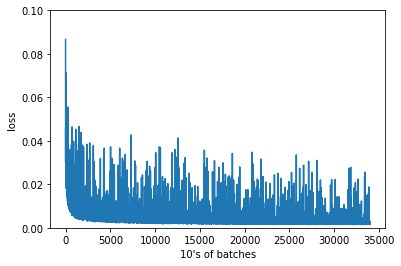

In [15]:
# visualize the loss as the network trained
plt.plot(training_loss)
plt.xlabel('10\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 0.1) # consistent scale
plt.show()

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [16]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 168, 168])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


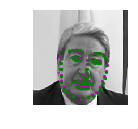

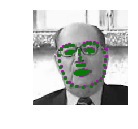

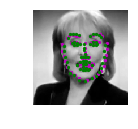

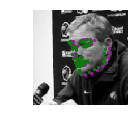

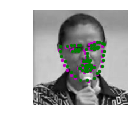

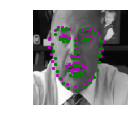

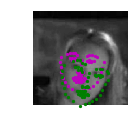

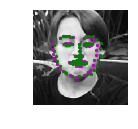

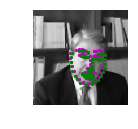

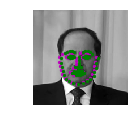

In [17]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts, batch_size)

Once you've found a good model (or two), save your model so you can load it and use it later!

In [18]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_4conv_1000.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


1. For optimization, I use the Adam optimizer with a learning rate of 0.001. In practice Adam is currently recommended as the default algorithm to use, and often works slightly better than RMSProp. 
2. For loss function, I choose MSELoss, Because the facial keypoints predication task is a regression problem. The output and ground truth are 68 keypoints, with coordinates (x, y), for that face. So I use MSELoss to create a criterion that measures the mean squared error between `n` elements in the input `x` and target `y`.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

### network architecture

![network architecture](./images/model.png)



The network consists of 16 layers, including 4 convolutional layers block and 2 fully connected layers. The input image is resized to 1x168x168 grayscale and passed to the network.  Following the input layer are 4 convolutional layers block. Each of them comprised of 32, 64, 128 and 256 filters with a 3x3 kernel. 
These convolution layers were followed by batch normal, Max pool 2x2 and dropout. The final is 2 fully connected layers. leaky_relu activations function is used throughout the whole network.

At the beginning, Batch normalization not used in the model, but I found the size of facial keypoints is small than target. I excluded data preprocess and visualization and narrow down the problem to the model design issue. I changed the model by adding a batch normalization after each convolutional layer. The output of this model has greatly improved.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

I set batch_size to 10 due to the limit of my system, Because I did the training on my PC wit a GTX980 GPU. If batch_size exceeds 10, it will report an out of memory error. I set the epochs to 1000, but according the loss figure, may be 300 epochs is fine.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

First convolutional layer


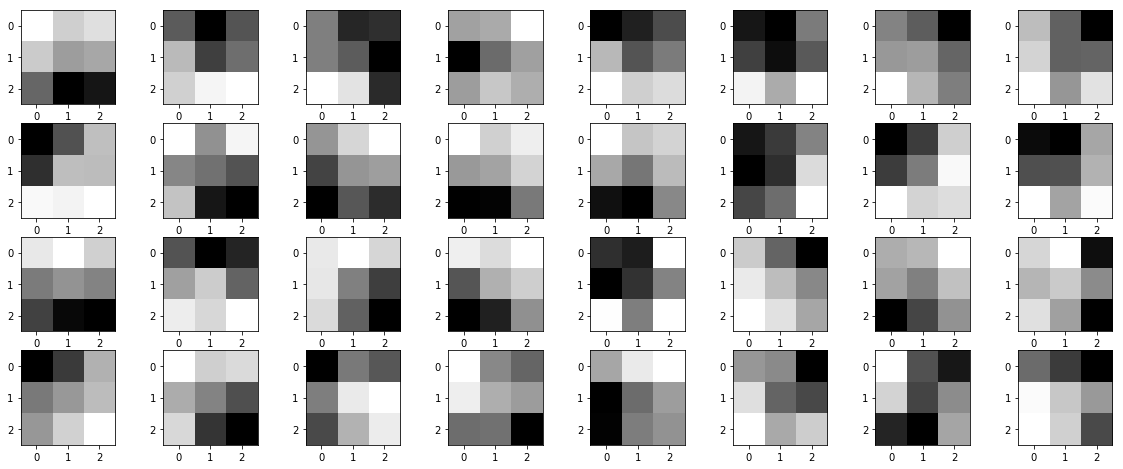

In [20]:
# Get the weights in the first conv layer
weights = net.conv1.weight.data
weights = weights.type(torch.FloatTensor).cpu()
w = weights.numpy()

# for 10 filters
fig=plt.figure(figsize=(20, 8))
columns = 8
rows = 4
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
print('First convolutional layer')
plt.show()

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

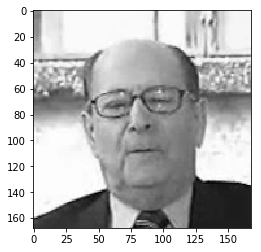

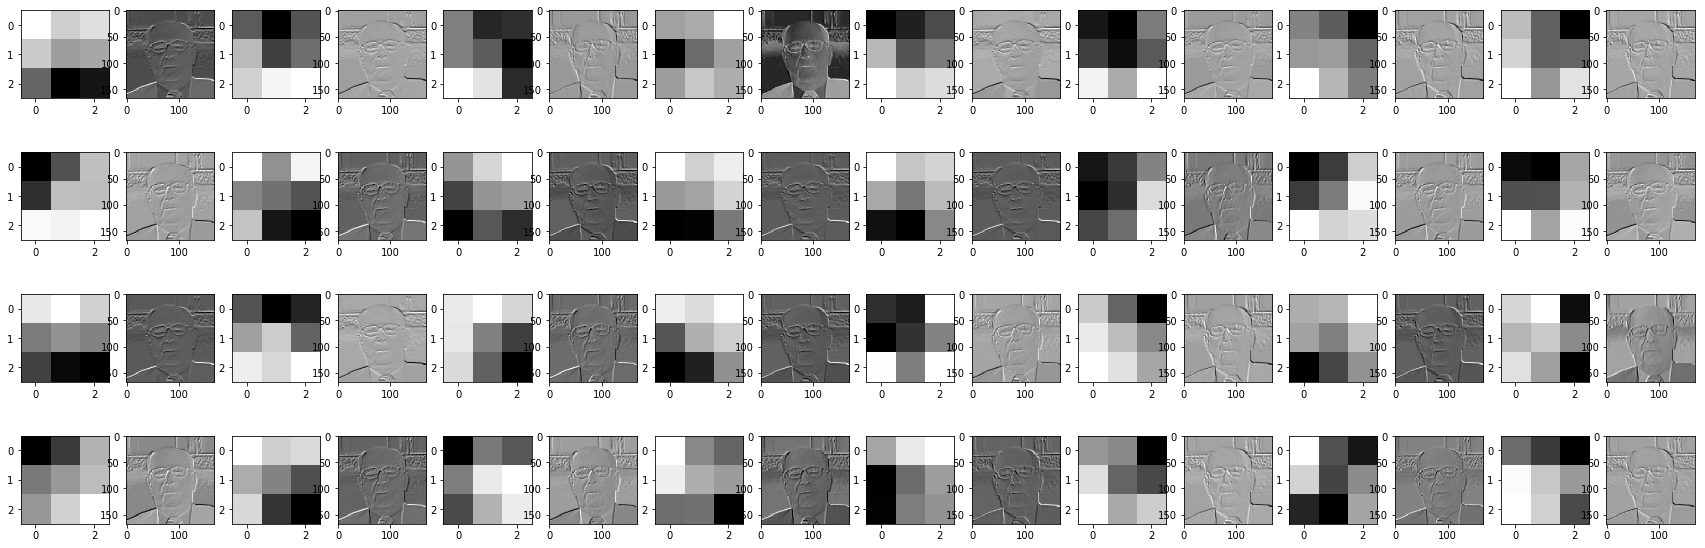

In [22]:
# select an image by index
idx = 1
image = test_images[idx].data   # get the image from it's wrapper
image = image.cpu().numpy()   # convert to numpy array from a Tensor
img = np.squeeze(image)

# Use OpenCV's filter2D function 
# apply a specific set of filter weights (like the one's displayed above) to the test image

import cv2
plt.imshow(img, cmap='gray')

weights = net.conv1.weight.data
weights = weights.type(torch.FloatTensor).to(device)
w = weights.cpu().numpy()

# 1. first conv layer
# for 10 filters
fig=plt.figure(figsize=(30, 10))
columns = 8 * 2
rows = 4
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


The first filter in the second row seems detect the horizontal line.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!